In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#NEW ADDRESSES
new_addresses = pd.read_csv("data/bitcoin-number-of-new-addresses.csv")

new_addresses["New Addresses/t"] = new_addresses["New Addresses/t"].str.rstrip("T00:00:00.000Z")
new_addresses["New Addresses/t"] = pd.to_datetime(new_addresses["New Addresses/t"])
new_addresses = new_addresses.sort_values(by='New Addresses/t')
new_addresses = new_addresses.rename(columns={'New Addresses/t': 'Timestamp', 'New Addresses/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
new_addresses = new_addresses[~(new_addresses['Timestamp'] < '2010-01-01')]
new_addresses = new_addresses[~(new_addresses['Timestamp'] > '2021-12-31')]

#fixing index
new_addresses.reset_index(drop=True, inplace=True)

#Description
print(new_addresses.head())
print("\nShape is:", new_addresses.shape)
print("\nSummary of the dataset:")
new_addresses.describe()
print("\nAre there null values?")
new_addresses.isna().sum()

   Timestamp  Value
0 2010-01-01    134
1 2010-01-01    190
2 2010-01-02    158
3 2010-01-02    126
4 2010-01-03    212

Shape is: (4383, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
new_addresses['year'] = [d.year for d in new_addresses["Timestamp"]]

new_addresses.year.unique()

new_addresses.year.value_counts()


2012    366
2016    366
2020    366
2010    365
2011    365
2013    365
2014    365
2015    365
2017    365
2018    365
2019    365
2021    365
Name: year, dtype: int64

In [4]:
#vediamo che i primi 3 giorni hanno 2 date, quindi faccio la media
new_addresses.head(20)

Timestamp  Value  year
0  2010-01-01    134  2010
1  2010-01-01    190  2010
2  2010-01-02    158  2010
3  2010-01-02    126  2010
4  2010-01-03    212  2010
5  2010-01-03    186  2010
6  2010-01-04    183  2010
7  2010-01-05    198  2010
8  2010-01-06    163  2010
9  2010-01-07    154  2010
10 2010-01-08    153  2010
11 2010-01-09    151  2010
12 2010-01-11    159  2010
13 2010-01-12    159  2010
14 2010-01-13    166  2010
15 2010-01-14    145  2010
16 2010-01-15    141  2010
17 2010-01-16    126  2010
18 2010-01-17    131  2010
19 2010-01-18    127  2010

In [5]:
new_addressesvalue0=(new_addresses["Value"].iloc[0] + new_addresses["Value"].iloc[1])/2
new_addressesvalue1=(new_addresses["Value"].iloc[2] + new_addresses["Value"].iloc[3])/2
new_addressesvalue2=(new_addresses["Value"].iloc[4] + new_addresses["Value"].iloc[5])/2

print(new_addressesvalue0, new_addressesvalue1, new_addressesvalue2)

162.0 142.0 199.0


In [6]:
new_addresses = new_addresses.drop(labels=0, axis=0)
new_addresses = new_addresses.drop(labels=2, axis=0)
new_addresses = new_addresses.drop(labels=4, axis=0)

In [7]:
#fixing index
new_addresses.reset_index(drop=True, inplace=True)

new_addresses["Value"].iloc[0] = new_addressesvalue0
new_addresses["Value"].iloc[1] = new_addressesvalue1
new_addresses["Value"].iloc[2] = new_addressesvalue2

<ipython-input-7-f041467c11c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_addresses["Value"].iloc[0] = new_addressesvalue0
<ipython-input-7-f041467c11c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_addresses["Value"].iloc[1] = new_addressesvalue1
<ipython-input-7-f041467c11c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_addresses["Value"].iloc[2] = new_addressesvalue2


In [8]:
new_addresses

Timestamp   Value  year
0    2010-01-01     162  2010
1    2010-01-02     142  2010
2    2010-01-03     199  2010
3    2010-01-04     183  2010
4    2010-01-05     198  2010
...         ...     ...   ...
4375 2021-12-26  355640  2021
4376 2021-12-27  419560  2021
4377 2021-12-28  461695  2021
4378 2021-12-29  468508  2021
4379 2021-12-31  447835  2021

[4380 rows x 3 columns]

# VISUALIZATION

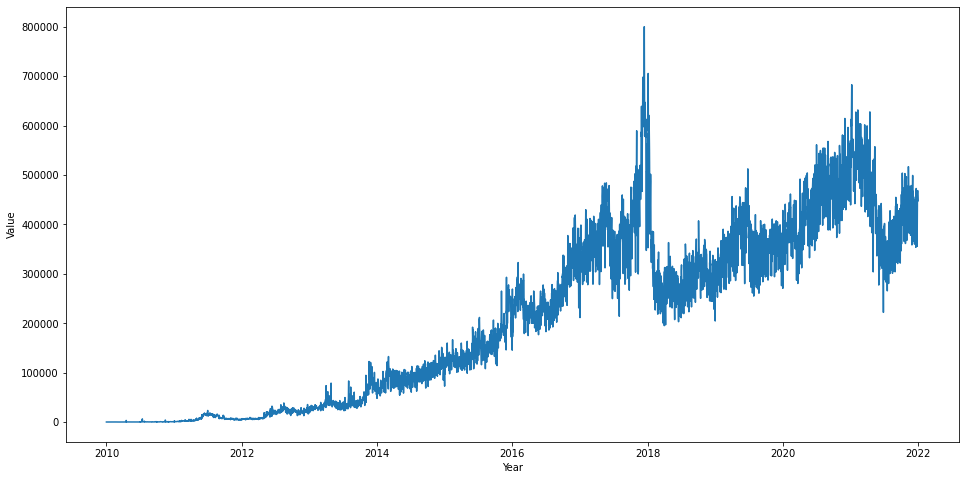

In [9]:
plt.figure(figsize=(16,8))
plt.plot(new_addresses["Timestamp"], new_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

In [10]:
plt.figure(figsize=(16,5))
sns.distplot(new_addresses["Value"], kde = False, bins = 60)
plt.title('Distribution of New Addresses', fontsize=16)
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


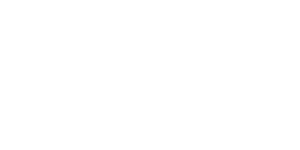

In [11]:
%matplotlib notebook

#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(16,8))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('New Addresses', color=color)
ax1.plot(new_addresses["Timestamp"], new_addresses["Value"], color=color, label='New addresses')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


#### Shorter time series
Same as market price

In [12]:
%matplotlib inline
new_addresses["Value"][new_addresses["Timestamp"].dt.year == 2014].mean()
newadh = new_addresses.loc[(new_addresses["Timestamp"].dt.year > 2016) & (new_addresses["Timestamp"].dt.year < 2022),:]
newadn = new_addresses.loc[(new_addresses["Timestamp"].dt.year > 2016) & (new_addresses["Timestamp"].dt.year < 2021),:]
newadnh = new_addresses.loc[(new_addresses["Timestamp"].dt.year > 2012) & (new_addresses["Timestamp"].dt.year < 2021),:]
newadf = new_addresses.loc[(new_addresses["Timestamp"].dt.year > 2012) & (new_addresses["Timestamp"].dt.year < 2022),:]

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.histplot(newadh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(newadn["Value"], ax=axes[0,1],bins = 20)
sns.histplot(newadnh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(newadf["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')


#### Checking monthly seasonality using multiple lines
Price follows a certain repetitive pattern every year? 

In [13]:
# Prepare data
new_addresses['year'] = [d.year for d in new_addresses["Timestamp"]]
new_addresses['month'] = [d.strftime('%b') for d in new_addresses["Timestamp"]]
years = new_addresses['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=new_addresses.loc[new_addresses.year==y, :], color=mycolors[i], label=y)

# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

#### Checking trend using boxplot
Price follows a yearly trend or monthly seasonality? 

In [14]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=new_addresses, ax=axes[0])
sns.boxplot(x='month', y="Value", data=new_addresses.loc[~new_addresses.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

plt.rc("figure", figsize=(16, 16))
res1 = STL(new_addresses["Value"], period=365, robust=True).fit()
res2 = STL(new_addresses["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('NEW ADDRESSES / 2010-2021 ')

Text(0.5, 0.98, 'NEW ADDRESSES / 2010-2021 ')

In [15]:
fig = res1.plot() #BIGGER VIEW

In [16]:
plt.rc("figure", figsize=(16, 16))
res3 = STL(newadh["Value"], period=365, robust=True).fit()
res4 = STL(newadh["Value"], period=365, robust=False).fit()

fig, axs = plt.subplots(ncols=3, figsize=(15,6))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')


fig.suptitle('NEW ADDRESSES / 2017-2021 ')

Text(0.5, 0.98, 'NEW ADDRESSES / 2017-2021 ')

#### Trend interpolation
We now try to interploate the trend with an exponential function.

In [17]:
#CI SONO DEI NULL VALUES DENTRO IL TREND. HO TROVATO QUESTA TECNICA

np.log(res3.trend)

2554    12.990233
2555    12.989691
2556    12.989148
2557    12.988606
2558    12.988063
          ...    
4375    12.973484
4376    12.973215
4377    12.972946
4378    12.972676
4379    12.972407
Name: trend, Length: 1826, dtype: float64

In [18]:
# y = a*exp(bx) --> log(y) = log(a)+bx
idx = np.isfinite(np.arange(len(newadh))) & np.isfinite(np.log(res3.trend))
coefs = np.polyfit(np.arange(len(newadh))[idx]+1, np.log(res3.trend)[idx],1)
coefs
# y = exp(coefs[1])*exp(coefs[0]*x)

array([1.35620634e-04, 1.27576927e+01])

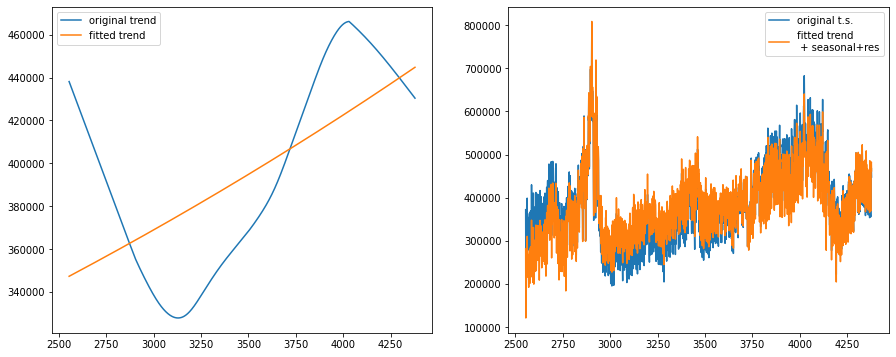

In [19]:
fitted = pd.Series(np.exp(coefs[1])*np.exp(coefs[0]*(np.arange(len(newadh))+1)), index = newadh.index)
#fitted.plot()
#res3.trend.plot()

fitted_season = fitted+res3.seasonal # fitted trend + seasonal decomposed series (orange) non so se ha senso calcolarlo
fitted_compl = fitted_season+res3.resid # fitted trend + seasonal decomposed series + residual decomposed series (green)
#hashh["Value"].plot()
#fitted_season.plot()
#fitted_compl.plot()

fig, axs = plt.subplots(ncols=2, figsize=(15,6))
axs[0].plot(res3.trend, label="original trend")
axs[0].plot(fitted, label="fitted trend")
axs[0].legend()
axs[1].plot(newadh["Value"], label='original t.s.')
#axs[1].plot(fitted_season, label='fitted trend\n + seasonal')
axs[1].plot(fitted_compl, label='fitted trend\n + seasonal+res')
axs[1].legend()

# TRAIN/VAL/TEST SPLIT

In [20]:
series = new_addresses['Value']

# Create train data set
train_split_date = '2020-12-31'
train_split_index = np.where(new_addresses.Timestamp == train_split_date)[0][0]
x_train = new_addresses.loc[new_addresses['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2021-06-29'
test_split_index = np.where(new_addresses.Timestamp == test_split_date)[0][0]
x_test = new_addresses.loc[new_addresses['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = new_addresses.loc[(new_addresses['Timestamp'] < test_split_date) & (new_addresses['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-01 to 2021-01-02 00:00:00 - Number of days = 4015
Validation set ranging from 2021-01-01 00:00:00 to 2021-06-28 00:00:00 - Number of days = 180
Test set ranging from 2021-06-29 00:00:00 to 2021-12-31 00:00:00 - Number of days = 185


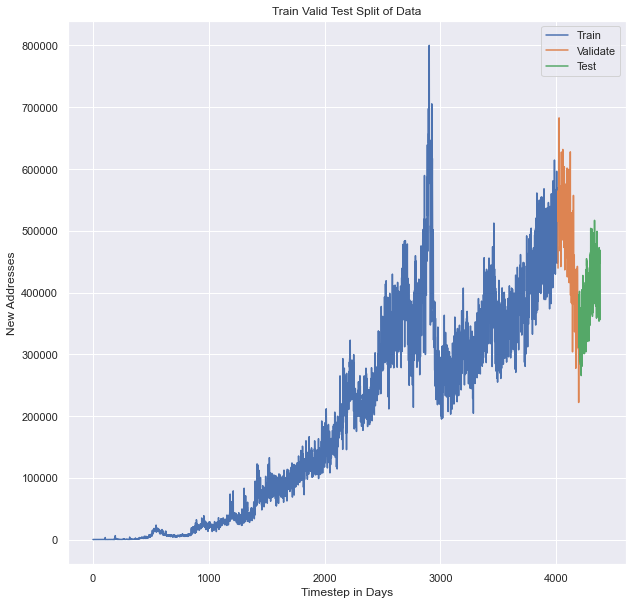

In [21]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-01 to", new_addresses.iloc[4017]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", new_addresses.iloc[x_valid.index.min()]["Timestamp"], "to", new_addresses.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", new_addresses.iloc[x_test.index.min()]["Timestamp"], "to", new_addresses.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [22]:
len(x_train.index)

4015

In [23]:
len(x_test.index)

185

In [24]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


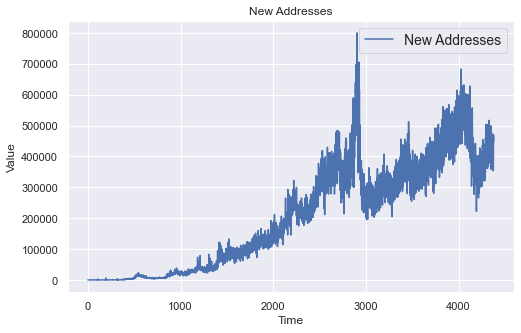

In [25]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(label)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=new_addresses.index,series=new_addresses['Value'], label = 'New Addresses')

In [26]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'New Addresses Forecast vs Actual')

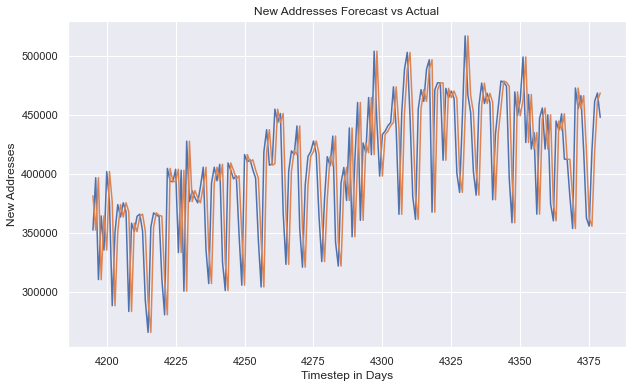

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('New Addresses Forecast vs Actual')

## Calculate Error in Naive Model

In [28]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 39603.2054054054}

In [29]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[381302 352327 396699]
[352327 396699 310351]
****************************************************************************************************
[28975 44372 86348]


ADESSO VADO A CREARE 2 MODELLI: 20 DAY E 5 DAY MOVING AVERAGE. MOTIVO SARA' ANCHE SPIEGATO NELLE CELLE SEGUENTI, TUTTAVIA FACCIO UNA PRECISAZIONE
- IL MODELLO 5MA SERVE A MODELLARE I 5 GIORNI DELLA SETTIMANA, IN QUANTO LA BORSA E' APERTA DA LUNEDI' A VENERDI', MENTRE GLI ALTRI GIORNI CHIUDE. 
- IL MODELLO 20MA E' COME IL PRECEDENTE, PERO' MENSILE, QUINDI MODELLA I 20 GIORNI IN CUI LA BORSA E' APERTA IN UN MESE.

TUTTO QUESTO NON VALE PER BITCOIN E CRYPTO, IN QUANTO E' SEMPRE POSSIBILE TRADARLI, OGNI ISTANTE.
IN OGNI CASO CI STA FARE QUESTA ANALISI, IN QUANTO MAGARI LA BORSA POTREBBE INFLUENZARE ANCHE LE CRYPTO

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

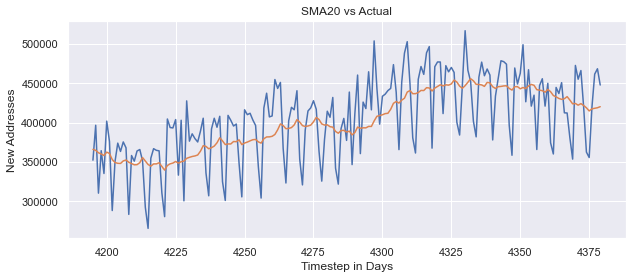

In [30]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = new_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index:]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [31]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 39603.2054054054, 'SMA 20': 33939.69189189189}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

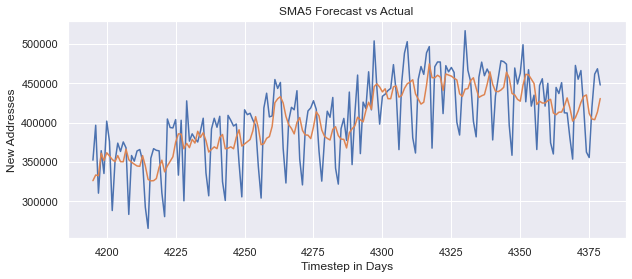

In [32]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = new_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index: ]
                                         
plt.figure(figsize=(10, 4))
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, moving_avg_forecast)
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [33]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108}

# ARIMA

Step 1: Is the data stationary?
Use Augmented Dickey Fuller test to determine if the data is stationary

- Failure to reject the null hypothesis means the data is not stationary

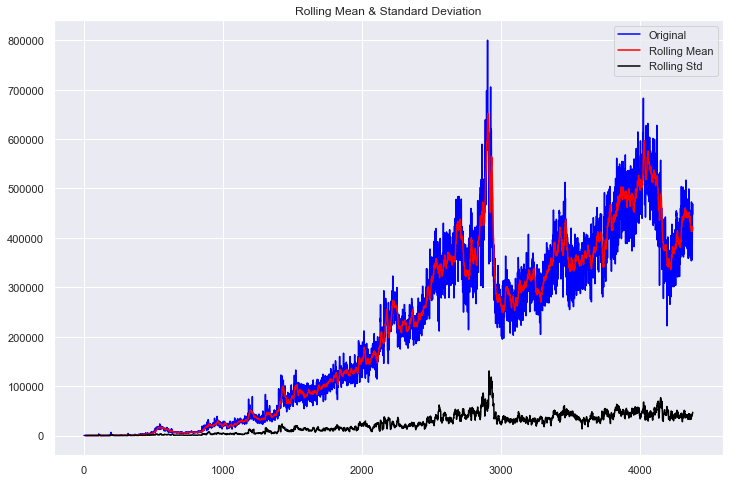

Results of Dickey-Fuller Test:
p-value = 0.7106. The series is likely non-stationary.
Test Statistic                   -1.111221
p-value                           0.710576
#Lags Used                       20.000000
Number of Observations Used    4359.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [34]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is lower than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

However, it seems, graphically, that the series is not stationary. 

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [35]:
# Get the difference of each Adj Close point
new_addresses_diff_1 = series.diff()
primo = series[0]

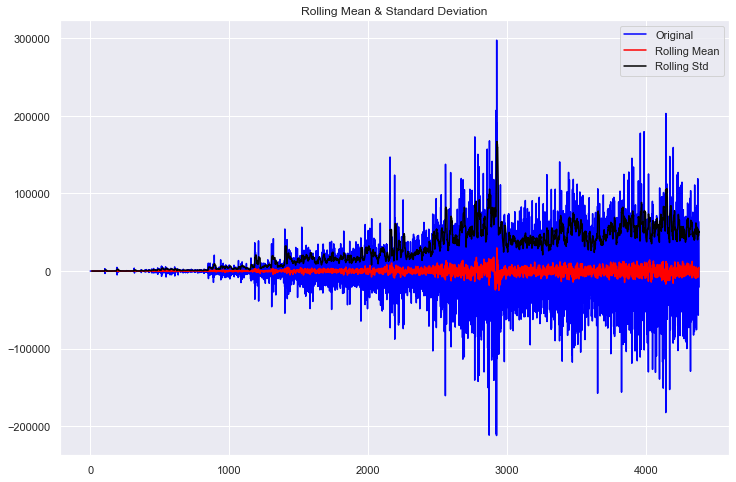

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -23.776059
p-value                           0.000000
#Lags Used                       20.000000
Number of Observations Used    4358.000000
Critical Value (1%)              -3.431851
Critical Value (5%)              -2.862203
Critical Value (10%)             -2.567123
dtype: float64


In [36]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(new_addresses_diff_1.dropna())

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

/usr/local/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


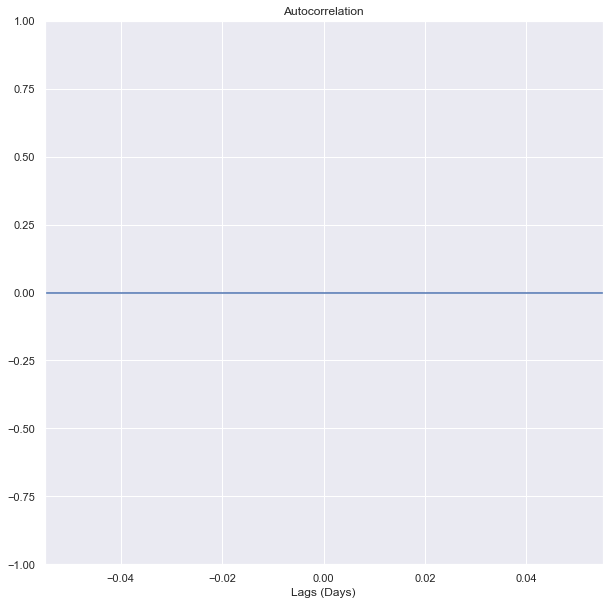

In [37]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(new_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

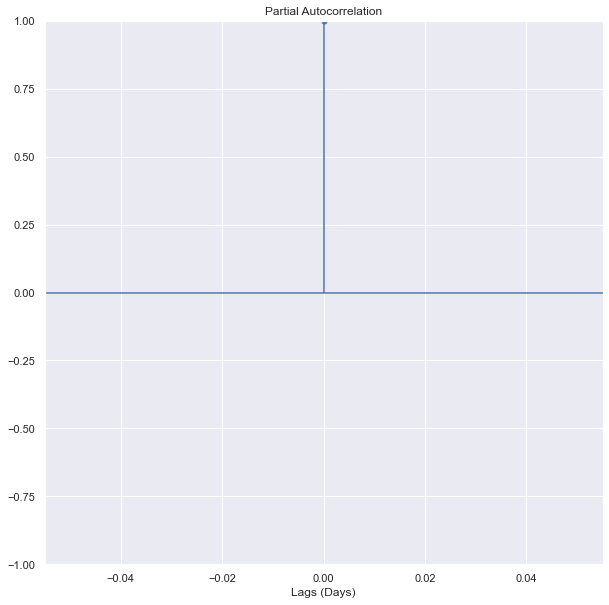

In [38]:
plot_pacf(new_addresses_diff_1, method='ywm')
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

SINCE THE DIFF SERIES IS THE ONLY STATIONARY ONE WE USE IT TO BUILD AND TRAIN THE MODELS. WE WILL RECONSTRUCT THE ORIGINAL SERIES REVERSEING THE DIFFERENCIATION.

We now split the diff series in train, test and validation

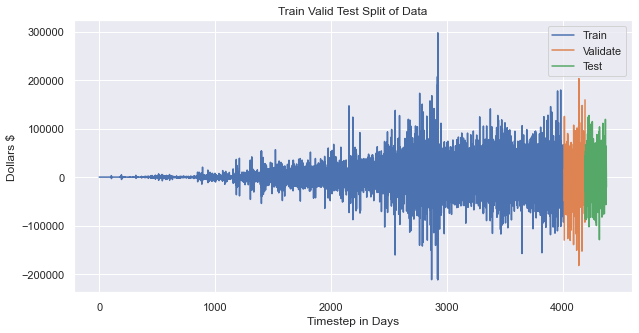

In [39]:
# Create train data set

x_train_diff = new_addresses_diff_1.loc[new_addresses['Timestamp'] <= train_split_date]

# Create test data set
x_test_diff = new_addresses_diff_1.loc[new_addresses['Timestamp'] >= test_split_date]

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid_diff = new_addresses_diff_1.loc[(new_addresses['Timestamp'] < test_split_date) & 
                           (new_addresses['Timestamp'] > train_split_date)]

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train_diff, label = 'Train')
plt.plot(x_valid_diff, label = 'Validate')
plt.plot(x_test_diff, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()

### Testing different arima models

In [40]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=93867.635, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=95251.462, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=94750.344, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=94031.404, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=95249.530, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=93974.585, Time=0.40 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=93868.252, Time=2.16 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=93869.151, Time=2.17 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=93879.326, Time=1.14 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=93863.667, Time=6.13 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=14.13 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=93870.050, Time=3.63 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.07 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=94741.911,

Abbiamo trovato che il miglior modello è ARIMA(3,2,0)(0,0,1)[7]

In [41]:
import statsmodels.api as sm

# fit model
new_addresses_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,2), seasonal_order=(0,0,2,7))
new_addresses_arima_fit = new_addresses_arima.fit()
print(new_addresses_arima_fit.summary())

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                    SARIMAX Results                                    
Dep. Variable:                           Value   No. Observations:                 4015
Model:             ARIMA(3, 1, 2)x(0, 0, 2, 7)   Log Likelihood              -46838.731
Date:                         Fri, 11 Nov 2022   AIC                          93693.461
Time:                                 14:32:20   BIC                          93743.841
Sample:                                      0   HQIC                         93711.316
                                        - 4015                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6335      0.024     26.352      0.000       0.586       0.681
ar.L2         -0.2991      0.011    -26.169      0.000     

In [42]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = new_addresses_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

NormaltestResult(statistic=475.61174934732446, pvalue=5.274980579365735e-104)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (3,1,3)(0,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

Ci mette parecchio a calcolare questa cella giù. Se si vuole risparmiare tempo allora bisogna abbassare il numero di data points da predire

### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [43]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Testing Mean Squared Error is 115684.1693274561
Stored 'model_predictions' (list)


In [44]:
output

array([521194.61270877])

In [45]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[508203.8159377269,
 488510.6800100957,
 487802.8372688825,
 514184.8102428011,
 537001.094448382]

In [46]:
model_predictions

[508203.8159377269,
 488510.6800100957,
 487802.8372688825,
 514184.8102428011,
 537001.094448382,
 537994.4105665128,
 528882.0115158017,
 522237.82950570295,
 515142.16050365276,
 518753.0845410615,
 521469.1975576468,
 525510.7205402701,
 523181.7709468255,
 520261.09567287035,
 520889.2844632778,
 520796.2554393831,
 521260.83533366263,
 521430.54324397905,
 521421.27677566407,
 521251.4837383663,
 521105.36929042015,
 521065.6159930055,
 521125.83539474494,
 521211.4150960737,
 521257.21786905424,
 521245.96531940525,
 521204.3669335454,
 521170.1535342753,
 521163.6865637934,
 521179.94732120767,
 521200.5593778226,
 521210.29732561595,
 521206.345122387,
 521195.90653887147,
 521188.0999877654,
 521187.2424759629,
 521191.57629084104,
 521196.4786337757,
 521198.5026301131,
 521197.2626769198,
 521194.67163722904,
 521192.91007555736,
 521192.87042540987,
 521194.0027070048,
 521195.1627613708,
 521195.5688011025,
 521195.2030570429,
 521194.5666028629,
 521194.1736034261,
 5211

In [47]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_true'] = arima_mae
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

In [48]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

<Figure size 720x432 with 0 Axes>

In [49]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

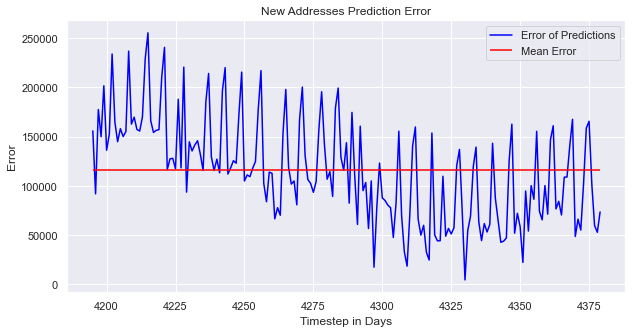

<Figure size 720x432 with 0 Axes>

In [50]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [51]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561}

### Secondo tipo di ARIMA: training ricorsivo fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

In [52]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point

for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Testing Mean Squared Error is 33937.919547313046
Stored 'model_predictions' (list)


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046}

### Terzo tipo di ARIMA: predizione con forecast(185)

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Testing Mean Squared Error is 115684.33426347029
Stored 'model_predictions' (ndarray)


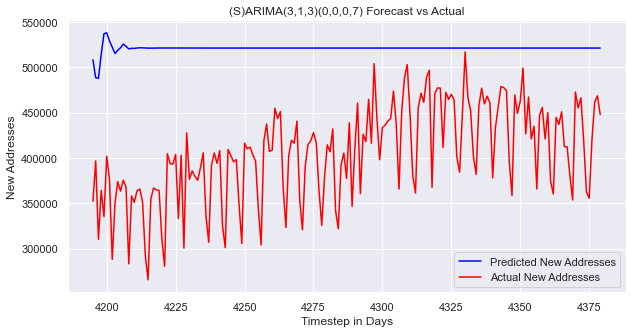

<Figure size 720x432 with 0 Axes>

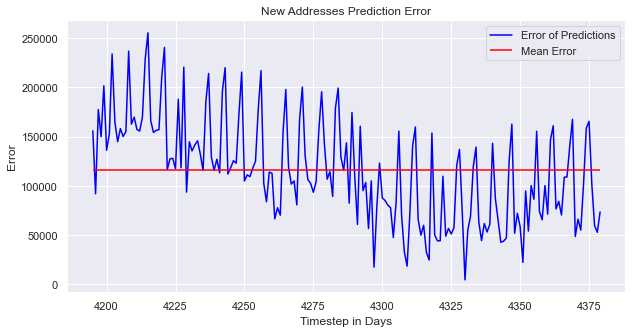

<Figure size 720x432 with 0 Axes>

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029}

In [53]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
#true_test_value = x_test[time_point]
#history.append(true_test_value)
#history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(3,1,3)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

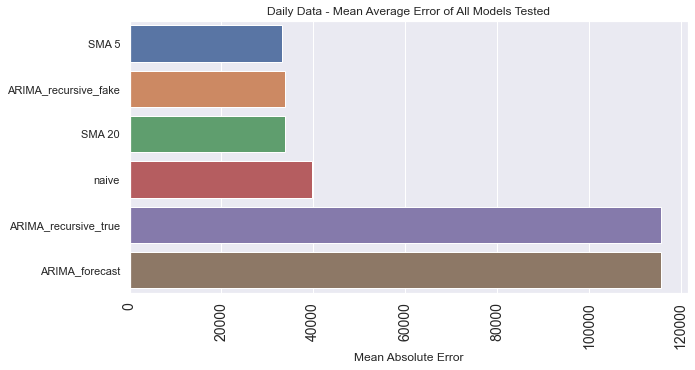

In [54]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

# LSTM

- LSTM stands for Long Short Term Memory
The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br> To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

In [55]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [56]:
x_train

0          162
1          142
2          199
3          183
4          198
         ...  
4010    448279
4011    503446
4012    510439
4013    560252
4014    569538
Name: Value, Length: 4015, dtype: int64

In [57]:
x_train.shape

(4015,)

In [58]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [59]:
x_train_values

array([[   162],
       [   142],
       [   199],
       ...,
       [510439],
       [560252],
       [569538]])

In [60]:
x_train_values.shape

(4015, 1)

In [61]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Find the learning rate

Spiegazione su come funziona: https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it

In [62]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


200/200 [==============================] - 9s 17ms/step - loss: 0.0029 - mae: 0.0548 - lr: 1.0000e-05
Epoch 2/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0016 - mae: 0.0476 - lr: 1.1220e-05
Epoch 3/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0012 - mae: 0.0383 - lr: 1.2589e-05
Epoch 4/100
200/200 [==============================] - 3s 15ms/step - loss: 9.5691e-04 - mae: 0.0322 - lr: 1.4125e-05
Epoch 5/100
200/200 [==============================] - 3s 15ms/step - loss: 8.8678e-04 - mae: 0.0287 - lr: 1.5849e-05
Epoch 6/100
200/200 [==============================] - 3s 16ms/step - loss: 8.6543e-04 - mae: 0.0270 - lr: 1.7783e-05
Epoch 7/100
200/200 [==============================] - 3s 16ms/step - loss: 8.5728e-04 - mae: 0.0264 - lr: 1.9953e-05
Epoch 8/100
200/200 [==============================] - 3s 16ms/step - loss: 8.5225e-04 - mae: 0.0261 - lr: 2.2387e-05
Epoch 9/100
200/200 [==============================] - 3s 16ms/step - loss: 8.47

200/200 [==============================] - 3s 15ms/step - loss: 0.0221 - mae: 0.1405 - lr: 0.0316
Epoch 72/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0323 - mae: 0.1244 - lr: 0.0355
Epoch 73/100
200/200 [==============================] - 3s 16ms/step - loss: 0.0393 - mae: 0.1535 - lr: 0.0398
Epoch 74/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0527 - mae: 0.1850 - lr: 0.0447
Epoch 75/100
200/200 [==============================] - 3s 16ms/step - loss: 0.0681 - mae: 0.2230 - lr: 0.0501
Epoch 76/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0684 - mae: 0.2372 - lr: 0.0562
Epoch 77/100
200/200 [==============================] - 3s 15ms/step - loss: 0.0881 - mae: 0.2847 - lr: 0.0631
Epoch 78/100
200/200 [==============================] - 3s 14ms/step - loss: 0.1085 - mae: 0.3357 - lr: 0.0708
Epoch 79/100
200/200 [==============================] - 3s 15ms/step - loss: 0.1101 - mae: 0.3464 - lr: 0.0794
Epoch 80/100
2

(1e-05, 0.1, 0.0, 0.03)

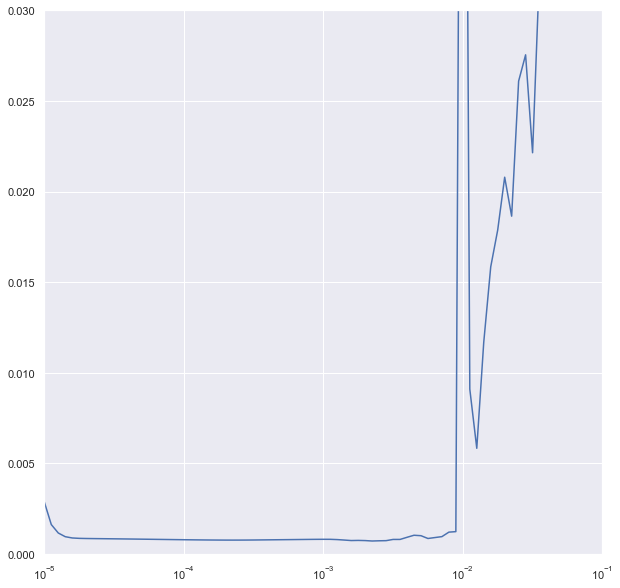

In [63]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 0.03])

In [64]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00033

In [65]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
    133/Unknown - 8s 24ms/step - loss: 0.0023 - mae: 0.0384

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 34s 215ms/step - loss: 0.0023 - mae: 0.0384 - val_loss: 0.0038 - val_mae: 0.0661
Epoch 2/500
133/133 [==============================] - 3s 22ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0048 - val_mae: 0.0748
Epoch 3/500
133/133 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0337

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 0.0018 - mae: 0.0337 - val_loss: 0.0030 - val_mae: 0.0620
Epoch 4/500
131/133 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0312

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 27s 203ms/step - loss: 0.0017 - mae: 0.0316 - val_loss: 0.0027 - val_mae: 0.0587
Epoch 5/500
133/133 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0286

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 28s 214ms/step - loss: 0.0012 - mae: 0.0286 - val_loss: 0.0026 - val_mae: 0.0582
Epoch 6/500
131/133 [============================>.] - ETA: 0s - loss: 9.0414e-04 - mae: 0.0264

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 191ms/step - loss: 9.2404e-04 - mae: 0.0268 - val_loss: 0.0024 - val_mae: 0.0558
Epoch 7/500
133/133 [==============================] - ETA: 0s - loss: 8.2487e-04 - mae: 0.0257

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 187ms/step - loss: 8.2487e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0556
Epoch 8/500
131/133 [============================>.] - ETA: 0s - loss: 8.1455e-04 - mae: 0.0254

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 8.3581e-04 - mae: 0.0259 - val_loss: 0.0024 - val_mae: 0.0555
Epoch 9/500
133/133 [==============================] - 3s 21ms/step - loss: 8.2068e-04 - mae: 0.0256 - val_loss: 0.0024 - val_mae: 0.0556
Epoch 10/500
133/133 [==============================] - 3s 22ms/step - loss: 8.2596e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0556
Epoch 11/500
133/133 [==============================] - 3s 21ms/step - loss: 8.2366e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0557
Epoch 12/500
133/133 [==============================] - 3s 22ms/step - loss: 8.2501e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0557
Epoch 13/500
133/133 [==============================] - 3s 23ms/step - loss: 8.2338e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0557
Epoch 14/500
133/133 [==============================] - 3s 22ms/step - loss: 8.2198e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0557
Epoch 15/500
133/133 [=================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 178ms/step - loss: 8.1905e-04 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0556
Epoch 16/500
131/133 [============================>.] - ETA: 0s - loss: 7.9486e-04 - mae: 0.0252

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 182ms/step - loss: 8.1585e-04 - mae: 0.0256 - val_loss: 0.0024 - val_mae: 0.0556
Epoch 17/500
131/133 [============================>.] - ETA: 0s - loss: 7.9091e-04 - mae: 0.0251

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 188ms/step - loss: 8.1180e-04 - mae: 0.0256 - val_loss: 0.0024 - val_mae: 0.0555
Epoch 18/500
131/133 [============================>.] - ETA: 0s - loss: 7.8665e-04 - mae: 0.0250

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 8.0744e-04 - mae: 0.0255 - val_loss: 0.0024 - val_mae: 0.0554
Epoch 19/500
133/133 [==============================] - ETA: 0s - loss: 8.0260e-04 - mae: 0.0254

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 185ms/step - loss: 8.0260e-04 - mae: 0.0254 - val_loss: 0.0024 - val_mae: 0.0553
Epoch 20/500
132/133 [============================>.] - ETA: 0s - loss: 7.8680e-04 - mae: 0.0251

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 176ms/step - loss: 7.9753e-04 - mae: 0.0253 - val_loss: 0.0024 - val_mae: 0.0553
Epoch 21/500
133/133 [==============================] - ETA: 0s - loss: 7.9232e-04 - mae: 0.0252

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 182ms/step - loss: 7.9232e-04 - mae: 0.0252 - val_loss: 0.0024 - val_mae: 0.0552
Epoch 22/500
131/133 [============================>.] - ETA: 0s - loss: 7.6710e-04 - mae: 0.0246

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 190ms/step - loss: 7.8722e-04 - mae: 0.0251 - val_loss: 0.0024 - val_mae: 0.0552
Epoch 23/500
132/133 [============================>.] - ETA: 0s - loss: 7.7233e-04 - mae: 0.0247

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 182ms/step - loss: 7.8251e-04 - mae: 0.0250 - val_loss: 0.0023 - val_mae: 0.0551
Epoch 24/500
133/133 [==============================] - ETA: 0s - loss: 7.7847e-04 - mae: 0.0248

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 26s 195ms/step - loss: 7.7847e-04 - mae: 0.0248 - val_loss: 0.0023 - val_mae: 0.0551
Epoch 25/500
131/133 [============================>.] - ETA: 0s - loss: 7.5566e-04 - mae: 0.0243

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 28s 211ms/step - loss: 7.7523e-04 - mae: 0.0247 - val_loss: 0.0023 - val_mae: 0.0551
Epoch 26/500
132/133 [============================>.] - ETA: 0s - loss: 7.6301e-04 - mae: 0.0244

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 26s 195ms/step - loss: 7.7265e-04 - mae: 0.0246 - val_loss: 0.0023 - val_mae: 0.0551
Epoch 27/500
131/133 [============================>.] - ETA: 0s - loss: 7.5104e-04 - mae: 0.0241

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 190ms/step - loss: 7.7037e-04 - mae: 0.0245 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 28/500
131/133 [============================>.] - ETA: 0s - loss: 7.4883e-04 - mae: 0.0240

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 182ms/step - loss: 7.6807e-04 - mae: 0.0244 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 29/500
132/133 [============================>.] - ETA: 0s - loss: 7.5581e-04 - mae: 0.0241

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 183ms/step - loss: 7.6510e-04 - mae: 0.0243 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 30/500
131/133 [============================>.] - ETA: 0s - loss: 7.4383e-04 - mae: 0.0238

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 7.6285e-04 - mae: 0.0242 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 31/500
132/133 [============================>.] - ETA: 0s - loss: 7.4770e-04 - mae: 0.0238

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 7.5669e-04 - mae: 0.0240 - val_loss: 0.0023 - val_mae: 0.0549
Epoch 32/500
131/133 [============================>.] - ETA: 0s - loss: 7.2997e-04 - mae: 0.0234

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 188ms/step - loss: 7.4815e-04 - mae: 0.0238 - val_loss: 0.0023 - val_mae: 0.0547
Epoch 33/500
131/133 [============================>.] - ETA: 0s - loss: 7.1344e-04 - mae: 0.0230

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 7.2905e-04 - mae: 0.0234 - val_loss: 0.0022 - val_mae: 0.0536
Epoch 34/500
132/133 [============================>.] - ETA: 0s - loss: 7.0940e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 7.1722e-04 - mae: 0.0233 - val_loss: 0.0022 - val_mae: 0.0530
Epoch 35/500
133/133 [==============================] - 3s 21ms/step - loss: 7.0781e-04 - mae: 0.0234 - val_loss: 0.0022 - val_mae: 0.0529
Epoch 36/500
132/133 [============================>.] - ETA: 0s - loss: 6.9593e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 7.0422e-04 - mae: 0.0233 - val_loss: 0.0021 - val_mae: 0.0526
Epoch 37/500
133/133 [==============================] - 3s 21ms/step - loss: 7.0053e-04 - mae: 0.0229 - val_loss: 0.0021 - val_mae: 0.0526
Epoch 38/500
133/133 [==============================] - ETA: 0s - loss: 6.9919e-04 - mae: 0.0231

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 185ms/step - loss: 6.9919e-04 - mae: 0.0231 - val_loss: 0.0021 - val_mae: 0.0520
Epoch 39/500
131/133 [============================>.] - ETA: 0s - loss: 6.7662e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 6.9263e-04 - mae: 0.0229 - val_loss: 0.0021 - val_mae: 0.0521
Epoch 40/500
132/133 [============================>.] - ETA: 0s - loss: 6.8516e-04 - mae: 0.0228

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 6.9321e-04 - mae: 0.0230 - val_loss: 0.0021 - val_mae: 0.0517
Epoch 41/500
131/133 [============================>.] - ETA: 0s - loss: 6.6816e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 180ms/step - loss: 6.8377e-04 - mae: 0.0228 - val_loss: 0.0021 - val_mae: 0.0514
Epoch 42/500
132/133 [============================>.] - ETA: 0s - loss: 6.7151e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 27s 206ms/step - loss: 6.7935e-04 - mae: 0.0226 - val_loss: 0.0021 - val_mae: 0.0515
Epoch 43/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7833e-04 - mae: 0.0227 - val_loss: 0.0021 - val_mae: 0.0516
Epoch 44/500
132/133 [============================>.] - ETA: 0s - loss: 6.6687e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 28s 215ms/step - loss: 6.7471e-04 - mae: 0.0226 - val_loss: 0.0021 - val_mae: 0.0514
Epoch 45/500
132/133 [============================>.] - ETA: 0s - loss: 6.6928e-04 - mae: 0.0226

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 184ms/step - loss: 6.7731e-04 - mae: 0.0228 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 46/500
133/133 [==============================] - 3s 20ms/step - loss: 6.7901e-04 - mae: 0.0228 - val_loss: 0.0020 - val_mae: 0.0519
Epoch 47/500
132/133 [============================>.] - ETA: 0s - loss: 6.6457e-04 - mae: 0.0224

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 25s 188ms/step - loss: 6.7310e-04 - mae: 0.0226 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 48/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7267e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0517
Epoch 49/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7301e-04 - mae: 0.0226 - val_loss: 0.0020 - val_mae: 0.0517
Epoch 50/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7941e-04 - mae: 0.0227 - val_loss: 0.0021 - val_mae: 0.0520
Epoch 51/500
133/133 [==============================] - 3s 21ms/step - loss: 6.9126e-04 - mae: 0.0229 - val_loss: 0.0021 - val_mae: 0.0522
Epoch 52/500
133/133 [==============================] - 3s 20ms/step - loss: 6.8599e-04 - mae: 0.0228 - val_loss: 0.0021 - val_mae: 0.0523
Epoch 53/500
133/133 [==============================] - 3s 21ms/step - loss: 6.9287e-04 - mae: 0.0230 - val_loss: 0.0020 - val_mae: 0.0523
Epoch 54/500
133/133 [================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 179ms/step - loss: 6.7488e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0518
Epoch 56/500
133/133 [==============================] - 3s 20ms/step - loss: 6.6540e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0519
Epoch 57/500
133/133 [==============================] - 3s 23ms/step - loss: 6.7773e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0521
Epoch 58/500
133/133 [==============================] - 3s 22ms/step - loss: 6.6911e-04 - mae: 0.0225 - val_loss: 0.0021 - val_mae: 0.0518
Epoch 59/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7599e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0519
Epoch 60/500
133/133 [==============================] - 3s 22ms/step - loss: 6.6575e-04 - mae: 0.0225 - val_loss: 0.0021 - val_mae: 0.0519
Epoch 61/500
131/133 [============================>.] - ETA: 0s - loss: 6.5280e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 23s 177ms/step - loss: 6.7042e-04 - mae: 0.0226 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 62/500
133/133 [==============================] - 3s 20ms/step - loss: 6.6099e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0518
Epoch 63/500
133/133 [==============================] - ETA: 0s - loss: 6.6610e-04 - mae: 0.0225

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 185ms/step - loss: 6.6610e-04 - mae: 0.0225 - val_loss: 0.0020 - val_mae: 0.0515
Epoch 64/500
133/133 [==============================] - 3s 21ms/step - loss: 6.6028e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0521
Epoch 65/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7346e-04 - mae: 0.0228 - val_loss: 0.0020 - val_mae: 0.0517
Epoch 66/500
133/133 [==============================] - 3s 21ms/step - loss: 6.6433e-04 - mae: 0.0225 - val_loss: 0.0021 - val_mae: 0.0522
Epoch 67/500
133/133 [==============================] - 3s 20ms/step - loss: 6.8167e-04 - mae: 0.0229 - val_loss: 0.0020 - val_mae: 0.0517
Epoch 68/500
133/133 [==============================] - 3s 21ms/step - loss: 6.6881e-04 - mae: 0.0226 - val_loss: 0.0021 - val_mae: 0.0523
Epoch 69/500
133/133 [==============================] - 3s 21ms/step - loss: 6.7300e-04 - mae: 0.0227 - val_loss: 0.0020 - val_mae: 0.0513
Epoch 70/500
133/133 [================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 6.5366e-04 - mae: 0.0223 - val_loss: 0.0020 - val_mae: 0.0513
Epoch 71/500
133/133 [==============================] - 3s 20ms/step - loss: 6.5758e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0512
Epoch 72/500
131/133 [============================>.] - ETA: 0s - loss: 6.3237e-04 - mae: 0.0218

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 185ms/step - loss: 6.5085e-04 - mae: 0.0223 - val_loss: 0.0020 - val_mae: 0.0511
Epoch 73/500
133/133 [==============================] - 3s 23ms/step - loss: 6.5510e-04 - mae: 0.0223 - val_loss: 0.0021 - val_mae: 0.0512
Epoch 74/500
133/133 [==============================] - ETA: 0s - loss: 6.4829e-04 - mae: 0.0222

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 183ms/step - loss: 6.4829e-04 - mae: 0.0222 - val_loss: 0.0020 - val_mae: 0.0510
Epoch 75/500
133/133 [==============================] - 3s 21ms/step - loss: 6.5437e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0513
Epoch 76/500
133/133 [==============================] - 3s 21ms/step - loss: 6.4724e-04 - mae: 0.0223 - val_loss: 0.0020 - val_mae: 0.0510
Epoch 77/500
133/133 [==============================] - 3s 21ms/step - loss: 6.5399e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0514
Epoch 78/500
133/133 [==============================] - 3s 22ms/step - loss: 6.4571e-04 - mae: 0.0224 - val_loss: 0.0020 - val_mae: 0.0511
Epoch 79/500
133/133 [==============================] - 3s 22ms/step - loss: 6.5582e-04 - mae: 0.0224 - val_loss: 0.0021 - val_mae: 0.0512
Epoch 80/500
133/133 [==============================] - 3s 21ms/step - loss: 6.4508e-04 - mae: 0.0225 - val_loss: 0.0020 - val_mae: 0.0511
Epoch 81/500
133/133 [================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 178ms/step - loss: 6.4622e-04 - mae: 0.0224 - val_loss: 0.0019 - val_mae: 0.0500
Epoch 86/500
133/133 [==============================] - 3s 21ms/step - loss: 6.2795e-04 - mae: 0.0219 - val_loss: 0.0021 - val_mae: 0.0506
Epoch 87/500
133/133 [==============================] - 3s 21ms/step - loss: 6.1955e-04 - mae: 0.0218 - val_loss: 0.0019 - val_mae: 0.0501
Epoch 88/500
133/133 [==============================] - 3s 21ms/step - loss: 6.4318e-04 - mae: 0.0222 - val_loss: 0.0020 - val_mae: 0.0509
Epoch 89/500
133/133 [==============================] - 3s 22ms/step - loss: 6.3947e-04 - mae: 0.0223 - val_loss: 0.0019 - val_mae: 0.0495
Epoch 90/500
133/133 [==============================] - 3s 22ms/step - loss: 6.1564e-04 - mae: 0.0216 - val_loss: 0.0020 - val_mae: 0.0501
Epoch 91/500
133/133 [==============================] - 3s 22ms/step - loss: 6.1477e-04 - mae: 0.0217 - val_loss: 0.0020 - val_mae: 0.0501
Epoch 92/500
133/133 [================

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 29s 220ms/step - loss: 6.8868e-04 - mae: 0.0230 - val_loss: 0.0018 - val_mae: 0.0490
Epoch 97/500
133/133 [==============================] - 3s 22ms/step - loss: 6.1532e-04 - mae: 0.0216 - val_loss: 0.0018 - val_mae: 0.0496
Epoch 98/500
133/133 [==============================] - 3s 21ms/step - loss: 6.0748e-04 - mae: 0.0216 - val_loss: 0.0021 - val_mae: 0.0527
Epoch 99/500
133/133 [==============================] - 3s 21ms/step - loss: 5.9573e-04 - mae: 0.0214 - val_loss: 0.0023 - val_mae: 0.0528
Epoch 100/500
133/133 [==============================] - 3s 21ms/step - loss: 5.9928e-04 - mae: 0.0213 - val_loss: 0.0020 - val_mae: 0.0516
Epoch 101/500
133/133 [==============================] - 3s 22ms/step - loss: 6.1000e-04 - mae: 0.0215 - val_loss: 0.0019 - val_mae: 0.0507
Epoch 102/500
133/133 [==============================] - 3s 21ms/step - loss: 5.9478e-04 - mae: 0.0213 - val_loss: 0.0019 - val_mae: 0.0488
Epoch 103/500
133/133 [============

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


133/133 [==============================] - 24s 181ms/step - loss: 5.5211e-04 - mae: 0.0217 - val_loss: 0.0018 - val_mae: 0.0483
Epoch 144/500
133/133 [==============================] - 3s 21ms/step - loss: 5.2196e-04 - mae: 0.0207 - val_loss: 0.0022 - val_mae: 0.0521
Epoch 145/500
133/133 [==============================] - 3s 21ms/step - loss: 5.1031e-04 - mae: 0.0208 - val_loss: 0.0023 - val_mae: 0.0549
Epoch 146/500
133/133 [==============================] - 3s 22ms/step - loss: 5.0546e-04 - mae: 0.0206 - val_loss: 0.0024 - val_mae: 0.0551
Epoch 147/500
133/133 [==============================] - 3s 21ms/step - loss: 5.6657e-04 - mae: 0.0218 - val_loss: 0.0024 - val_mae: 0.0558
Epoch 148/500
133/133 [==============================] - 3s 21ms/step - loss: 5.1579e-04 - mae: 0.0208 - val_loss: 0.0028 - val_mae: 0.0608
Epoch 149/500
133/133 [==============================] - 3s 21ms/step - loss: 5.3529e-04 - mae: 0.0216 - val_loss: 0.0020 - val_mae: 0.0494
Epoch 150/500
133/133 [=========

### Make predictions

In [66]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
#rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
#rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 34ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 35ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 37ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 31ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 28ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 25ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 26ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

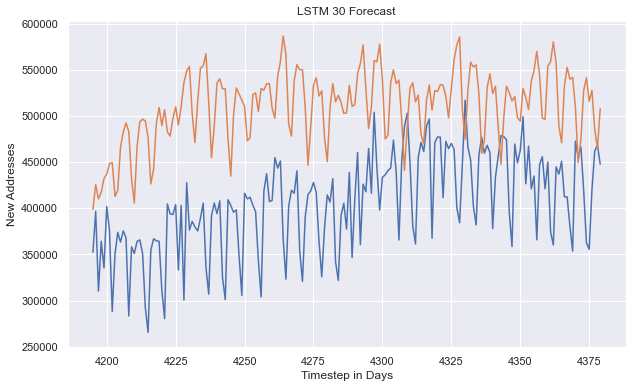

In [67]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [68]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_iterative'] = lstm
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622}

In [69]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

In [70]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

1/1 [==============================] - 1s 1s/step


(185,)

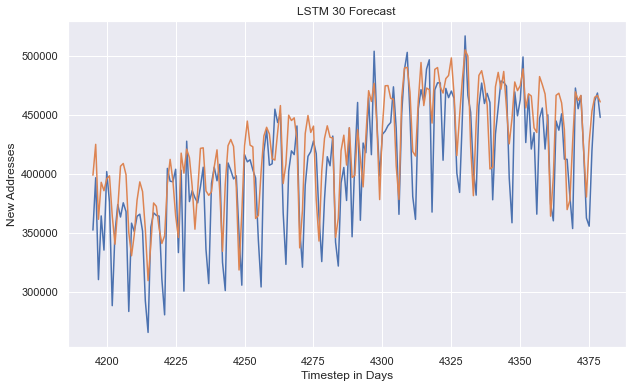

In [71]:
window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [72]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM_predict'] = lstm
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

# CNN

Full CNNs are becoming more commom to detect trends in NLP and time series modeling. A popular architecture is the WaveNet architecture proposed by Deep Mind in 2016.

In WaveNet, every layer has kernel size 2, stride 1, causal padding, and using ReLU activation functions. However, the 2nd layer uses a dilation rate of 2. This means it skips every other input timestep. The next layer uses a dilation rate of 4 which means it skips every 3 input time steps. The fourth layer uses a dilation rate of 8 which means it skips every 7 timesteps out of 8. This patter continues which enables the lower layers to learn shorter term patterns while the deeper layers learn the longer term patterns.

The last layer acts as a dense layer to output a single value.

In [73]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [74]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


32/32 [==============================] - 6s 33ms/step - loss: 0.0439 - mae: 0.2210 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0342 - mae: 0.1945 - lr: 1.0798e-04
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0225 - mae: 0.1637 - lr: 1.1659e-04
Epoch 4/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0134 - mae: 0.1345 - lr: 1.2589e-04
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 0.0095 - mae: 0.1175 - lr: 1.3594e-04
Epoch 6/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0072 - mae: 0.1025 - lr: 1.4678e-04
Epoch 7/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0044 - mae: 0.0770 - lr: 1.5849e-04
Epoch 8/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0022 - mae: 0.0499 - lr: 1.7113e-04
Epoch 9/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0015 - mae: 0.0387 - lr: 1.8478e-04
Epoc

32/32 [==============================] - 1s 31ms/step - loss: 0.0236 - mae: 0.1793 - lr: 0.0271
Epoch 75/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0232 - mae: 0.1769 - lr: 0.0293
Epoch 76/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0224 - mae: 0.1728 - lr: 0.0316
Epoch 77/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0225 - mae: 0.1723 - lr: 0.0341
Epoch 78/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0218 - mae: 0.1680 - lr: 0.0369
Epoch 79/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0210 - mae: 0.1639 - lr: 0.0398
Epoch 80/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0209 - mae: 0.1629 - lr: 0.0430
Epoch 81/100
32/32 [==============================] - 1s 32ms/step - loss: 0.0201 - mae: 0.1588 - lr: 0.0464
Epoch 82/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0194 - mae: 0.1555 - lr: 0.0501
Epoch 83/100
32/32 [============

In [75]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

(0.0001, 0.1, 0.0, 0.04)

In [76]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00027

In [77]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
32/32 [==============================] - 9s 164ms/step - loss: 0.0027 - mae: 0.0525 - val_loss: 0.0050 - val_mae: 0.0848
Epoch 2/500
32/32 [==============================] - 4s 133ms/step - loss: 0.0012 - mae: 0.0330 - val_loss: 0.0027 - val_mae: 0.0610
Epoch 3/500
32/32 [==============================] - 4s 132ms/step - loss: 0.0010 - mae: 0.0292 - val_loss: 0.0030 - val_mae: 0.0653
Epoch 4/500
32/32 [==============================] - 4s 133ms/step - loss: 8.6340e-04 - mae: 0.0270 - val_loss: 0.0032 - val_mae: 0.0629
Epoch 5/500
32/32 [==============================] - 4s 133ms/step - loss: 0.0011 - mae: 0.0305 - val_loss: 0.0034 - val_mae: 0.0700
Epoch 6/500
32/32 [==============================] - 4s 131ms/step - loss: 7.6468e-04 - mae: 0.0248 - val_loss: 0.0040 - val_mae: 0.0761
Epoch 7/500
32/32 [==============================] - 4s 132ms/step - loss: 6.8265e-04 - mae: 0.0236 - val_loss: 0.0029 - val_mae: 0.0634
Epoch 8/500
32/32 [==============================] - 4s 1

32/32 [==============================] - 4s 132ms/step - loss: 5.8710e-04 - mae: 0.0221 - val_loss: 0.0038 - val_mae: 0.0734
Epoch 61/500
32/32 [==============================] - 4s 131ms/step - loss: 6.3193e-04 - mae: 0.0224 - val_loss: 0.0052 - val_mae: 0.0878
Epoch 62/500
32/32 [==============================] - 4s 132ms/step - loss: 6.2249e-04 - mae: 0.0223 - val_loss: 0.0038 - val_mae: 0.0734
Epoch 63/500
32/32 [==============================] - 4s 133ms/step - loss: 5.8137e-04 - mae: 0.0216 - val_loss: 0.0023 - val_mae: 0.0527
Epoch 64/500
32/32 [==============================] - 4s 133ms/step - loss: 5.5745e-04 - mae: 0.0221 - val_loss: 0.0020 - val_mae: 0.0513
Epoch 65/500
32/32 [==============================] - 4s 132ms/step - loss: 5.9787e-04 - mae: 0.0213 - val_loss: 0.0054 - val_mae: 0.0902
Epoch 66/500
32/32 [==============================] - 4s 131ms/step - loss: 5.9865e-04 - mae: 0.0222 - val_loss: 0.0035 - val_mae: 0.0665
Epoch 67/500
32/32 [===========================

In [78]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
101 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
102 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
103 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
104 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
105 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
106 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
107 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
108 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
109 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
110 fatto
(1, 1, 1)
1/1 [==============================] - 0s 27ms/step
(1, 1, 1)
111 fatto
(1, 1, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 1)
112 fatto
(1, 1, 1)
1/1 [===========

(185,)

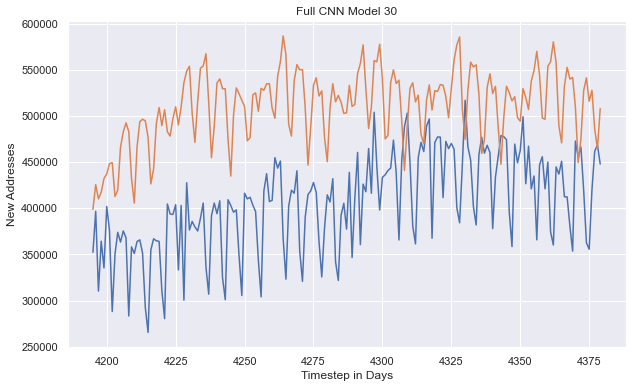

In [79]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

In [80]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_iterative'] = cnn
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622,
 'LSTM_predict': 26801.148141891892,
 'CNN_iterative': 106043.99121621622}

Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

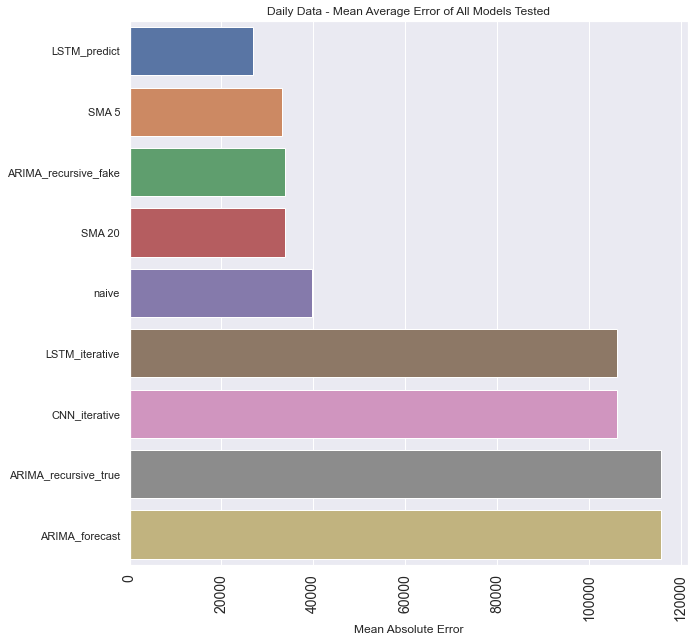

In [81]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

In [82]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, np.concatenate((normalized_x_valid[-29:], normalized_x_test)), window_size)
cnn_forecast = cnn_forecast[:,-1,0]
cnn_forecast.shape
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

6/6 [==============================] - 1s 14ms/step


(185,)

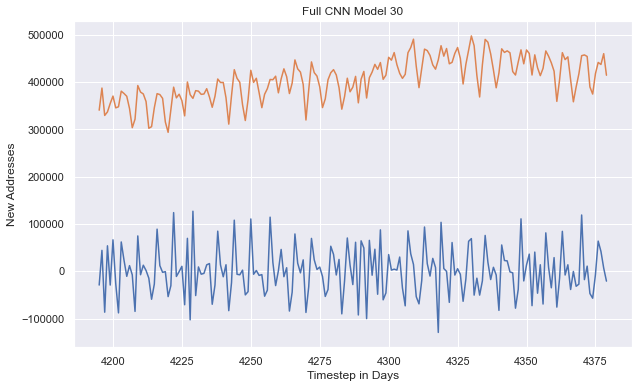

In [83]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test_diff)
plt.plot(x_test.index, cnn_unscaled_forecast)



Text(0.5, 1.0, 'Daily Data - Mean Average Error of All Models Tested')

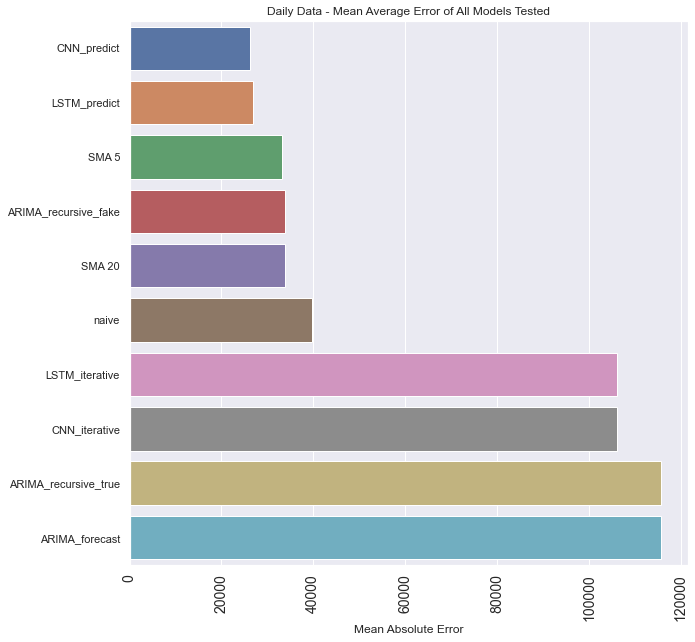

In [84]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN_predict'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Daily Data - Mean Average Error of All Models Tested')

## DOWNSAMPLING A SERIE TEMPORALE WEEKLY

In [85]:
new_addresses_weekly = new_addresses
new_addresses_weekly = new_addresses_weekly.set_index('Timestamp')

new_addresses_weekly = new_addresses_weekly.resample('W').mean()
new_addresses_weekly


Value    year
Timestamp                        
2010-01-03     167.666667  2010.0
2010-01-10     167.000000  2010.0
2010-01-17     146.714286  2010.0
2010-01-24     147.333333  2010.0
2010-01-31     186.166667  2010.0
...                   ...     ...
2021-12-05  444012.000000  2021.0
2021-12-12  418102.333333  2021.0
2021-12-19  413103.000000  2021.0
2021-12-26  421956.000000  2021.0
2022-01-02  449399.500000  2021.0

[627 rows x 2 columns]

In [86]:
new_addresses_weekly["Timestamp"] = new_addresses_weekly.index
new_addresses_weekly

Value    year  Timestamp
Timestamp                                   
2010-01-03     167.666667  2010.0 2010-01-03
2010-01-10     167.000000  2010.0 2010-01-10
2010-01-17     146.714286  2010.0 2010-01-17
2010-01-24     147.333333  2010.0 2010-01-24
2010-01-31     186.166667  2010.0 2010-01-31
...                   ...     ...        ...
2021-12-05  444012.000000  2021.0 2021-12-05
2021-12-12  418102.333333  2021.0 2021-12-12
2021-12-19  413103.000000  2021.0 2021-12-19
2021-12-26  421956.000000  2021.0 2021-12-26
2022-01-02  449399.500000  2021.0 2022-01-02

[627 rows x 3 columns]

In [87]:
new_addresses_weekly.reset_index(drop=True, inplace=True)
new_addresses_weekly

Value    year  Timestamp
0       167.666667  2010.0 2010-01-03
1       167.000000  2010.0 2010-01-10
2       146.714286  2010.0 2010-01-17
3       147.333333  2010.0 2010-01-24
4       186.166667  2010.0 2010-01-31
..             ...     ...        ...
622  444012.000000  2021.0 2021-12-05
623  418102.333333  2021.0 2021-12-12
624  413103.000000  2021.0 2021-12-19
625  421956.000000  2021.0 2021-12-26
626  449399.500000  2021.0 2022-01-02

[627 rows x 3 columns]

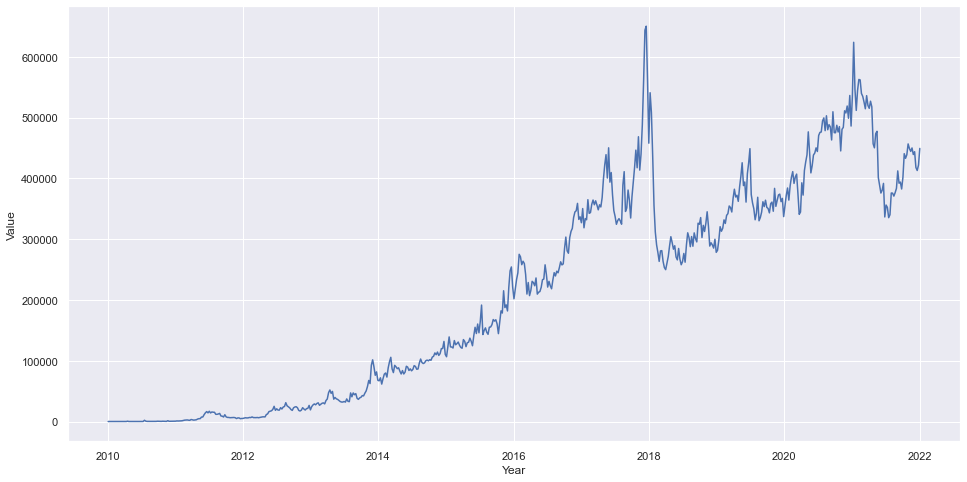

In [88]:
plt.figure(figsize=(16,8))
plt.plot(new_addresses_weekly["Timestamp"], new_addresses_weekly["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

# TRAIN/VAL/TEST SPLIT

data fine train = 2021-01-03 00:00:00  data inizio test = 2021-07-04 00:00:00


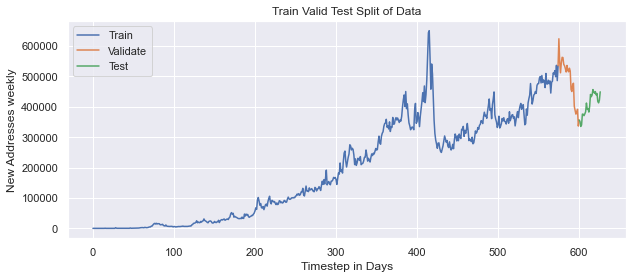

In [89]:
series = new_addresses_weekly['Value']

tr_idx_w = new_addresses_weekly.index[int((train_split_index/new_addresses.shape[0])*new_addresses_weekly.shape[0])]
te_idx_w = new_addresses_weekly.index[int((test_split_index/new_addresses.shape[0])*new_addresses_weekly.shape[0])]
print('data fine train =',new_addresses_weekly['Timestamp'][tr_idx_w], ' data inizio test =', new_addresses_weekly['Timestamp'][te_idx_w])

x_train = new_addresses_weekly.loc[:tr_idx_w,'Value']
x_test = new_addresses_weekly.loc[te_idx_w:,'Value']
x_valid = new_addresses_weekly.loc[tr_idx_w:te_idx_w,'Value']

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 4]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('New Addresses weekly')
plt.xlabel('Timestep in Days')
plt.legend()

In [90]:
test_stationarity(series)

Results of Dickey-Fuller Test:
p-value = 0.7986. The series is likely non-stationary.
Test Statistic                  -0.867177
p-value                          0.798589
#Lags Used                      15.000000
Number of Observations Used    611.000000
Critical Value (1%)             -3.441098
Critical Value (5%)             -2.866282
Critical Value (10%)            -2.569295
dtype: float64


In [91]:
# Get the difference of each Adj Close point
new_addresses_diff_1 = series.diff()
new_addresses_diff_1.dropna(inplace=True)

# Plot the tsla Adj Close 1st order difference
test_stationarity(new_addresses_diff_1)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.800012e+00
p-value                        7.537114e-12
#Lags Used                     1.400000e+01
Number of Observations Used    6.110000e+02
Critical Value (1%)           -3.441098e+00
Critical Value (5%)           -2.866282e+00
Critical Value (10%)          -2.569295e+00
dtype: float64


In [92]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(new_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [93]:
plot_pacf(new_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12887.513, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12886.281, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12886.130, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12885.870, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12885.806, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=12887.241, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=12887.173, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=12889.115, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12885.283, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=12886.041, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=12887.959, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=12886.899, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=12886.773, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=

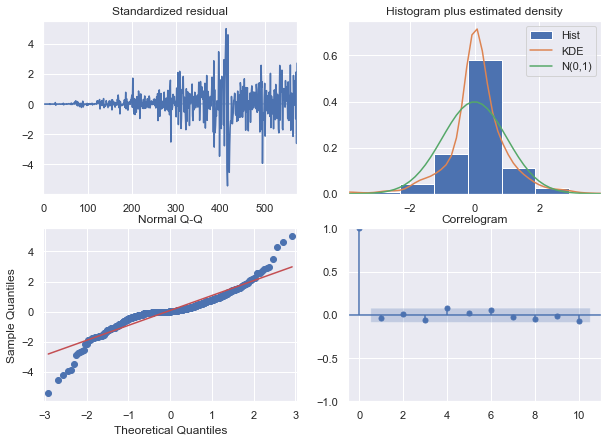

In [94]:
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

input_seasonality = 7

# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)

In [95]:
# fit model
new_addresses_arima = sm.tsa.arima.ARIMA(x_train, order=(3,1,2), seasonal_order=(0,0,2,7))
new_addresses_arima_fit = new_addresses_arima.fit()
print(new_addresses_arima_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           Value   No. Observations:                  575
Model:             ARIMA(3, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -6436.731
Date:                         Fri, 11 Nov 2022   AIC                          12889.461
Time:                                 16:17:46   BIC                          12924.282
Sample:                                      0   HQIC                         12903.043
                                         - 575                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5731      0.249     -2.303      0.021      -1.061      -0.085
ar.L2         -0.1619      0.209     -0.776      0.438     

In [96]:
residuals = new_addresses_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

NormaltestResult(statistic=107.42920423149342, pvalue=4.699424789955015e-24)
This distribution is not a normal distribution


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


### Primo tipo di ARIMA: training ricorsivo true: train, predico 1 giorno, appendo la predizione, re-traino e così via

In [97]:
# Create list of x train valuess
history = [x for x in x_train]

In [98]:
# establish list for predictions
model_predictions = []

In [99]:
# Count number of test data points
N_test_observations = len(x_test)

#in questo modo prendo oggi, prevedo domani, appendo la previsione al trainset, retraino, predico ancora. 
#Questo è recursive learning, o autoregressive learning
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    #history.append(true_test_value)
    history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 121632.53565516286
Stored 'model_predictions' (list)


In [100]:
output

array([526557.78468545])

In [101]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[527775.0851567608,
 532804.3870429031,
 525467.119000781,
 529973.2801057784,
 527961.8277450461]

In [102]:
model_predictions

[527775.0851567608,
 532804.3870429031,
 525467.119000781,
 529973.2801057784,
 527961.8277450461,
 529951.1656731264,
 527243.924526719,
 527220.1588738217,
 526858.9302097686,
 527006.4386401268,
 527268.6304876141,
 526475.5585253818,
 527633.3776016326,
 526437.382502215,
 526570.360730618,
 526452.9585255769,
 526628.3154173709,
 526532.4262016397,
 526571.7385985006,
 526545.7461562324,
 526564.6283042564,
 526553.7317127729,
 526559.7277340322,
 526556.0036253171,
 526558.3519149501,
 526556.9594989422,
 526557.7846854491]

In [103]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly = {}
model_mae_scores_weekly['ARIMA_weekly_recursive_true'] = arima_mae
model_mae_scores['ARIMA_weekly_recursive_true'] = arima_mae
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622,
 'LSTM_predict': 26801.148141891892,
 'CNN_iterative': 106043.99121621622,
 'CNN_predict': 26219.569932432434,
 'ARIMA_weekly_recursive_true': 121632.53565516286}

In [104]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(1,2,0)(2,0,2,52) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

<Figure size 720x432 with 0 Axes>

In [105]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

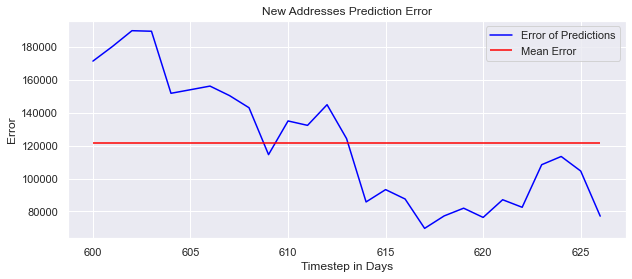

<Figure size 720x432 with 0 Axes>

In [106]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [107]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622,
 'LSTM_predict': 26801.148141891892,
 'CNN_iterative': 106043.99121621622,
 'CNN_predict': 26219.569932432434,
 'ARIMA_weekly_recursive_true': 121632.53565516286}

### Secondo tipo di ARIMA: predizione ricorsiva fake: train, predico, aggiungo al trainset il primo valore VERO del test set e ricomincio (quindi sarebbe una predizione di un giorno, visto che appendo il valore vero del test set)

Testing Mean Squared Error is 19766.998032854004
Stored 'model_predictions' (list)


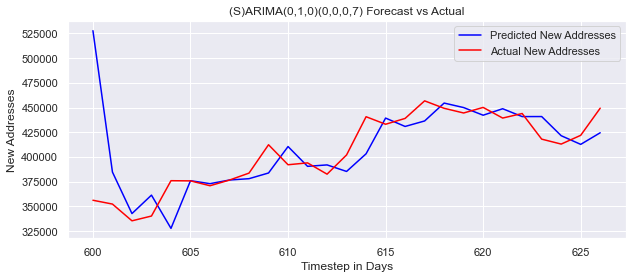

<Figure size 720x432 with 0 Axes>

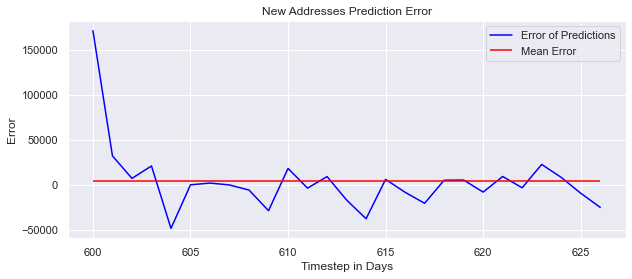

<Figure size 720x432 with 0 Axes>

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622,
 'LSTM_predict': 26801.148141891892,
 'CNN_iterative': 106043.99121621622,
 'CNN_predict': 26219.569932432434,
 'ARIMA_weekly_recursive_true': 121632.53565516286,
 'ARIMA_weekly_recursive_fake': 19766.998032854004}

In [108]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
    #history.append(yhat)
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['ARIMA_weekly_recursive_fake'] = arima_mae
model_mae_scores['ARIMA_weekly_recursive_fake'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

### Terzo tipo di ARIMA: predizione ricorsiva true: train, predico, aggiungo al trainset il primo valore PREDETTO del test set e ricomincio

Testing Mean Squared Error is 121633.00945174947
Stored 'model_predictions' (ndarray)


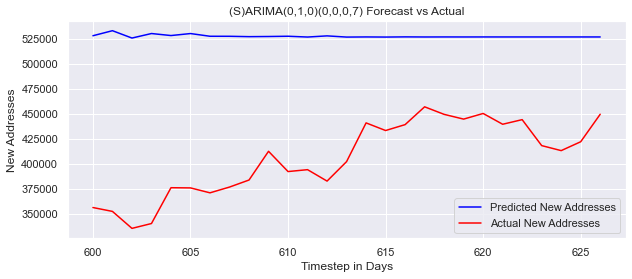

<Figure size 720x432 with 0 Axes>

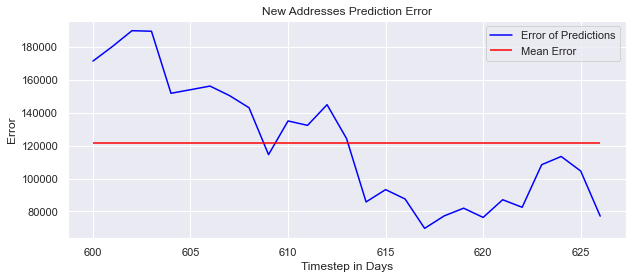

<Figure size 720x432 with 0 Axes>

{'naive': 39603.2054054054,
 'SMA 20': 33939.69189189189,
 'SMA 5': 33138.12108108108,
 'ARIMA_recursive_true': 115684.1693274561,
 'ARIMA_recursive_fake': 33937.919547313046,
 'ARIMA_forecast': 115684.33426347029,
 'LSTM_iterative': 106043.99121621622,
 'LSTM_predict': 26801.148141891892,
 'CNN_iterative': 106043.99121621622,
 'CNN_predict': 26219.569932432434,
 'ARIMA_weekly_recursive_true': 121632.53565516286,
 'ARIMA_weekly_recursive_fake': 19766.998032854004,
 'ARIMA_weekly_forecast': 121633.00945174947}

In [109]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

#Invece qui sotto faccio training e finisco. 
#Poi predico domani, metto in input la predizione e predico dopodomani, accumulando l'errore.
#Spiegata in matematichese per bene qui, su iterative forecasting:
#https://thuijskens.github.io/2016/08/03/time-series-forecasting/
# loop through every data point
model = sm.tsa.arima.ARIMA(history, order=(3,1,2), seasonal_order=(0,0,2,7))
model_fit = model.fit()
output = model_fit.forecast(len(x_test))
#yhat = output[0]
model_predictions = output
    
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['ARIMA_weekly_forecast'] = arima_mae
model_mae_scores['ARIMA_weekly_forecast'] = arima_mae
model_mae_scores

# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted New Addresses')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual New Addresses')
plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title('(S)ARIMA(0,1,0)(0,0,0,7) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('New Addresses Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# LSTM

In [110]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [111]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


28/28 [==============================] - 5s 15ms/step - loss: 0.0603 - mae: 0.2613 - lr: 1.0000e-05
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0538 - mae: 0.2447 - lr: 1.1220e-05
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0473 - mae: 0.2289 - lr: 1.2589e-05
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0403 - mae: 0.2108 - lr: 1.4125e-05
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0327 - mae: 0.1895 - lr: 1.5849e-05
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0244 - mae: 0.1641 - lr: 1.7783e-05
Epoch 7/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0159 - mae: 0.1334 - lr: 1.9953e-05
Epoch 8/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0083 - mae: 0.0981 - lr: 2.2387e-05
Epoch 9/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0039 - mae: 0.0682 - lr: 2.5119e-05
Epoc

Epoch 75/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0209 - mae: 0.1319 - lr: 0.0501
Epoch 76/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0129 - mae: 0.0905 - lr: 0.0562
Epoch 77/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0121 - mae: 0.0905 - lr: 0.0631
Epoch 78/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0159 - mae: 0.1343 - lr: 0.0708
Epoch 79/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0201 - mae: 0.1523 - lr: 0.0794
Epoch 80/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0308 - mae: 0.1822 - lr: 0.0891
Epoch 81/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0072 - mae: 0.0875 - lr: 0.1000
Epoch 82/100
28/28 [==============================] - 0s 16ms/step - loss: 0.0063 - mae: 0.0900 - lr: 0.1122
Epoch 83/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0451 - mae: 0.2077 - lr: 0.1259
Epoch 84/100
28/28 

In [112]:
#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.001

In [113]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     18/Unknown - 6s 18ms/step - loss: 0.0884 - mae: 0.2547  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 7s 85ms/step - loss: 0.0839 - mae: 0.2436
Epoch 2/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0085 - mae: 0.0936WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 0.0081 - mae: 0.0920
Epoch 3/500
19/19 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0640WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 0.0049 - mae: 0.0640
Epoch 4/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0457   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 0.0024 - mae: 0.0458
Epoch 5/500
19/19 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0513WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 0.0028 - mae: 0.0513
Epoch 6/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0408   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0021 - mae: 0.0409
Epoch 7/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0412   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0020 - mae: 0.0412
Epoch 8/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0393   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 0.0019 - mae: 0.0394
Epoch 9/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0382   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0018 - mae: 0.0383
Epoch 10/500
19/19 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0370   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0370
Epoch 11/500
19/19 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0356   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0016 - mae: 0.0356
Epoch 12/500
19/19 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0347   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 0.0015 - mae: 0.0347
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0347   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 0.0016 - mae: 0.0347
Epoch 14/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0349   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0353
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 0.0138 - mae: 0.0808   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 0.0138 - mae: 0.0808
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 0.0162 - mae: 0.1056WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 0.0162 - mae: 0.1056
Epoch 17/500
19/19 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0793WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 0.0067 - mae: 0.0793
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0487WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 0.0044 - mae: 0.0487
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0302   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 0.0011 - mae: 0.0302
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 9.2317e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 9.2317e-04 - mae: 0.0253
Epoch 21/500
19/19 [==============================] - ETA: 0s - loss: 9.2704e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 9.2704e-04 - mae: 0.0260
Epoch 22/500
19/19 [==============================] - ETA: 0s - loss: 8.7122e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 8.7122e-04 - mae: 0.0243
Epoch 23/500
19/19 [==============================] - ETA: 0s - loss: 8.6606e-04 - mae: 0.0247WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 8.6606e-04 - mae: 0.0247
Epoch 24/500
19/19 [==============================] - ETA: 0s - loss: 8.3786e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 8.3786e-04 - mae: 0.0240
Epoch 25/500
19/19 [==============================] - ETA: 0s - loss: 8.2764e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 8.2764e-04 - mae: 0.0241
Epoch 26/500
19/19 [==============================] - ETA: 0s - loss: 8.0751e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 8.0751e-04 - mae: 0.0238
Epoch 27/500
19/19 [==============================] - ETA: 0s - loss: 7.9539e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 7.9539e-04 - mae: 0.0237
Epoch 28/500
19/19 [==============================] - ETA: 0s - loss: 7.7880e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.7880e-04 - mae: 0.0235
Epoch 29/500
19/19 [==============================] - ETA: 0s - loss: 7.6631e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 7.6631e-04 - mae: 0.0234
Epoch 30/500
19/19 [==============================] - ETA: 0s - loss: 7.5172e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.5172e-04 - mae: 0.0232
Epoch 31/500
17/19 [=========================>....] - ETA: 0s - loss: 7.6590e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 7.3951e-04 - mae: 0.0231
Epoch 32/500
19/19 [==============================] - ETA: 0s - loss: 7.2636e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.2636e-04 - mae: 0.0229
Epoch 33/500
19/19 [==============================] - ETA: 0s - loss: 7.1484e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 7.1484e-04 - mae: 0.0228
Epoch 34/500
19/19 [==============================] - ETA: 0s - loss: 7.0302e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 7.0302e-04 - mae: 0.0227
Epoch 35/500
19/19 [==============================] - ETA: 0s - loss: 6.9244e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.9244e-04 - mae: 0.0225
Epoch 36/500
19/19 [==============================] - ETA: 0s - loss: 6.8186e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.8186e-04 - mae: 0.0224
Epoch 37/500
18/19 [===========================>..] - ETA: 0s - loss: 6.8775e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.7229e-04 - mae: 0.0223
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 6.6285e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.6285e-04 - mae: 0.0221
Epoch 39/500
19/19 [==============================] - ETA: 0s - loss: 6.5423e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5423e-04 - mae: 0.0220
Epoch 40/500
19/19 [==============================] - ETA: 0s - loss: 6.4578e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.4578e-04 - mae: 0.0219
Epoch 41/500
19/19 [==============================] - ETA: 0s - loss: 6.3803e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.3803e-04 - mae: 0.0218
Epoch 42/500
19/19 [==============================] - ETA: 0s - loss: 6.3043e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.3043e-04 - mae: 0.0217
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 6.2344e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.2344e-04 - mae: 0.0216
Epoch 44/500
19/19 [==============================] - ETA: 0s - loss: 6.1658e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.1658e-04 - mae: 0.0215
Epoch 45/500
19/19 [==============================] - ETA: 0s - loss: 6.1027e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1027e-04 - mae: 0.0214
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 6.0406e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0406e-04 - mae: 0.0213
Epoch 47/500
19/19 [==============================] - ETA: 0s - loss: 5.9834e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 5.9834e-04 - mae: 0.0212
Epoch 48/500
19/19 [==============================] - ETA: 0s - loss: 5.9270e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.9270e-04 - mae: 0.0211
Epoch 49/500
19/19 [==============================] - ETA: 0s - loss: 5.8754e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.8754e-04 - mae: 0.0210
Epoch 50/500
19/19 [==============================] - ETA: 0s - loss: 5.8241e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.8241e-04 - mae: 0.0209
Epoch 51/500
19/19 [==============================] - ETA: 0s - loss: 5.7775e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.7775e-04 - mae: 0.0208
Epoch 52/500
19/19 [==============================] - ETA: 0s - loss: 5.7309e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.7309e-04 - mae: 0.0207
Epoch 53/500
17/19 [=========================>....] - ETA: 0s - loss: 5.7540e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.6891e-04 - mae: 0.0206
Epoch 54/500
19/19 [==============================] - ETA: 0s - loss: 5.6467e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.6467e-04 - mae: 0.0205
Epoch 55/500
19/19 [==============================] - ETA: 0s - loss: 5.6096e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.6096e-04 - mae: 0.0205
Epoch 56/500
19/19 [==============================] - ETA: 0s - loss: 5.5711e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.5711e-04 - mae: 0.0204
Epoch 57/500
19/19 [==============================] - ETA: 0s - loss: 5.5385e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.5385e-04 - mae: 0.0203
Epoch 58/500
19/19 [==============================] - ETA: 0s - loss: 5.5036e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.5036e-04 - mae: 0.0202
Epoch 59/500
19/19 [==============================] - ETA: 0s - loss: 5.4755e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.4755e-04 - mae: 0.0202
Epoch 60/500
19/19 [==============================] - ETA: 0s - loss: 5.4437e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.4437e-04 - mae: 0.0201
Epoch 61/500
19/19 [==============================] - ETA: 0s - loss: 5.4202e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.4202e-04 - mae: 0.0201
Epoch 62/500
19/19 [==============================] - ETA: 0s - loss: 5.3909e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.3909e-04 - mae: 0.0200
Epoch 63/500
19/19 [==============================] - ETA: 0s - loss: 5.3722e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.3722e-04 - mae: 0.0200
Epoch 64/500
19/19 [==============================] - ETA: 0s - loss: 5.3446e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.3446e-04 - mae: 0.0199
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 5.3310e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.3310e-04 - mae: 0.0199
Epoch 66/500
19/19 [==============================] - ETA: 0s - loss: 5.3040e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.3040e-04 - mae: 0.0198
Epoch 67/500
19/19 [==============================] - ETA: 0s - loss: 5.2964e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2964e-04 - mae: 0.0198
Epoch 68/500
19/19 [==============================] - ETA: 0s - loss: 5.2682e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.2682e-04 - mae: 0.0198
Epoch 69/500
19/19 [==============================] - ETA: 0s - loss: 5.2680e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.2680e-04 - mae: 0.0198
Epoch 70/500
19/19 [==============================] - ETA: 0s - loss: 5.2360e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.2360e-04 - mae: 0.0197
Epoch 71/500
19/19 [==============================] - ETA: 0s - loss: 5.2458e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.2458e-04 - mae: 0.0198
Epoch 72/500
19/19 [==============================] - ETA: 0s - loss: 5.2060e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2060e-04 - mae: 0.0196
Epoch 73/500
19/19 [==============================] - ETA: 0s - loss: 5.2306e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.2306e-04 - mae: 0.0197
Epoch 74/500
19/19 [==============================] - ETA: 0s - loss: 5.1763e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.1763e-04 - mae: 0.0196
Epoch 75/500
18/19 [===========================>..] - ETA: 0s - loss: 5.2355e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 5.2240e-04 - mae: 0.0197
Epoch 76/500
19/19 [==============================] - ETA: 0s - loss: 5.1441e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.1441e-04 - mae: 0.0195
Epoch 77/500
18/19 [===========================>..] - ETA: 0s - loss: 5.2387e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2298e-04 - mae: 0.0198
Epoch 78/500
19/19 [==============================] - ETA: 0s - loss: 5.1057e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.1057e-04 - mae: 0.0194
Epoch 79/500
19/19 [==============================] - ETA: 0s - loss: 5.2561e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2561e-04 - mae: 0.0199
Epoch 80/500
19/19 [==============================] - ETA: 0s - loss: 5.0570e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0570e-04 - mae: 0.0192
Epoch 81/500
19/19 [==============================] - ETA: 0s - loss: 5.3199e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.3199e-04 - mae: 0.0201
Epoch 82/500
19/19 [==============================] - ETA: 0s - loss: 4.9974e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9974e-04 - mae: 0.0193
Epoch 83/500
19/19 [==============================] - ETA: 0s - loss: 5.4561e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.4561e-04 - mae: 0.0205
Epoch 84/500
19/19 [==============================] - ETA: 0s - loss: 4.9452e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9452e-04 - mae: 0.0196
Epoch 85/500
19/19 [==============================] - ETA: 0s - loss: 5.7165e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.7165e-04 - mae: 0.0213
Epoch 86/500
19/19 [==============================] - ETA: 0s - loss: 4.9648e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9648e-04 - mae: 0.0202
Epoch 87/500
19/19 [==============================] - ETA: 0s - loss: 6.0811e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 6.0811e-04 - mae: 0.0225
Epoch 88/500
18/19 [===========================>..] - ETA: 0s - loss: 5.0450e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.1130e-04 - mae: 0.0210
Epoch 89/500
19/19 [==============================] - ETA: 0s - loss: 6.2886e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 6.2886e-04 - mae: 0.0231
Epoch 90/500
19/19 [==============================] - ETA: 0s - loss: 5.2368e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.2368e-04 - mae: 0.0214
Epoch 91/500
19/19 [==============================] - ETA: 0s - loss: 6.1892e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1892e-04 - mae: 0.0229
Epoch 92/500
19/19 [==============================] - ETA: 0s - loss: 5.1619e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.1619e-04 - mae: 0.0212
Epoch 93/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8557e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.9586e-04 - mae: 0.0225
Epoch 94/500
19/19 [==============================] - ETA: 0s - loss: 5.0044e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.0044e-04 - mae: 0.0207
Epoch 95/500
19/19 [==============================] - ETA: 0s - loss: 5.7728e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.7728e-04 - mae: 0.0221
Epoch 96/500
19/19 [==============================] - ETA: 0s - loss: 4.8955e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8955e-04 - mae: 0.0203
Epoch 97/500
19/19 [==============================] - ETA: 0s - loss: 5.6802e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.6802e-04 - mae: 0.0218
Epoch 98/500
19/19 [==============================] - ETA: 0s - loss: 4.8487e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.8487e-04 - mae: 0.0201
Epoch 99/500
19/19 [==============================] - ETA: 0s - loss: 5.6594e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.6594e-04 - mae: 0.0218
Epoch 100/500
19/19 [==============================] - ETA: 0s - loss: 4.8426e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.8426e-04 - mae: 0.0200
Epoch 101/500
19/19 [==============================] - ETA: 0s - loss: 5.6823e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.6823e-04 - mae: 0.0218
Epoch 102/500
19/19 [==============================] - ETA: 0s - loss: 4.8595e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8595e-04 - mae: 0.0200
Epoch 103/500
19/19 [==============================] - ETA: 0s - loss: 5.7260e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.7260e-04 - mae: 0.0219
Epoch 104/500
19/19 [==============================] - ETA: 0s - loss: 4.8876e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8876e-04 - mae: 0.0201
Epoch 105/500
19/19 [==============================] - ETA: 0s - loss: 5.7720e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.7720e-04 - mae: 0.0220
Epoch 106/500
19/19 [==============================] - ETA: 0s - loss: 4.9173e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 4.9173e-04 - mae: 0.0203
Epoch 107/500
19/19 [==============================] - ETA: 0s - loss: 5.8063e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8063e-04 - mae: 0.0220
Epoch 108/500
18/19 [===========================>..] - ETA: 0s - loss: 4.8807e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9403e-04 - mae: 0.0203
Epoch 109/500
19/19 [==============================] - ETA: 0s - loss: 5.8225e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.8225e-04 - mae: 0.0221
Epoch 110/500
17/19 [=========================>....] - ETA: 0s - loss: 4.8472e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9521e-04 - mae: 0.0204
Epoch 111/500
19/19 [==============================] - ETA: 0s - loss: 5.8225e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8225e-04 - mae: 0.0221
Epoch 112/500
19/19 [==============================] - ETA: 0s - loss: 4.9536e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9536e-04 - mae: 0.0204
Epoch 113/500
18/19 [===========================>..] - ETA: 0s - loss: 5.8053e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8137e-04 - mae: 0.0220
Epoch 114/500
19/19 [==============================] - ETA: 0s - loss: 4.9496e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9496e-04 - mae: 0.0204
Epoch 115/500
19/19 [==============================] - ETA: 0s - loss: 5.8038e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8038e-04 - mae: 0.0220
Epoch 116/500
19/19 [==============================] - ETA: 0s - loss: 4.9451e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9451e-04 - mae: 0.0204
Epoch 117/500
19/19 [==============================] - ETA: 0s - loss: 5.7980e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 28ms/step - loss: 5.7980e-04 - mae: 0.0220
Epoch 118/500
19/19 [==============================] - ETA: 0s - loss: 4.9432e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9432e-04 - mae: 0.0203
Epoch 119/500
18/19 [===========================>..] - ETA: 0s - loss: 5.7915e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.7980e-04 - mae: 0.0220
Epoch 120/500
17/19 [=========================>....] - ETA: 0s - loss: 4.8401e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.9450e-04 - mae: 0.0203
Epoch 121/500
19/19 [==============================] - ETA: 0s - loss: 5.8028e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8028e-04 - mae: 0.0220
Epoch 122/500
19/19 [==============================] - ETA: 0s - loss: 4.9499e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9499e-04 - mae: 0.0204
Epoch 123/500
19/19 [==============================] - ETA: 0s - loss: 5.8106e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8106e-04 - mae: 0.0220
Epoch 124/500
19/19 [==============================] - ETA: 0s - loss: 4.9566e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.9566e-04 - mae: 0.0204
Epoch 125/500
19/19 [==============================] - ETA: 0s - loss: 5.8191e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8191e-04 - mae: 0.0220
Epoch 126/500
19/19 [==============================] - ETA: 0s - loss: 4.9637e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9637e-04 - mae: 0.0204
Epoch 127/500
19/19 [==============================] - ETA: 0s - loss: 5.8268e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8268e-04 - mae: 0.0220
Epoch 128/500
19/19 [==============================] - ETA: 0s - loss: 4.9702e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9702e-04 - mae: 0.0204
Epoch 129/500
19/19 [==============================] - ETA: 0s - loss: 5.8332e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8332e-04 - mae: 0.0220
Epoch 130/500
19/19 [==============================] - ETA: 0s - loss: 4.9757e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9757e-04 - mae: 0.0204
Epoch 131/500
19/19 [==============================] - ETA: 0s - loss: 5.8382e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8382e-04 - mae: 0.0220
Epoch 132/500
19/19 [==============================] - ETA: 0s - loss: 4.9802e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9802e-04 - mae: 0.0204
Epoch 133/500
19/19 [==============================] - ETA: 0s - loss: 5.8424e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8424e-04 - mae: 0.0220
Epoch 134/500
19/19 [==============================] - ETA: 0s - loss: 4.9839e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9839e-04 - mae: 0.0205
Epoch 135/500
19/19 [==============================] - ETA: 0s - loss: 5.8463e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.8463e-04 - mae: 0.0220
Epoch 136/500
19/19 [==============================] - ETA: 0s - loss: 4.9872e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9872e-04 - mae: 0.0205
Epoch 137/500
19/19 [==============================] - ETA: 0s - loss: 5.8502e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8502e-04 - mae: 0.0220
Epoch 138/500
17/19 [=========================>....] - ETA: 0s - loss: 4.8894e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 4.9904e-04 - mae: 0.0205
Epoch 139/500
19/19 [==============================] - ETA: 0s - loss: 5.8544e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8544e-04 - mae: 0.0220
Epoch 140/500
19/19 [==============================] - ETA: 0s - loss: 4.9936e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9936e-04 - mae: 0.0205
Epoch 141/500
19/19 [==============================] - ETA: 0s - loss: 5.8588e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8588e-04 - mae: 0.0221
Epoch 142/500
19/19 [==============================] - ETA: 0s - loss: 4.9967e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9967e-04 - mae: 0.0205
Epoch 143/500
19/19 [==============================] - ETA: 0s - loss: 5.8632e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8632e-04 - mae: 0.0221
Epoch 144/500
19/19 [==============================] - ETA: 0s - loss: 4.9996e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9996e-04 - mae: 0.0205
Epoch 145/500
19/19 [==============================] - ETA: 0s - loss: 5.8677e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8677e-04 - mae: 0.0221
Epoch 146/500
19/19 [==============================] - ETA: 0s - loss: 5.0023e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0023e-04 - mae: 0.0205
Epoch 147/500
19/19 [==============================] - ETA: 0s - loss: 5.8720e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8720e-04 - mae: 0.0221
Epoch 148/500
19/19 [==============================] - ETA: 0s - loss: 5.0045e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0045e-04 - mae: 0.0205
Epoch 149/500
18/19 [===========================>..] - ETA: 0s - loss: 5.8853e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8763e-04 - mae: 0.0221
Epoch 150/500
19/19 [==============================] - ETA: 0s - loss: 5.0064e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.0064e-04 - mae: 0.0205
Epoch 151/500
19/19 [==============================] - ETA: 0s - loss: 5.8804e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8804e-04 - mae: 0.0221
Epoch 152/500
19/19 [==============================] - ETA: 0s - loss: 5.0079e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.0079e-04 - mae: 0.0205
Epoch 153/500
19/19 [==============================] - ETA: 0s - loss: 5.8846e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 5.8846e-04 - mae: 0.0221
Epoch 154/500
19/19 [==============================] - ETA: 0s - loss: 5.0089e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0089e-04 - mae: 0.0205
Epoch 155/500
19/19 [==============================] - ETA: 0s - loss: 5.8888e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8888e-04 - mae: 0.0221
Epoch 156/500
19/19 [==============================] - ETA: 0s - loss: 5.0097e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.0097e-04 - mae: 0.0205
Epoch 157/500
19/19 [==============================] - ETA: 0s - loss: 5.8931e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8931e-04 - mae: 0.0221
Epoch 158/500
19/19 [==============================] - ETA: 0s - loss: 5.0100e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.0100e-04 - mae: 0.0205
Epoch 159/500
19/19 [==============================] - ETA: 0s - loss: 5.8975e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.8975e-04 - mae: 0.0221
Epoch 160/500
19/19 [==============================] - ETA: 0s - loss: 5.0101e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0101e-04 - mae: 0.0206
Epoch 161/500
19/19 [==============================] - ETA: 0s - loss: 5.9021e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9021e-04 - mae: 0.0221
Epoch 162/500
19/19 [==============================] - ETA: 0s - loss: 5.0098e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.0098e-04 - mae: 0.0206
Epoch 163/500
19/19 [==============================] - ETA: 0s - loss: 5.9069e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.9069e-04 - mae: 0.0221
Epoch 164/500
18/19 [===========================>..] - ETA: 0s - loss: 4.9627e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 5.0091e-04 - mae: 0.0206
Epoch 165/500
19/19 [==============================] - ETA: 0s - loss: 5.9119e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9119e-04 - mae: 0.0221
Epoch 166/500
19/19 [==============================] - ETA: 0s - loss: 5.0081e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0081e-04 - mae: 0.0206
Epoch 167/500
19/19 [==============================] - ETA: 0s - loss: 5.9172e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9172e-04 - mae: 0.0221
Epoch 168/500
19/19 [==============================] - ETA: 0s - loss: 5.0068e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0068e-04 - mae: 0.0206
Epoch 169/500
19/19 [==============================] - ETA: 0s - loss: 5.9226e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.9226e-04 - mae: 0.0221
Epoch 170/500
19/19 [==============================] - ETA: 0s - loss: 5.0051e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 5.0051e-04 - mae: 0.0206
Epoch 171/500
19/19 [==============================] - ETA: 0s - loss: 5.9282e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.9282e-04 - mae: 0.0221
Epoch 172/500
19/19 [==============================] - ETA: 0s - loss: 5.0030e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.0030e-04 - mae: 0.0206
Epoch 173/500
19/19 [==============================] - ETA: 0s - loss: 5.9340e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9340e-04 - mae: 0.0221
Epoch 174/500
19/19 [==============================] - ETA: 0s - loss: 5.0006e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0006e-04 - mae: 0.0206
Epoch 175/500
19/19 [==============================] - ETA: 0s - loss: 5.9400e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9400e-04 - mae: 0.0221
Epoch 176/500
19/19 [==============================] - ETA: 0s - loss: 4.9977e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9977e-04 - mae: 0.0206
Epoch 177/500
19/19 [==============================] - ETA: 0s - loss: 5.9462e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9462e-04 - mae: 0.0221
Epoch 178/500
19/19 [==============================] - ETA: 0s - loss: 4.9944e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9944e-04 - mae: 0.0206
Epoch 179/500
19/19 [==============================] - ETA: 0s - loss: 5.9524e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9524e-04 - mae: 0.0222
Epoch 180/500
19/19 [==============================] - ETA: 0s - loss: 4.9906e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9906e-04 - mae: 0.0206
Epoch 181/500
19/19 [==============================] - ETA: 0s - loss: 5.9588e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.9588e-04 - mae: 0.0222
Epoch 182/500
19/19 [==============================] - ETA: 0s - loss: 4.9864e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9864e-04 - mae: 0.0206
Epoch 183/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8831e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.9652e-04 - mae: 0.0222
Epoch 184/500
19/19 [==============================] - ETA: 0s - loss: 4.9817e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9817e-04 - mae: 0.0206
Epoch 185/500
18/19 [===========================>..] - ETA: 0s - loss: 5.9977e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.9716e-04 - mae: 0.0222
Epoch 186/500
19/19 [==============================] - ETA: 0s - loss: 4.9765e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9765e-04 - mae: 0.0206
Epoch 187/500
19/19 [==============================] - ETA: 0s - loss: 5.9779e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.9779e-04 - mae: 0.0222
Epoch 188/500
19/19 [==============================] - ETA: 0s - loss: 4.9707e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9707e-04 - mae: 0.0206
Epoch 189/500
19/19 [==============================] - ETA: 0s - loss: 5.9842e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9842e-04 - mae: 0.0222
Epoch 190/500
19/19 [==============================] - ETA: 0s - loss: 4.9644e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9644e-04 - mae: 0.0206
Epoch 191/500
19/19 [==============================] - ETA: 0s - loss: 5.9903e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.9903e-04 - mae: 0.0223
Epoch 192/500
18/19 [===========================>..] - ETA: 0s - loss: 4.9089e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.9575e-04 - mae: 0.0206
Epoch 193/500
19/19 [==============================] - ETA: 0s - loss: 5.9962e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.9962e-04 - mae: 0.0223
Epoch 194/500
19/19 [==============================] - ETA: 0s - loss: 4.9500e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9500e-04 - mae: 0.0205
Epoch 195/500
19/19 [==============================] - ETA: 0s - loss: 6.0018e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0018e-04 - mae: 0.0223
Epoch 196/500
19/19 [==============================] - ETA: 0s - loss: 4.9419e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9419e-04 - mae: 0.0205
Epoch 197/500
19/19 [==============================] - ETA: 0s - loss: 6.0071e-04 - mae: 0.0223WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0071e-04 - mae: 0.0223
Epoch 198/500
19/19 [==============================] - ETA: 0s - loss: 4.9332e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9332e-04 - mae: 0.0205
Epoch 199/500
17/19 [=========================>....] - ETA: 0s - loss: 5.9460e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 19ms/step - loss: 6.0121e-04 - mae: 0.0224
Epoch 200/500
19/19 [==============================] - ETA: 0s - loss: 4.9239e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.9239e-04 - mae: 0.0205
Epoch 201/500
19/19 [==============================] - ETA: 0s - loss: 6.0167e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.0167e-04 - mae: 0.0224
Epoch 202/500
18/19 [===========================>..] - ETA: 0s - loss: 4.8624e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9139e-04 - mae: 0.0205
Epoch 203/500
19/19 [==============================] - ETA: 0s - loss: 6.0209e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0209e-04 - mae: 0.0224
Epoch 204/500
19/19 [==============================] - ETA: 0s - loss: 4.9034e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.9034e-04 - mae: 0.0205
Epoch 205/500
19/19 [==============================] - ETA: 0s - loss: 6.0245e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.0245e-04 - mae: 0.0224
Epoch 206/500
19/19 [==============================] - ETA: 0s - loss: 4.8922e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.8922e-04 - mae: 0.0205
Epoch 207/500
19/19 [==============================] - ETA: 0s - loss: 6.0277e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0277e-04 - mae: 0.0225
Epoch 208/500
18/19 [===========================>..] - ETA: 0s - loss: 4.8265e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.8805e-04 - mae: 0.0205
Epoch 209/500
19/19 [==============================] - ETA: 0s - loss: 6.0303e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0303e-04 - mae: 0.0225
Epoch 210/500
19/19 [==============================] - ETA: 0s - loss: 4.8682e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8682e-04 - mae: 0.0204
Epoch 211/500
19/19 [==============================] - ETA: 0s - loss: 6.0323e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0323e-04 - mae: 0.0225
Epoch 212/500
19/19 [==============================] - ETA: 0s - loss: 4.8553e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.8553e-04 - mae: 0.0204
Epoch 213/500
19/19 [==============================] - ETA: 0s - loss: 6.0337e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0337e-04 - mae: 0.0225
Epoch 214/500
19/19 [==============================] - ETA: 0s - loss: 4.8420e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.8420e-04 - mae: 0.0204
Epoch 215/500
19/19 [==============================] - ETA: 0s - loss: 6.0345e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0345e-04 - mae: 0.0226
Epoch 216/500
19/19 [==============================] - ETA: 0s - loss: 4.8279e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.8279e-04 - mae: 0.0204
Epoch 217/500
19/19 [==============================] - ETA: 0s - loss: 6.0350e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0350e-04 - mae: 0.0226
Epoch 218/500
19/19 [==============================] - ETA: 0s - loss: 4.8145e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.8145e-04 - mae: 0.0204
Epoch 219/500
19/19 [==============================] - ETA: 0s - loss: 6.0345e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 6.0345e-04 - mae: 0.0226
Epoch 220/500
19/19 [==============================] - ETA: 0s - loss: 4.7994e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.7994e-04 - mae: 0.0203
Epoch 221/500
19/19 [==============================] - ETA: 0s - loss: 6.0371e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0371e-04 - mae: 0.0226
Epoch 222/500
19/19 [==============================] - ETA: 0s - loss: 4.7922e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7922e-04 - mae: 0.0203
Epoch 223/500
19/19 [==============================] - ETA: 0s - loss: 6.0474e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.0474e-04 - mae: 0.0227
Epoch 224/500
17/19 [=========================>....] - ETA: 0s - loss: 4.6758e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 4.7998e-04 - mae: 0.0203
Epoch 225/500
19/19 [==============================] - ETA: 0s - loss: 6.1544e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.1544e-04 - mae: 0.0229
Epoch 226/500
19/19 [==============================] - ETA: 0s - loss: 4.9526e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.9526e-04 - mae: 0.0208
Epoch 227/500
19/19 [==============================] - ETA: 0s - loss: 6.3230e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.3230e-04 - mae: 0.0232
Epoch 228/500
19/19 [==============================] - ETA: 0s - loss: 5.0007e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0007e-04 - mae: 0.0207
Epoch 229/500
19/19 [==============================] - ETA: 0s - loss: 6.5918e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5918e-04 - mae: 0.0240
Epoch 230/500
19/19 [==============================] - ETA: 0s - loss: 4.8700e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 4.8700e-04 - mae: 0.0206
Epoch 231/500
19/19 [==============================] - ETA: 0s - loss: 6.2424e-04 - mae: 0.0236WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.2424e-04 - mae: 0.0236
Epoch 232/500
19/19 [==============================] - ETA: 0s - loss: 4.6657e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.6657e-04 - mae: 0.0200
Epoch 233/500
19/19 [==============================] - ETA: 0s - loss: 6.0674e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.0674e-04 - mae: 0.0229
Epoch 234/500
19/19 [==============================] - ETA: 0s - loss: 4.7086e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7086e-04 - mae: 0.0201
Epoch 235/500
19/19 [==============================] - ETA: 0s - loss: 6.0829e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0829e-04 - mae: 0.0229
Epoch 236/500
19/19 [==============================] - ETA: 0s - loss: 4.7170e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7170e-04 - mae: 0.0201
Epoch 237/500
19/19 [==============================] - ETA: 0s - loss: 6.1160e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1160e-04 - mae: 0.0231
Epoch 238/500
19/19 [==============================] - ETA: 0s - loss: 4.5986e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5986e-04 - mae: 0.0196
Epoch 239/500
19/19 [==============================] - ETA: 0s - loss: 6.1020e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1020e-04 - mae: 0.0230
Epoch 240/500
19/19 [==============================] - ETA: 0s - loss: 4.6176e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.6176e-04 - mae: 0.0198
Epoch 241/500
19/19 [==============================] - ETA: 0s - loss: 6.0942e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0942e-04 - mae: 0.0231
Epoch 242/500
19/19 [==============================] - ETA: 0s - loss: 4.6006e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.6006e-04 - mae: 0.0198
Epoch 243/500
18/19 [===========================>..] - ETA: 0s - loss: 6.2189e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.1959e-04 - mae: 0.0233
Epoch 244/500
19/19 [==============================] - ETA: 0s - loss: 4.5767e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5767e-04 - mae: 0.0194
Epoch 245/500
19/19 [==============================] - ETA: 0s - loss: 6.1421e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1421e-04 - mae: 0.0232
Epoch 246/500
19/19 [==============================] - ETA: 0s - loss: 4.6178e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.6178e-04 - mae: 0.0200
Epoch 247/500
19/19 [==============================] - ETA: 0s - loss: 6.1474e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.1474e-04 - mae: 0.0231
Epoch 248/500
19/19 [==============================] - ETA: 0s - loss: 4.6464e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.6464e-04 - mae: 0.0199
Epoch 249/500
19/19 [==============================] - ETA: 0s - loss: 6.3032e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.3032e-04 - mae: 0.0234
Epoch 250/500
19/19 [==============================] - ETA: 0s - loss: 4.6670e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 4.6670e-04 - mae: 0.0200
Epoch 251/500
19/19 [==============================] - ETA: 0s - loss: 6.1319e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.1319e-04 - mae: 0.0233
Epoch 252/500
19/19 [==============================] - ETA: 0s - loss: 4.4872e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.4872e-04 - mae: 0.0193
Epoch 253/500
19/19 [==============================] - ETA: 0s - loss: 6.1892e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.1892e-04 - mae: 0.0233
Epoch 254/500
17/19 [=========================>....] - ETA: 0s - loss: 4.3449e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.5035e-04 - mae: 0.0196
Epoch 255/500
18/19 [===========================>..] - ETA: 0s - loss: 6.0561e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.0445e-04 - mae: 0.0230
Epoch 256/500
19/19 [==============================] - ETA: 0s - loss: 4.5123e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5123e-04 - mae: 0.0195
Epoch 257/500
19/19 [==============================] - ETA: 0s - loss: 6.1665e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.1665e-04 - mae: 0.0233
Epoch 258/500
19/19 [==============================] - ETA: 0s - loss: 4.5195e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5195e-04 - mae: 0.0196
Epoch 259/500
19/19 [==============================] - ETA: 0s - loss: 6.2521e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.2521e-04 - mae: 0.0235
Epoch 260/500
19/19 [==============================] - ETA: 0s - loss: 4.5883e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5883e-04 - mae: 0.0196
Epoch 261/500
19/19 [==============================] - ETA: 0s - loss: 6.1967e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1967e-04 - mae: 0.0235
Epoch 262/500
19/19 [==============================] - ETA: 0s - loss: 4.4727e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4727e-04 - mae: 0.0194
Epoch 263/500
19/19 [==============================] - ETA: 0s - loss: 6.1417e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1417e-04 - mae: 0.0233
Epoch 264/500
18/19 [===========================>..] - ETA: 0s - loss: 4.3440e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 28ms/step - loss: 4.4268e-04 - mae: 0.0193
Epoch 265/500
19/19 [==============================] - ETA: 0s - loss: 5.9803e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9803e-04 - mae: 0.0230
Epoch 266/500
19/19 [==============================] - ETA: 0s - loss: 4.4155e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.4155e-04 - mae: 0.0193
Epoch 267/500
19/19 [==============================] - ETA: 0s - loss: 5.9859e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9859e-04 - mae: 0.0230
Epoch 268/500
19/19 [==============================] - ETA: 0s - loss: 4.4342e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4342e-04 - mae: 0.0195
Epoch 269/500
19/19 [==============================] - ETA: 0s - loss: 5.9260e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9260e-04 - mae: 0.0228
Epoch 270/500
19/19 [==============================] - ETA: 0s - loss: 4.4744e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.4744e-04 - mae: 0.0194
Epoch 271/500
19/19 [==============================] - ETA: 0s - loss: 6.1333e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.1333e-04 - mae: 0.0233
Epoch 272/500
19/19 [==============================] - ETA: 0s - loss: 4.4935e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4935e-04 - mae: 0.0197
Epoch 273/500
19/19 [==============================] - ETA: 0s - loss: 5.9677e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9677e-04 - mae: 0.0230
Epoch 274/500
19/19 [==============================] - ETA: 0s - loss: 4.5301e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5301e-04 - mae: 0.0197
Epoch 275/500
19/19 [==============================] - ETA: 0s - loss: 6.1143e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.1143e-04 - mae: 0.0233
Epoch 276/500
19/19 [==============================] - ETA: 0s - loss: 4.4709e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4709e-04 - mae: 0.0197
Epoch 277/500
19/19 [==============================] - ETA: 0s - loss: 5.9770e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.9770e-04 - mae: 0.0230
Epoch 278/500
19/19 [==============================] - ETA: 0s - loss: 4.5148e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.5148e-04 - mae: 0.0198
Epoch 279/500
19/19 [==============================] - ETA: 0s - loss: 5.9107e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 5.9107e-04 - mae: 0.0229
Epoch 280/500
19/19 [==============================] - ETA: 0s - loss: 4.4299e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.4299e-04 - mae: 0.0194
Epoch 281/500
18/19 [===========================>..] - ETA: 0s - loss: 6.0158e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 6.0036e-04 - mae: 0.0231
Epoch 282/500
18/19 [===========================>..] - ETA: 0s - loss: 4.5074e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5808e-04 - mae: 0.0200
Epoch 283/500
19/19 [==============================] - ETA: 0s - loss: 5.9105e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9105e-04 - mae: 0.0230
Epoch 284/500
19/19 [==============================] - ETA: 0s - loss: 4.4950e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.4950e-04 - mae: 0.0196
Epoch 285/500
19/19 [==============================] - ETA: 0s - loss: 5.9969e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 5.9969e-04 - mae: 0.0232
Epoch 286/500
18/19 [===========================>..] - ETA: 0s - loss: 4.4366e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5167e-04 - mae: 0.0197
Epoch 287/500
19/19 [==============================] - ETA: 0s - loss: 5.8993e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8993e-04 - mae: 0.0230
Epoch 288/500
19/19 [==============================] - ETA: 0s - loss: 4.5794e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5794e-04 - mae: 0.0199
Epoch 289/500
19/19 [==============================] - ETA: 0s - loss: 5.8380e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.8380e-04 - mae: 0.0229
Epoch 290/500
19/19 [==============================] - ETA: 0s - loss: 4.7342e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7342e-04 - mae: 0.0203
Epoch 291/500
19/19 [==============================] - ETA: 0s - loss: 9.9603e-04 - mae: 0.0289WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 9.9603e-04 - mae: 0.0289
Epoch 292/500
19/19 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0331   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 0.0014 - mae: 0.0331
Epoch 293/500
19/19 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0709WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 0.0047 - mae: 0.0709
Epoch 294/500
19/19 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0290   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0011 - mae: 0.0290
Epoch 295/500
19/19 [==============================] - ETA: 0s - loss: 5.2499e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2499e-04 - mae: 0.0208
Epoch 296/500
19/19 [==============================] - ETA: 0s - loss: 8.4012e-04 - mae: 0.0267WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 8.4012e-04 - mae: 0.0267
Epoch 297/500
19/19 [==============================] - ETA: 0s - loss: 4.2494e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2494e-04 - mae: 0.0195
Epoch 298/500
18/19 [===========================>..] - ETA: 0s - loss: 5.8938e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8419e-04 - mae: 0.0231
Epoch 299/500
19/19 [==============================] - ETA: 0s - loss: 4.0250e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.0250e-04 - mae: 0.0179
Epoch 300/500
19/19 [==============================] - ETA: 0s - loss: 5.2310e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.2310e-04 - mae: 0.0216
Epoch 301/500
19/19 [==============================] - ETA: 0s - loss: 4.0596e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.0596e-04 - mae: 0.0179
Epoch 302/500
19/19 [==============================] - ETA: 0s - loss: 5.0267e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 5.0267e-04 - mae: 0.0210
Epoch 303/500
19/19 [==============================] - ETA: 0s - loss: 4.1559e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.1559e-04 - mae: 0.0183
Epoch 304/500
19/19 [==============================] - ETA: 0s - loss: 5.1650e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.1650e-04 - mae: 0.0213
Epoch 305/500
18/19 [===========================>..] - ETA: 0s - loss: 4.2140e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.2853e-04 - mae: 0.0187
Epoch 306/500
18/19 [===========================>..] - ETA: 0s - loss: 5.7936e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.8239e-04 - mae: 0.0227
Epoch 307/500
19/19 [==============================] - ETA: 0s - loss: 4.6310e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.6310e-04 - mae: 0.0195
Epoch 308/500
19/19 [==============================] - ETA: 0s - loss: 6.9549e-04 - mae: 0.0252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 6.9549e-04 - mae: 0.0252
Epoch 309/500
18/19 [===========================>..] - ETA: 0s - loss: 4.5988e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.7094e-04 - mae: 0.0201
Epoch 310/500
19/19 [==============================] - ETA: 0s - loss: 7.1828e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 7.1828e-04 - mae: 0.0260
Epoch 311/500
19/19 [==============================] - ETA: 0s - loss: 4.4496e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4496e-04 - mae: 0.0197
Epoch 312/500
19/19 [==============================] - ETA: 0s - loss: 6.3506e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.3506e-04 - mae: 0.0245
Epoch 313/500
17/19 [=========================>....] - ETA: 0s - loss: 4.1339e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 4.3299e-04 - mae: 0.0190
Epoch 314/500
19/19 [==============================] - ETA: 0s - loss: 6.1013e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.1013e-04 - mae: 0.0241
Epoch 315/500
19/19 [==============================] - ETA: 0s - loss: 4.3440e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3440e-04 - mae: 0.0190
Epoch 316/500
19/19 [==============================] - ETA: 0s - loss: 6.0916e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.0916e-04 - mae: 0.0241
Epoch 317/500
17/19 [=========================>....] - ETA: 0s - loss: 4.2769e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 32ms/step - loss: 4.4641e-04 - mae: 0.0193
Epoch 318/500
17/19 [=========================>....] - ETA: 0s - loss: 6.4151e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 6.4634e-04 - mae: 0.0249
Epoch 319/500
18/19 [===========================>..] - ETA: 0s - loss: 4.3823e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 27ms/step - loss: 4.4819e-04 - mae: 0.0196
Epoch 320/500
19/19 [==============================] - ETA: 0s - loss: 6.5017e-04 - mae: 0.0251WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 29ms/step - loss: 6.5017e-04 - mae: 0.0251
Epoch 321/500
18/19 [===========================>..] - ETA: 0s - loss: 4.3221e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 30ms/step - loss: 4.4220e-04 - mae: 0.0194
Epoch 322/500
19/19 [==============================] - ETA: 0s - loss: 6.5307e-04 - mae: 0.0252WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.5307e-04 - mae: 0.0252
Epoch 323/500
18/19 [===========================>..] - ETA: 0s - loss: 4.2573e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.3613e-04 - mae: 0.0194
Epoch 324/500
18/19 [===========================>..] - ETA: 0s - loss: 6.1906e-04 - mae: 0.0244WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 6.2082e-04 - mae: 0.0246
Epoch 325/500
19/19 [==============================] - ETA: 0s - loss: 4.3158e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.3158e-04 - mae: 0.0193
Epoch 326/500
19/19 [==============================] - ETA: 0s - loss: 6.5232e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5232e-04 - mae: 0.0253
Epoch 327/500
19/19 [==============================] - ETA: 0s - loss: 4.1729e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.1729e-04 - mae: 0.0191
Epoch 328/500
19/19 [==============================] - ETA: 0s - loss: 6.0953e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.0953e-04 - mae: 0.0245
Epoch 329/500
19/19 [==============================] - ETA: 0s - loss: 4.0688e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.0688e-04 - mae: 0.0190
Epoch 330/500
19/19 [==============================] - ETA: 0s - loss: 6.3502e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.3502e-04 - mae: 0.0253
Epoch 331/500
19/19 [==============================] - ETA: 0s - loss: 3.9387e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.9387e-04 - mae: 0.0184
Epoch 332/500
18/19 [===========================>..] - ETA: 0s - loss: 6.2347e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 29ms/step - loss: 6.2510e-04 - mae: 0.0245
Epoch 333/500
18/19 [===========================>..] - ETA: 0s - loss: 4.4965e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 29ms/step - loss: 4.5760e-04 - mae: 0.0196
Epoch 334/500
18/19 [===========================>..] - ETA: 0s - loss: 5.8003e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.8157e-04 - mae: 0.0240
Epoch 335/500
19/19 [==============================] - ETA: 0s - loss: 4.1084e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.1084e-04 - mae: 0.0194
Epoch 336/500
18/19 [===========================>..] - ETA: 0s - loss: 5.7009e-04 - mae: 0.0239WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.7698e-04 - mae: 0.0242
Epoch 337/500
19/19 [==============================] - ETA: 0s - loss: 4.1497e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.1497e-04 - mae: 0.0192
Epoch 338/500
19/19 [==============================] - ETA: 0s - loss: 6.0684e-04 - mae: 0.0248WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.0684e-04 - mae: 0.0248
Epoch 339/500
19/19 [==============================] - ETA: 0s - loss: 4.2941e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2941e-04 - mae: 0.0195
Epoch 340/500
19/19 [==============================] - ETA: 0s - loss: 6.6781e-04 - mae: 0.0259WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.6781e-04 - mae: 0.0259
Epoch 341/500
17/19 [=========================>....] - ETA: 0s - loss: 4.3739e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5646e-04 - mae: 0.0204
Epoch 342/500
19/19 [==============================] - ETA: 0s - loss: 6.2133e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.2133e-04 - mae: 0.0249
Epoch 343/500
19/19 [==============================] - ETA: 0s - loss: 3.9977e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.9977e-04 - mae: 0.0192
Epoch 344/500
19/19 [==============================] - ETA: 0s - loss: 6.4544e-04 - mae: 0.0254WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.4544e-04 - mae: 0.0254
Epoch 345/500
19/19 [==============================] - ETA: 0s - loss: 4.1680e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.1680e-04 - mae: 0.0192
Epoch 346/500
19/19 [==============================] - ETA: 0s - loss: 5.5419e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.5419e-04 - mae: 0.0235
Epoch 347/500
19/19 [==============================] - ETA: 0s - loss: 4.0143e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.0143e-04 - mae: 0.0192
Epoch 348/500
19/19 [==============================] - ETA: 0s - loss: 6.4468e-04 - mae: 0.0257WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.4468e-04 - mae: 0.0257
Epoch 349/500
19/19 [==============================] - ETA: 0s - loss: 4.5077e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5077e-04 - mae: 0.0203
Epoch 350/500
19/19 [==============================] - ETA: 0s - loss: 6.1064e-04 - mae: 0.0250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.1064e-04 - mae: 0.0250
Epoch 351/500
19/19 [==============================] - ETA: 0s - loss: 4.2007e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.2007e-04 - mae: 0.0199
Epoch 352/500
19/19 [==============================] - ETA: 0s - loss: 7.4309e-04 - mae: 0.0271WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 7.4309e-04 - mae: 0.0271
Epoch 353/500
19/19 [==============================] - ETA: 0s - loss: 4.8484e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.8484e-04 - mae: 0.0214
Epoch 354/500
19/19 [==============================] - ETA: 0s - loss: 5.9319e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.9319e-04 - mae: 0.0241
Epoch 355/500
19/19 [==============================] - ETA: 0s - loss: 4.0695e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.0695e-04 - mae: 0.0195
Epoch 356/500
19/19 [==============================] - ETA: 0s - loss: 7.3368e-04 - mae: 0.0272WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 7.3368e-04 - mae: 0.0272
Epoch 357/500
19/19 [==============================] - ETA: 0s - loss: 4.0628e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.0628e-04 - mae: 0.0195
Epoch 358/500
19/19 [==============================] - ETA: 0s - loss: 5.4033e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.4033e-04 - mae: 0.0237
Epoch 359/500
19/19 [==============================] - ETA: 0s - loss: 4.1743e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.1743e-04 - mae: 0.0194
Epoch 360/500
19/19 [==============================] - ETA: 0s - loss: 6.5554e-04 - mae: 0.0262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5554e-04 - mae: 0.0262
Epoch 361/500
19/19 [==============================] - ETA: 0s - loss: 4.5284e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.5284e-04 - mae: 0.0204
Epoch 362/500
19/19 [==============================] - ETA: 0s - loss: 6.5777e-04 - mae: 0.0261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5777e-04 - mae: 0.0261
Epoch 363/500
19/19 [==============================] - ETA: 0s - loss: 4.1037e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.1037e-04 - mae: 0.0197
Epoch 364/500
19/19 [==============================] - ETA: 0s - loss: 6.7946e-04 - mae: 0.0265WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.7946e-04 - mae: 0.0265
Epoch 365/500
19/19 [==============================] - ETA: 0s - loss: 4.3383e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3383e-04 - mae: 0.0197
Epoch 366/500
19/19 [==============================] - ETA: 0s - loss: 6.1912e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 6.1912e-04 - mae: 0.0253
Epoch 367/500
19/19 [==============================] - ETA: 0s - loss: 4.1718e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.1718e-04 - mae: 0.0197
Epoch 368/500
19/19 [==============================] - ETA: 0s - loss: 7.2521e-04 - mae: 0.0273WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 7.2521e-04 - mae: 0.0273
Epoch 369/500
19/19 [==============================] - ETA: 0s - loss: 4.8229e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8229e-04 - mae: 0.0211
Epoch 370/500
19/19 [==============================] - ETA: 0s - loss: 6.5750e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 6.5750e-04 - mae: 0.0260
Epoch 371/500
18/19 [===========================>..] - ETA: 0s - loss: 3.9826e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.1050e-04 - mae: 0.0195
Epoch 372/500
19/19 [==============================] - ETA: 0s - loss: 7.7539e-04 - mae: 0.0278WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 7.7539e-04 - mae: 0.0278
Epoch 373/500
19/19 [==============================] - ETA: 0s - loss: 4.6038e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.6038e-04 - mae: 0.0208
Epoch 374/500
19/19 [==============================] - ETA: 0s - loss: 5.9526e-04 - mae: 0.0246WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9526e-04 - mae: 0.0246
Epoch 375/500
19/19 [==============================] - ETA: 0s - loss: 4.2226e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2226e-04 - mae: 0.0197
Epoch 376/500
19/19 [==============================] - ETA: 0s - loss: 7.5342e-04 - mae: 0.0277WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 7.5342e-04 - mae: 0.0277
Epoch 377/500
19/19 [==============================] - ETA: 0s - loss: 5.0796e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.0796e-04 - mae: 0.0214
Epoch 378/500
19/19 [==============================] - ETA: 0s - loss: 6.6784e-04 - mae: 0.0261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.6784e-04 - mae: 0.0261
Epoch 379/500
19/19 [==============================] - ETA: 0s - loss: 4.3102e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3102e-04 - mae: 0.0202
Epoch 380/500
19/19 [==============================] - ETA: 0s - loss: 8.2435e-04 - mae: 0.0285WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 8.2435e-04 - mae: 0.0285
Epoch 381/500
19/19 [==============================] - ETA: 0s - loss: 3.9484e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 3.9484e-04 - mae: 0.0190
Epoch 382/500
19/19 [==============================] - ETA: 0s - loss: 4.8361e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8361e-04 - mae: 0.0225
Epoch 383/500
19/19 [==============================] - ETA: 0s - loss: 4.2391e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2391e-04 - mae: 0.0196
Epoch 384/500
19/19 [==============================] - ETA: 0s - loss: 5.7781e-04 - mae: 0.0247WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.7781e-04 - mae: 0.0247
Epoch 385/500
19/19 [==============================] - ETA: 0s - loss: 4.6706e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.6706e-04 - mae: 0.0208
Epoch 386/500
19/19 [==============================] - ETA: 0s - loss: 7.0132e-04 - mae: 0.0270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 7.0132e-04 - mae: 0.0270
Epoch 387/500
19/19 [==============================] - ETA: 0s - loss: 4.4535e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 4.4535e-04 - mae: 0.0203
Epoch 388/500
19/19 [==============================] - ETA: 0s - loss: 6.5684e-04 - mae: 0.0265WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 6.5684e-04 - mae: 0.0265
Epoch 389/500
19/19 [==============================] - ETA: 0s - loss: 4.4587e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.4587e-04 - mae: 0.0199
Epoch 390/500
19/19 [==============================] - ETA: 0s - loss: 7.1106e-04 - mae: 0.0270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 7.1106e-04 - mae: 0.0270
Epoch 391/500
19/19 [==============================] - ETA: 0s - loss: 4.5815e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.5815e-04 - mae: 0.0207
Epoch 392/500
19/19 [==============================] - ETA: 0s - loss: 6.5331e-04 - mae: 0.0264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.5331e-04 - mae: 0.0264
Epoch 393/500
19/19 [==============================] - ETA: 0s - loss: 4.4867e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.4867e-04 - mae: 0.0197
Epoch 394/500
19/19 [==============================] - ETA: 0s - loss: 7.1669e-04 - mae: 0.0269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 7.1669e-04 - mae: 0.0269
Epoch 395/500
18/19 [===========================>..] - ETA: 0s - loss: 4.0567e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 4.1692e-04 - mae: 0.0193
Epoch 396/500
17/19 [=========================>....] - ETA: 0s - loss: 5.8395e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.9061e-04 - mae: 0.0241
Epoch 397/500
19/19 [==============================] - ETA: 0s - loss: 4.2598e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2598e-04 - mae: 0.0195
Epoch 398/500
19/19 [==============================] - ETA: 0s - loss: 5.2006e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.2006e-04 - mae: 0.0234
Epoch 399/500
18/19 [===========================>..] - ETA: 0s - loss: 4.3870e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.4474e-04 - mae: 0.0201
Epoch 400/500
19/19 [==============================] - ETA: 0s - loss: 5.6759e-04 - mae: 0.0246WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.6759e-04 - mae: 0.0246
Epoch 401/500
19/19 [==============================] - ETA: 0s - loss: 4.7894e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7894e-04 - mae: 0.0209
Epoch 402/500
19/19 [==============================] - ETA: 0s - loss: 6.5193e-04 - mae: 0.0263WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 6.5193e-04 - mae: 0.0263
Epoch 403/500
18/19 [===========================>..] - ETA: 0s - loss: 3.9189e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.0208e-04 - mae: 0.0189
Epoch 404/500
18/19 [===========================>..] - ETA: 0s - loss: 6.7711e-04 - mae: 0.0260WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.7181e-04 - mae: 0.0261
Epoch 405/500
19/19 [==============================] - ETA: 0s - loss: 4.5805e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 29ms/step - loss: 4.5805e-04 - mae: 0.0198
Epoch 406/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0036 - mae: 0.0511  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 0.0035 - mae: 0.0513
Epoch 407/500
17/19 [=========================>....] - ETA: 0s - loss: 0.0037 - mae: 0.0509  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 0.0034 - mae: 0.0499
Epoch 408/500
19/19 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0333WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0333
Epoch 409/500
19/19 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0378WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 0.0017 - mae: 0.0378
Epoch 410/500
19/19 [==============================] - ETA: 0s - loss: 7.7248e-04 - mae: 0.0286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 7.7248e-04 - mae: 0.0286
Epoch 411/500
19/19 [==============================] - ETA: 0s - loss: 6.4379e-04 - mae: 0.0261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 6.4379e-04 - mae: 0.0261
Epoch 412/500
17/19 [=========================>....] - ETA: 0s - loss: 5.4492e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 5.4687e-04 - mae: 0.0235
Epoch 413/500
19/19 [==============================] - ETA: 0s - loss: 5.1810e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.1810e-04 - mae: 0.0225
Epoch 414/500
18/19 [===========================>..] - ETA: 0s - loss: 4.9520e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 4.9538e-04 - mae: 0.0217
Epoch 415/500
19/19 [==============================] - ETA: 0s - loss: 4.8624e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.8624e-04 - mae: 0.0213
Epoch 416/500
19/19 [==============================] - ETA: 0s - loss: 4.7814e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 26ms/step - loss: 4.7814e-04 - mae: 0.0210
Epoch 417/500
19/19 [==============================] - ETA: 0s - loss: 4.7377e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.7377e-04 - mae: 0.0209
Epoch 418/500
19/19 [==============================] - ETA: 0s - loss: 4.6930e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.6930e-04 - mae: 0.0207
Epoch 419/500
19/19 [==============================] - ETA: 0s - loss: 4.6600e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.6600e-04 - mae: 0.0206
Epoch 420/500
19/19 [==============================] - ETA: 0s - loss: 4.6248e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.6248e-04 - mae: 0.0205
Epoch 421/500
19/19 [==============================] - ETA: 0s - loss: 4.5937e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.5937e-04 - mae: 0.0204
Epoch 422/500
18/19 [===========================>..] - ETA: 0s - loss: 4.5310e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.5607e-04 - mae: 0.0203
Epoch 423/500
19/19 [==============================] - ETA: 0s - loss: 4.5291e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.5291e-04 - mae: 0.0202
Epoch 424/500
19/19 [==============================] - ETA: 0s - loss: 4.4961e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.4961e-04 - mae: 0.0200
Epoch 425/500
19/19 [==============================] - ETA: 0s - loss: 4.4634e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4634e-04 - mae: 0.0199
Epoch 426/500
19/19 [==============================] - ETA: 0s - loss: 4.4295e-04 - mae: 0.0198WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.4295e-04 - mae: 0.0198
Epoch 427/500
19/19 [==============================] - ETA: 0s - loss: 4.3954e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3954e-04 - mae: 0.0197
Epoch 428/500
19/19 [==============================] - ETA: 0s - loss: 4.3602e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3602e-04 - mae: 0.0195
Epoch 429/500
19/19 [==============================] - ETA: 0s - loss: 4.3243e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3243e-04 - mae: 0.0194
Epoch 430/500
18/19 [===========================>..] - ETA: 0s - loss: 4.2368e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.2874e-04 - mae: 0.0193
Epoch 431/500
19/19 [==============================] - ETA: 0s - loss: 4.2497e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2497e-04 - mae: 0.0191
Epoch 432/500
19/19 [==============================] - ETA: 0s - loss: 4.2108e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2108e-04 - mae: 0.0189
Epoch 433/500
19/19 [==============================] - ETA: 0s - loss: 4.1709e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.1709e-04 - mae: 0.0188
Epoch 434/500
19/19 [==============================] - ETA: 0s - loss: 4.1300e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.1300e-04 - mae: 0.0186
Epoch 435/500
19/19 [==============================] - ETA: 0s - loss: 4.0883e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 20ms/step - loss: 4.0883e-04 - mae: 0.0184
Epoch 436/500
19/19 [==============================] - ETA: 0s - loss: 4.0457e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.0457e-04 - mae: 0.0182
Epoch 437/500
19/19 [==============================] - ETA: 0s - loss: 4.0028e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.0028e-04 - mae: 0.0180
Epoch 438/500
19/19 [==============================] - ETA: 0s - loss: 3.9599e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 31ms/step - loss: 3.9599e-04 - mae: 0.0179
Epoch 439/500
19/19 [==============================] - ETA: 0s - loss: 3.9178e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.9178e-04 - mae: 0.0177
Epoch 440/500
18/19 [===========================>..] - ETA: 0s - loss: 3.7917e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 3.8778e-04 - mae: 0.0176
Epoch 441/500
19/19 [==============================] - ETA: 0s - loss: 3.8417e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.8417e-04 - mae: 0.0175
Epoch 442/500
19/19 [==============================] - ETA: 0s - loss: 3.8122e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.8122e-04 - mae: 0.0176
Epoch 443/500
19/19 [==============================] - ETA: 0s - loss: 3.7928e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 3.7928e-04 - mae: 0.0177
Epoch 444/500
19/19 [==============================] - ETA: 0s - loss: 3.7871e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.7871e-04 - mae: 0.0179
Epoch 445/500
19/19 [==============================] - ETA: 0s - loss: 3.7969e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.7969e-04 - mae: 0.0182
Epoch 446/500
19/19 [==============================] - ETA: 0s - loss: 3.8230e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.8230e-04 - mae: 0.0186
Epoch 447/500
18/19 [===========================>..] - ETA: 0s - loss: 3.7307e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 3.8573e-04 - mae: 0.0189
Epoch 448/500
18/19 [===========================>..] - ETA: 0s - loss: 3.7086e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.8394e-04 - mae: 0.0188
Epoch 449/500
19/19 [==============================] - ETA: 0s - loss: 3.8111e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.8111e-04 - mae: 0.0187
Epoch 450/500
18/19 [===========================>..] - ETA: 0s - loss: 3.6424e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 33ms/step - loss: 3.7798e-04 - mae: 0.0185
Epoch 451/500
18/19 [===========================>..] - ETA: 0s - loss: 3.5639e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 28ms/step - loss: 3.7169e-04 - mae: 0.0180
Epoch 452/500
18/19 [===========================>..] - ETA: 0s - loss: 3.6337e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 1s 42ms/step - loss: 3.7994e-04 - mae: 0.0182
Epoch 453/500
18/19 [===========================>..] - ETA: 0s - loss: 3.7782e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 3.8938e-04 - mae: 0.0182
Epoch 454/500
19/19 [==============================] - ETA: 0s - loss: 5.3296e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.3296e-04 - mae: 0.0205
Epoch 455/500
19/19 [==============================] - ETA: 0s - loss: 4.9245e-04 - mae: 0.0226WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9245e-04 - mae: 0.0226
Epoch 456/500
19/19 [==============================] - ETA: 0s - loss: 4.3524e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.3524e-04 - mae: 0.0215
Epoch 457/500
18/19 [===========================>..] - ETA: 0s - loss: 5.2577e-04 - mae: 0.0238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.2798e-04 - mae: 0.0239
Epoch 458/500
19/19 [==============================] - ETA: 0s - loss: 4.0203e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.0203e-04 - mae: 0.0204
Epoch 459/500
18/19 [===========================>..] - ETA: 0s - loss: 3.6824e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 3.7999e-04 - mae: 0.0196
Epoch 460/500
19/19 [==============================] - ETA: 0s - loss: 4.4918e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.4918e-04 - mae: 0.0214
Epoch 461/500
19/19 [==============================] - ETA: 0s - loss: 5.5564e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.5564e-04 - mae: 0.0212
Epoch 462/500
19/19 [==============================] - ETA: 0s - loss: 4.8010e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.8010e-04 - mae: 0.0215
Epoch 463/500
19/19 [==============================] - ETA: 0s - loss: 3.9647e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 3.9647e-04 - mae: 0.0192
Epoch 464/500
19/19 [==============================] - ETA: 0s - loss: 3.7870e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.7870e-04 - mae: 0.0187
Epoch 465/500
19/19 [==============================] - ETA: 0s - loss: 3.4273e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 3.4273e-04 - mae: 0.0168
Epoch 466/500
19/19 [==============================] - ETA: 0s - loss: 4.2645e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.2645e-04 - mae: 0.0210
Epoch 467/500
19/19 [==============================] - ETA: 0s - loss: 3.7253e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.7253e-04 - mae: 0.0194
Epoch 468/500
19/19 [==============================] - ETA: 0s - loss: 4.7591e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 4.7591e-04 - mae: 0.0222
Epoch 469/500
19/19 [==============================] - ETA: 0s - loss: 4.0392e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.0392e-04 - mae: 0.0188
Epoch 470/500
19/19 [==============================] - ETA: 0s - loss: 4.7826e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7826e-04 - mae: 0.0214
Epoch 471/500
19/19 [==============================] - ETA: 0s - loss: 4.7787e-04 - mae: 0.0215WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.7787e-04 - mae: 0.0215
Epoch 472/500
19/19 [==============================] - ETA: 0s - loss: 5.1803e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.1803e-04 - mae: 0.0232
Epoch 473/500
19/19 [==============================] - ETA: 0s - loss: 3.7276e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.7276e-04 - mae: 0.0179
Epoch 474/500
19/19 [==============================] - ETA: 0s - loss: 4.5243e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.5243e-04 - mae: 0.0217
Epoch 475/500
19/19 [==============================] - ETA: 0s - loss: 3.6739e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.6739e-04 - mae: 0.0180
Epoch 476/500
19/19 [==============================] - ETA: 0s - loss: 4.6905e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.6905e-04 - mae: 0.0218
Epoch 477/500
19/19 [==============================] - ETA: 0s - loss: 4.1809e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.1809e-04 - mae: 0.0195
Epoch 478/500
19/19 [==============================] - ETA: 0s - loss: 5.1745e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 5.1745e-04 - mae: 0.0231
Epoch 479/500
18/19 [===========================>..] - ETA: 0s - loss: 3.9298e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 24ms/step - loss: 4.0411e-04 - mae: 0.0194
Epoch 480/500
19/19 [==============================] - ETA: 0s - loss: 5.1720e-04 - mae: 0.0234WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.1720e-04 - mae: 0.0234
Epoch 481/500
19/19 [==============================] - ETA: 0s - loss: 3.7128e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 25ms/step - loss: 3.7128e-04 - mae: 0.0180
Epoch 482/500
19/19 [==============================] - ETA: 0s - loss: 4.9287e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 4.9287e-04 - mae: 0.0227
Epoch 483/500
19/19 [==============================] - ETA: 0s - loss: 4.0022e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 4.0022e-04 - mae: 0.0192
Epoch 484/500
19/19 [==============================] - ETA: 0s - loss: 5.2203e-04 - mae: 0.0233WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2203e-04 - mae: 0.0233
Epoch 485/500
18/19 [===========================>..] - ETA: 0s - loss: 3.8207e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.9409e-04 - mae: 0.0192
Epoch 486/500
19/19 [==============================] - ETA: 0s - loss: 5.3904e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 5.3904e-04 - mae: 0.0240
Epoch 487/500
19/19 [==============================] - ETA: 0s - loss: 3.7120e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.7120e-04 - mae: 0.0183
Epoch 488/500
19/19 [==============================] - ETA: 0s - loss: 5.2720e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.2720e-04 - mae: 0.0235
Epoch 489/500
19/19 [==============================] - ETA: 0s - loss: 3.8345e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.8345e-04 - mae: 0.0189
Epoch 490/500
19/19 [==============================] - ETA: 0s - loss: 5.4457e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.4457e-04 - mae: 0.0240
Epoch 491/500
19/19 [==============================] - ETA: 0s - loss: 3.7604e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.7604e-04 - mae: 0.0187
Epoch 492/500
19/19 [==============================] - ETA: 0s - loss: 5.4520e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.4520e-04 - mae: 0.0241
Epoch 493/500
19/19 [==============================] - ETA: 0s - loss: 3.7112e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.7112e-04 - mae: 0.0185
Epoch 494/500
19/19 [==============================] - ETA: 0s - loss: 5.4070e-04 - mae: 0.0239WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.4070e-04 - mae: 0.0239
Epoch 495/500
19/19 [==============================] - ETA: 0s - loss: 3.7292e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 21ms/step - loss: 3.7292e-04 - mae: 0.0187
Epoch 496/500
19/19 [==============================] - ETA: 0s - loss: 5.4416e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.4416e-04 - mae: 0.0241
Epoch 497/500
19/19 [==============================] - ETA: 0s - loss: 3.6444e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 3.6444e-04 - mae: 0.0185
Epoch 498/500
19/19 [==============================] - ETA: 0s - loss: 5.4637e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 23ms/step - loss: 5.4637e-04 - mae: 0.0241
Epoch 499/500
19/19 [==============================] - ETA: 0s - loss: 3.5959e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 3.5959e-04 - mae: 0.0185
Epoch 500/500
19/19 [==============================] - ETA: 0s - loss: 5.4511e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


19/19 [==============================] - 0s 22ms/step - loss: 5.4511e-04 - mae: 0.0240


(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
11 fatto
(1, 1, 1)
1/1 [==============================

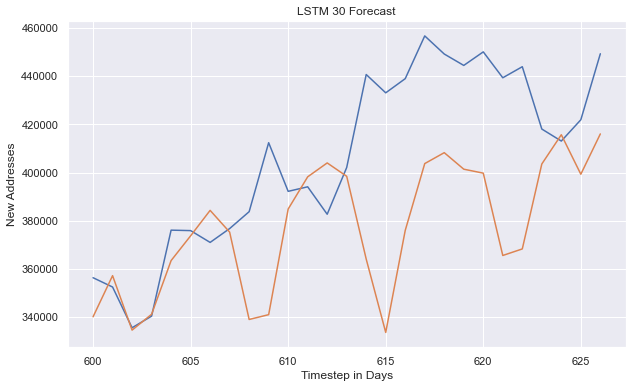

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

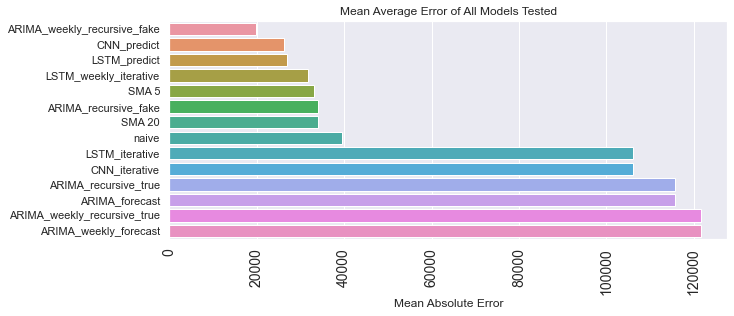

In [114]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
rnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    rnn_forecast.append(yhat)
    
rnn_forecast = np.array(rnn_forecast)
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['LSTM_weekly_iterative'] = lstm
model_mae_scores['LSTM_weekly_iterative'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

In [115]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape



window_size = 30
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(x_test.index, x_test, label="Actual")
plt.plot(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

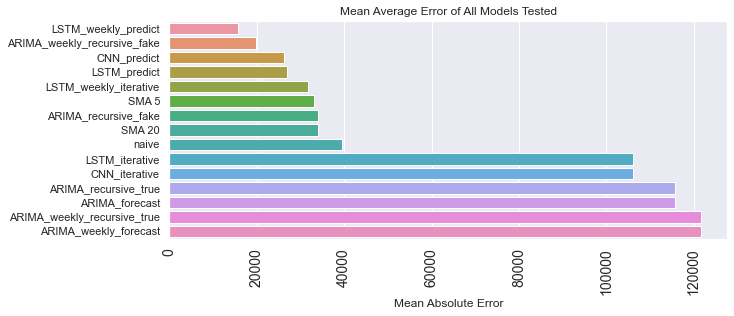

In [116]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['LSTM_weekly_predict'] = lstm
model_mae_scores['LSTM_weekly_predict'] = lstm
model_mae_scores



mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')


Epoch 1/100


/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 3s 26ms/step - loss: 0.0705 - mae: 0.2841 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0695 - mae: 0.2813 - lr: 1.0798e-04
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0682 - mae: 0.2778 - lr: 1.1659e-04
Epoch 4/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0665 - mae: 0.2738 - lr: 1.2589e-04
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0646 - mae: 0.2690 - lr: 1.3594e-04
Epoch 6/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0623 - mae: 0.2637 - lr: 1.4678e-04
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0594 - mae: 0.2572 - lr: 1.5849e-04
Epoch 8/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0560 - mae: 0.2497 - lr: 1.7113e-04
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0519 - mae: 0.2412 - lr: 1.8478e-04
Epoch 10/100
5/5 [====

5/5 [==============================] - 0s 25ms/step - loss: 0.0309 - mae: 0.2248 - lr: 0.0316
Epoch 77/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0309 - mae: 0.2249 - lr: 0.0341
Epoch 78/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0309 - mae: 0.2250 - lr: 0.0369
Epoch 79/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0309 - mae: 0.2249 - lr: 0.0398
Epoch 80/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0309 - mae: 0.2241 - lr: 0.0430
Epoch 81/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0310 - mae: 0.2253 - lr: 0.0464
Epoch 82/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0309 - mae: 0.2245 - lr: 0.0501
Epoch 83/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0309 - mae: 0.2240 - lr: 0.0541
Epoch 84/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0308 - mae: 0.2247 - lr: 0.0584
Epoch 85/100
5/5 [==============================] 

5/5 [==============================] - 4s 281ms/step - loss: 0.0389 - mae: 0.2031
Epoch 2/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0134 - mae: 0.1313WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 0.0130 - mae: 0.1290
Epoch 3/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0026 - mae: 0.0559WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 0.0026 - mae: 0.0558
Epoch 4/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0033 - mae: 0.0611WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 0.0033 - mae: 0.0608
Epoch 5/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0022 - mae: 0.0480WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 0.0022 - mae: 0.0474
Epoch 6/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0399WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0016 - mae: 0.0399
Epoch 7/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0013 - mae: 0.0329  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 0.0013 - mae: 0.0333
Epoch 8/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0042 - mae: 0.0681WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 0.0044 - mae: 0.0689
Epoch 9/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0046 - mae: 0.0654WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 0.0044 - mae: 0.0633
Epoch 10/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0326WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 0.0012 - mae: 0.0325
Epoch 11/500
4/5 [=======================>......] - ETA: 0s - loss: 8.2998e-04 - mae: 0.0265WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 8.6312e-04 - mae: 0.0271
Epoch 12/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0030 - mae: 0.0571WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0029 - mae: 0.0562
Epoch 13/500
4/5 [=======================>......] - ETA: 0s - loss: 9.2965e-04 - mae: 0.0286WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 9.3614e-04 - mae: 0.0287
Epoch 14/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0315   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 0.0012 - mae: 0.0329
Epoch 15/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0048 - mae: 0.0744WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0046 - mae: 0.0725
Epoch 16/500
5/5 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0368WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0014 - mae: 0.0368
Epoch 17/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0025 - mae: 0.0527WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 0.0025 - mae: 0.0517
Epoch 18/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0346WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 0.0012 - mae: 0.0349
Epoch 19/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0019 - mae: 0.0457WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 0.0018 - mae: 0.0445
Epoch 20/500
4/5 [=======================>......] - ETA: 0s - loss: 6.0024e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 5.8616e-04 - mae: 0.0226
Epoch 21/500
4/5 [=======================>......] - ETA: 0s - loss: 5.4318e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 5.5271e-04 - mae: 0.0220
Epoch 22/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0040 - mae: 0.0648WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 0.0038 - mae: 0.0626
Epoch 23/500
4/5 [=======================>......] - ETA: 0s - loss: 6.3583e-04 - mae: 0.0241WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 6.4082e-04 - mae: 0.0242
Epoch 24/500
4/5 [=======================>......] - ETA: 0s - loss: 8.0240e-04 - mae: 0.0277WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 8.5601e-04 - mae: 0.0285
Epoch 25/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0045 - mae: 0.0715WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 0.0043 - mae: 0.0694
Epoch 26/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0412WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0016 - mae: 0.0403
Epoch 27/500
4/5 [=======================>......] - ETA: 0s - loss: 5.5292e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 5.6551e-04 - mae: 0.0231
Epoch 28/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0330   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0011 - mae: 0.0335
Epoch 29/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0344  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0011 - mae: 0.0346
Epoch 30/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0015 - mae: 0.0405WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0016 - mae: 0.0407
Epoch 31/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0340WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 0.0011 - mae: 0.0340
Epoch 32/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0333WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 0.0011 - mae: 0.0332
Epoch 33/500
4/5 [=======================>......] - ETA: 0s - loss: 8.1261e-04 - mae: 0.0281WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 8.1222e-04 - mae: 0.0280
Epoch 34/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0346WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0012 - mae: 0.0349
Epoch 35/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0018 - mae: 0.0441WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 0.0018 - mae: 0.0435
Epoch 36/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0418WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 0.0016 - mae: 0.0409
Epoch 37/500
4/5 [=======================>......] - ETA: 0s - loss: 6.9616e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 6.9493e-04 - mae: 0.0254
Epoch 38/500
5/5 [==============================] - ETA: 0s - loss: 6.4291e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 6.4291e-04 - mae: 0.0243
Epoch 39/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0367WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 0.0012 - mae: 0.0368
Epoch 40/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0416WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 0.0016 - mae: 0.0415
Epoch 41/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0338WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 0.0011 - mae: 0.0337
Epoch 42/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0317WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 0.0010 - mae: 0.0315
Epoch 43/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0324    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 0.0010 - mae: 0.0320
Epoch 44/500
4/5 [=======================>......] - ETA: 0s - loss: 5.6332e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 5.6777e-04 - mae: 0.0227
Epoch 45/500
4/5 [=======================>......] - ETA: 0s - loss: 8.0655e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 8.1200e-04 - mae: 0.0277
Epoch 46/500
4/5 [=======================>......] - ETA: 0s - loss: 7.9899e-04 - mae: 0.0282WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 8.1164e-04 - mae: 0.0283
Epoch 47/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0015 - mae: 0.0399WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 103ms/step - loss: 0.0014 - mae: 0.0392
Epoch 48/500
4/5 [=======================>......] - ETA: 0s - loss: 6.1286e-04 - mae: 0.0236WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 6.0521e-04 - mae: 0.0235
Epoch 49/500
4/5 [=======================>......] - ETA: 0s - loss: 6.9106e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 6.7997e-04 - mae: 0.0251
Epoch 50/500
4/5 [=======================>......] - ETA: 0s - loss: 7.1025e-04 - mae: 0.0255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 7.2354e-04 - mae: 0.0257
Epoch 51/500
4/5 [=======================>......] - ETA: 0s - loss: 6.8877e-04 - mae: 0.0261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 7.0041e-04 - mae: 0.0263
Epoch 52/500
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0373WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 123ms/step - loss: 0.0013 - mae: 0.0373
Epoch 53/500
4/5 [=======================>......] - ETA: 0s - loss: 8.6690e-04 - mae: 0.0292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 8.5624e-04 - mae: 0.0290
Epoch 54/500
4/5 [=======================>......] - ETA: 0s - loss: 8.0562e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 8.1108e-04 - mae: 0.0277
Epoch 55/500
4/5 [=======================>......] - ETA: 0s - loss: 7.7917e-04 - mae: 0.0269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 8.0247e-04 - mae: 0.0275
Epoch 56/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0015 - mae: 0.0395WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 0.0015 - mae: 0.0398
Epoch 57/500
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0441WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 0.0017 - mae: 0.0441
Epoch 58/500
4/5 [=======================>......] - ETA: 0s - loss: 5.8377e-04 - mae: 0.0230WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 5.7493e-04 - mae: 0.0228
Epoch 59/500
5/5 [==============================] - ETA: 0s - loss: 5.0339e-04 - mae: 0.0210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 206ms/step - loss: 5.0339e-04 - mae: 0.0210
Epoch 60/500
5/5 [==============================] - ETA: 0s - loss: 4.9548e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 288ms/step - loss: 4.9548e-04 - mae: 0.0211
Epoch 61/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9609e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 3.8613e-04 - mae: 0.0185
Epoch 62/500
4/5 [=======================>......] - ETA: 0s - loss: 3.8040e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.7269e-04 - mae: 0.0176
Epoch 63/500
4/5 [=======================>......] - ETA: 0s - loss: 4.1686e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 4.2237e-04 - mae: 0.0187
Epoch 64/500
4/5 [=======================>......] - ETA: 0s - loss: 7.4260e-04 - mae: 0.0275WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 7.7309e-04 - mae: 0.0281
Epoch 65/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0023 - mae: 0.0525WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 0.0022 - mae: 0.0514
Epoch 66/500
5/5 [==============================] - ETA: 0s - loss: 7.0768e-04 - mae: 0.0255WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 7.0768e-04 - mae: 0.0255
Epoch 67/500
4/5 [=======================>......] - ETA: 0s - loss: 5.4972e-04 - mae: 0.0222WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 5.7352e-04 - mae: 0.0227
Epoch 68/500
4/5 [=======================>......] - ETA: 0s - loss: 8.1126e-04 - mae: 0.0277WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 8.1156e-04 - mae: 0.0277
Epoch 69/500
4/5 [=======================>......] - ETA: 0s - loss: 4.5850e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 4.4857e-04 - mae: 0.0203
Epoch 70/500
4/5 [=======================>......] - ETA: 0s - loss: 4.4900e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 101ms/step - loss: 4.6458e-04 - mae: 0.0198
Epoch 71/500
4/5 [=======================>......] - ETA: 0s - loss: 6.9596e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 7.1226e-04 - mae: 0.0257
Epoch 72/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0017 - mae: 0.0434WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 0.0017 - mae: 0.0434
Epoch 73/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0352WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 0.0012 - mae: 0.0354
Epoch 74/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0012 - mae: 0.0355WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 0.0012 - mae: 0.0353
Epoch 75/500
4/5 [=======================>......] - ETA: 0s - loss: 4.8593e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 100ms/step - loss: 4.8036e-04 - mae: 0.0207
Epoch 76/500
4/5 [=======================>......] - ETA: 0s - loss: 4.2150e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 4.2409e-04 - mae: 0.0190
Epoch 77/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6616e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.7188e-04 - mae: 0.0176
Epoch 78/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5703e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.5432e-04 - mae: 0.0170
Epoch 79/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4955e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.5806e-04 - mae: 0.0173
Epoch 80/500
4/5 [=======================>......] - ETA: 0s - loss: 4.8551e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 5.0254e-04 - mae: 0.0212
Epoch 81/500
5/5 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.0460WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 143ms/step - loss: 0.0017 - mae: 0.0460
Epoch 82/500
5/5 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0348WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 0.0013 - mae: 0.0348
Epoch 83/500
4/5 [=======================>......] - ETA: 0s - loss: 5.2284e-04 - mae: 0.0211WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 5.1783e-04 - mae: 0.0210
Epoch 84/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9927e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 3.9840e-04 - mae: 0.0185
Epoch 85/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5427e-04 - mae: 0.0172WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 3.5531e-04 - mae: 0.0172
Epoch 86/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5691e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 186ms/step - loss: 3.6828e-04 - mae: 0.0174
Epoch 87/500
4/5 [=======================>......] - ETA: 0s - loss: 4.9561e-04 - mae: 0.0205   WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1796s 188ms/step - loss: 4.9164e-04 - mae: 0.0204
Epoch 88/500
5/5 [==============================] - ETA: 0s - loss: 3.6096e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.6096e-04 - mae: 0.0179
Epoch 89/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5318e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.5449e-04 - mae: 0.0170
Epoch 90/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9605e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 125ms/step - loss: 3.9408e-04 - mae: 0.0181
Epoch 91/500
5/5 [==============================] - ETA: 0s - loss: 5.9838e-04 - mae: 0.0235WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 129ms/step - loss: 5.9838e-04 - mae: 0.0235
Epoch 92/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0013 - mae: 0.0374  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 0.0013 - mae: 0.0375
Epoch 93/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0018 - mae: 0.0447WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0017 - mae: 0.0436
Epoch 94/500
4/5 [=======================>......] - ETA: 0s - loss: 3.8508e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 3.8170e-04 - mae: 0.0185
Epoch 95/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6076e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.5559e-04 - mae: 0.0172
Epoch 96/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3874e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.4004e-04 - mae: 0.0168
Epoch 97/500
4/5 [=======================>......] - ETA: 0s - loss: 4.0184e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 4.1344e-04 - mae: 0.0186
Epoch 98/500
4/5 [=======================>......] - ETA: 0s - loss: 7.6918e-04 - mae: 0.0274WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 125ms/step - loss: 8.1319e-04 - mae: 0.0281
Epoch 99/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0016 - mae: 0.0408WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 0.0015 - mae: 0.0395
Epoch 100/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5858e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 3.6563e-04 - mae: 0.0176
Epoch 101/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4264e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 3.4172e-04 - mae: 0.0169
Epoch 102/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7428e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.7703e-04 - mae: 0.0177
Epoch 103/500
5/5 [==============================] - ETA: 0s - loss: 4.2660e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 149ms/step - loss: 4.2660e-04 - mae: 0.0188
Epoch 104/500
5/5 [==============================] - ETA: 0s - loss: 8.8058e-04 - mae: 0.0291WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 164ms/step - loss: 8.8058e-04 - mae: 0.0291
Epoch 105/500
5/5 [==============================] - ETA: 0s - loss: 4.9556e-04 - mae: 0.0220WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 184ms/step - loss: 4.9556e-04 - mae: 0.0220
Epoch 106/500
5/5 [==============================] - ETA: 0s - loss: 5.4365e-04 - mae: 0.0219WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 182ms/step - loss: 5.4365e-04 - mae: 0.0219
Epoch 107/500
5/5 [==============================] - ETA: 0s - loss: 7.6401e-04 - mae: 0.0266WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 171ms/step - loss: 7.6401e-04 - mae: 0.0266
Epoch 108/500
5/5 [==============================] - ETA: 0s - loss: 9.6380e-04 - mae: 0.0313WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 183ms/step - loss: 9.6380e-04 - mae: 0.0313
Epoch 109/500
5/5 [==============================] - ETA: 0s - loss: 4.2604e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 172ms/step - loss: 4.2604e-04 - mae: 0.0195
Epoch 110/500
5/5 [==============================] - ETA: 0s - loss: 4.8240e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 178ms/step - loss: 4.8240e-04 - mae: 0.0203
Epoch 111/500
5/5 [==============================] - ETA: 0s - loss: 6.6500e-04 - mae: 0.0242WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 177ms/step - loss: 6.6500e-04 - mae: 0.0242
Epoch 112/500
5/5 [==============================] - ETA: 0s - loss: 5.5659e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 164ms/step - loss: 5.5659e-04 - mae: 0.0225
Epoch 113/500
5/5 [==============================] - ETA: 0s - loss: 3.6141e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 237ms/step - loss: 3.6141e-04 - mae: 0.0174
Epoch 114/500
5/5 [==============================] - ETA: 0s - loss: 5.3540e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 210ms/step - loss: 5.3540e-04 - mae: 0.0216
Epoch 115/500
5/5 [==============================] - ETA: 0s - loss: 3.4834e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 175ms/step - loss: 3.4834e-04 - mae: 0.0179
Epoch 116/500
5/5 [==============================] - ETA: 0s - loss: 3.2417e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 185ms/step - loss: 3.2417e-04 - mae: 0.0163
Epoch 117/500
5/5 [==============================] - ETA: 0s - loss: 4.9468e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 180ms/step - loss: 4.9468e-04 - mae: 0.0202
Epoch 118/500
5/5 [==============================] - ETA: 0s - loss: 6.0229e-04 - mae: 0.0237WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 182ms/step - loss: 6.0229e-04 - mae: 0.0237
Epoch 119/500
5/5 [==============================] - ETA: 0s - loss: 3.3127e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 160ms/step - loss: 3.3127e-04 - mae: 0.0171
Epoch 120/500
5/5 [==============================] - ETA: 0s - loss: 3.4021e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 186ms/step - loss: 3.4021e-04 - mae: 0.0166
Epoch 121/500
5/5 [==============================] - ETA: 0s - loss: 4.0253e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 162ms/step - loss: 4.0253e-04 - mae: 0.0182
Epoch 122/500
5/5 [==============================] - ETA: 0s - loss: 4.6239e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 158ms/step - loss: 4.6239e-04 - mae: 0.0197
Epoch 123/500
5/5 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0361  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 154ms/step - loss: 0.0012 - mae: 0.0361
Epoch 124/500
5/5 [==============================] - ETA: 0s - loss: 6.8171e-04 - mae: 0.0258WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 158ms/step - loss: 6.8171e-04 - mae: 0.0258
Epoch 125/500
5/5 [==============================] - ETA: 0s - loss: 5.7654e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 145ms/step - loss: 5.7654e-04 - mae: 0.0224
Epoch 126/500
5/5 [==============================] - ETA: 0s - loss: 9.7675e-04 - mae: 0.0298WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 144ms/step - loss: 9.7675e-04 - mae: 0.0298
Epoch 127/500
5/5 [==============================] - ETA: 0s - loss: 9.1669e-04 - mae: 0.0295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 151ms/step - loss: 9.1669e-04 - mae: 0.0295
Epoch 128/500
5/5 [==============================] - ETA: 0s - loss: 6.1391e-04 - mae: 0.0250WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 152ms/step - loss: 6.1391e-04 - mae: 0.0250
Epoch 129/500
5/5 [==============================] - ETA: 0s - loss: 7.7542e-04 - mae: 0.0270WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 156ms/step - loss: 7.7542e-04 - mae: 0.0270
Epoch 130/500
5/5 [==============================] - ETA: 0s - loss: 9.2305e-04 - mae: 0.0294WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 153ms/step - loss: 9.2305e-04 - mae: 0.0294
Epoch 131/500
5/5 [==============================] - ETA: 0s - loss: 5.0612e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 149ms/step - loss: 5.0612e-04 - mae: 0.0213
Epoch 132/500
5/5 [==============================] - ETA: 0s - loss: 4.1859e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 150ms/step - loss: 4.1859e-04 - mae: 0.0186
Epoch 133/500
5/5 [==============================] - ETA: 0s - loss: 3.6284e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 148ms/step - loss: 3.6284e-04 - mae: 0.0175
Epoch 134/500
5/5 [==============================] - ETA: 0s - loss: 4.4035e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 150ms/step - loss: 4.4035e-04 - mae: 0.0194
Epoch 135/500
5/5 [==============================] - ETA: 0s - loss: 5.3680e-04 - mae: 0.0218WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 162ms/step - loss: 5.3680e-04 - mae: 0.0218
Epoch 136/500
5/5 [==============================] - ETA: 0s - loss: 5.7880e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 150ms/step - loss: 5.7880e-04 - mae: 0.0227
Epoch 137/500
5/5 [==============================] - ETA: 0s - loss: 7.3298e-04 - mae: 0.0263WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 150ms/step - loss: 7.3298e-04 - mae: 0.0263
Epoch 138/500
5/5 [==============================] - ETA: 0s - loss: 3.5675e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 158ms/step - loss: 3.5675e-04 - mae: 0.0176
Epoch 139/500
5/5 [==============================] - ETA: 0s - loss: 4.5327e-04 - mae: 0.0196  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 560s 140s/step - loss: 4.5327e-04 - mae: 0.0196
Epoch 140/500
5/5 [==============================] - ETA: 0s - loss: 4.6489e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 3s 602ms/step - loss: 4.6489e-04 - mae: 0.0199
Epoch 141/500
5/5 [==============================] - ETA: 0s - loss: 4.1796e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 196ms/step - loss: 4.1796e-04 - mae: 0.0188
Epoch 142/500
5/5 [==============================] - ETA: 0s - loss: 4.6388e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 220ms/step - loss: 4.6388e-04 - mae: 0.0201
Epoch 143/500
5/5 [==============================] - ETA: 0s - loss: 9.9013e-04 - mae: 0.0314WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 155ms/step - loss: 9.9013e-04 - mae: 0.0314
Epoch 144/500
5/5 [==============================] - ETA: 0s - loss: 5.1850e-04 - mae: 0.0240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 142ms/step - loss: 5.1850e-04 - mae: 0.0240
Epoch 145/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9860e-04 - mae: 0.0186WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 154ms/step - loss: 4.0645e-04 - mae: 0.0188
Epoch 146/500
5/5 [==============================] - ETA: 0s - loss: 5.8094e-04 - mae: 0.0225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 162ms/step - loss: 5.8094e-04 - mae: 0.0225
Epoch 147/500
5/5 [==============================] - ETA: 0s - loss: 4.7584e-04 - mae: 0.0202WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 175ms/step - loss: 4.7584e-04 - mae: 0.0202
Epoch 148/500
4/5 [=======================>......] - ETA: 0s - loss: 4.3142e-04 - mae: 0.0193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 156ms/step - loss: 4.2373e-04 - mae: 0.0191
Epoch 149/500
5/5 [==============================] - ETA: 0s - loss: 3.4769e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 199ms/step - loss: 3.4769e-04 - mae: 0.0170
Epoch 150/500
5/5 [==============================] - ETA: 0s - loss: 4.9428e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 165ms/step - loss: 4.9428e-04 - mae: 0.0209
Epoch 151/500
5/5 [==============================] - ETA: 0s - loss: 5.1379e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 164ms/step - loss: 5.1379e-04 - mae: 0.0214
Epoch 152/500
5/5 [==============================] - ETA: 0s - loss: 3.2196e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 149ms/step - loss: 3.2196e-04 - mae: 0.0171
Epoch 153/500
5/5 [==============================] - ETA: 0s - loss: 3.2172e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 148ms/step - loss: 3.2172e-04 - mae: 0.0162
Epoch 154/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2561e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 133ms/step - loss: 3.2290e-04 - mae: 0.0164
Epoch 155/500
5/5 [==============================] - ETA: 0s - loss: 3.3717e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 222ms/step - loss: 3.3717e-04 - mae: 0.0168
Epoch 156/500
5/5 [==============================] - ETA: 0s - loss: 3.8077e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 173ms/step - loss: 3.8077e-04 - mae: 0.0181
Epoch 157/500
5/5 [==============================] - ETA: 0s - loss: 4.3534e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 162ms/step - loss: 4.3534e-04 - mae: 0.0195
Epoch 158/500
5/5 [==============================] - ETA: 0s - loss: 4.9543e-04 - mae: 0.0213WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 146ms/step - loss: 4.9543e-04 - mae: 0.0213
Epoch 159/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0327  WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 136ms/step - loss: 9.9869e-04 - mae: 0.0321
Epoch 160/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4652e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 132ms/step - loss: 3.4491e-04 - mae: 0.0175
Epoch 161/500
5/5 [==============================] - ETA: 0s - loss: 2.8840e-04 - mae: 0.0156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 130ms/step - loss: 2.8840e-04 - mae: 0.0156
Epoch 162/500
5/5 [==============================] - ETA: 0s - loss: 2.8451e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 134ms/step - loss: 2.8451e-04 - mae: 0.0153
Epoch 163/500
5/5 [==============================] - ETA: 0s - loss: 3.2031e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 126ms/step - loss: 3.2031e-04 - mae: 0.0163
Epoch 164/500
5/5 [==============================] - ETA: 0s - loss: 4.5400e-04 - mae: 0.0200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 123ms/step - loss: 4.5400e-04 - mae: 0.0200
Epoch 165/500
4/5 [=======================>......] - ETA: 0s - loss: 5.6195e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 129ms/step - loss: 5.6427e-04 - mae: 0.0231
Epoch 166/500
4/5 [=======================>......] - ETA: 0s - loss: 7.3839e-04 - mae: 0.0262WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 7.2538e-04 - mae: 0.0260
Epoch 167/500
4/5 [=======================>......] - ETA: 0s - loss: 5.3753e-04 - mae: 0.0224WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 128ms/step - loss: 5.5371e-04 - mae: 0.0226
Epoch 168/500
4/5 [=======================>......] - ETA: 0s - loss: 9.7241e-04 - mae: 0.0309WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 9.6739e-04 - mae: 0.0308
Epoch 169/500
4/5 [=======================>......] - ETA: 0s - loss: 8.1481e-04 - mae: 0.0279WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 8.1052e-04 - mae: 0.0278
Epoch 170/500
4/5 [=======================>......] - ETA: 0s - loss: 6.4580e-04 - mae: 0.0246WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 125ms/step - loss: 6.2679e-04 - mae: 0.0242
Epoch 171/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4230e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.3852e-04 - mae: 0.0173
Epoch 172/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1174e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 3.0958e-04 - mae: 0.0161
Epoch 173/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9618e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 4.0268e-04 - mae: 0.0184
Epoch 174/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9041e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 4.0682e-04 - mae: 0.0191
Epoch 175/500
4/5 [=======================>......] - ETA: 0s - loss: 9.8157e-04 - mae: 0.0314WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 9.6624e-04 - mae: 0.0313
Epoch 176/500
4/5 [=======================>......] - ETA: 0s - loss: 5.4093e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 5.3835e-04 - mae: 0.0227
Epoch 177/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6814e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.6991e-04 - mae: 0.0177
Epoch 178/500
4/5 [=======================>......] - ETA: 0s - loss: 5.2119e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 5.1629e-04 - mae: 0.0213
Epoch 179/500
4/5 [=======================>......] - ETA: 0s - loss: 4.4266e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 4.4050e-04 - mae: 0.0196
Epoch 180/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2345e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.2523e-04 - mae: 0.0171
Epoch 181/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1702e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.1849e-04 - mae: 0.0165
Epoch 182/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3398e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.3915e-04 - mae: 0.0168
Epoch 183/500
4/5 [=======================>......] - ETA: 0s - loss: 6.4713e-04 - mae: 0.0243WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 6.5362e-04 - mae: 0.0245
Epoch 184/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5129e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 3.5357e-04 - mae: 0.0185
Epoch 185/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6097e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 3.6116e-04 - mae: 0.0175
Epoch 186/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3524e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 3.3522e-04 - mae: 0.0169
Epoch 187/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0079e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 3.0211e-04 - mae: 0.0159
Epoch 188/500
4/5 [=======================>......] - ETA: 0s - loss: 4.0465e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 4.1979e-04 - mae: 0.0189
Epoch 189/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0011 - mae: 0.0350WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 0.0011 - mae: 0.0348
Epoch 190/500
4/5 [=======================>......] - ETA: 0s - loss: 4.0470e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 4.0706e-04 - mae: 0.0203
Epoch 191/500
4/5 [=======================>......] - ETA: 0s - loss: 4.6318e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 4.7516e-04 - mae: 0.0203
Epoch 192/500
4/5 [=======================>......] - ETA: 0s - loss: 0.0010 - mae: 0.0309    WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 9.8189e-04 - mae: 0.0306
Epoch 193/500
4/5 [=======================>......] - ETA: 0s - loss: 4.0994e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 4.0760e-04 - mae: 0.0195
Epoch 194/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7696e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.7186e-04 - mae: 0.0180
Epoch 195/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8115e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 2.8374e-04 - mae: 0.0155
Epoch 196/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0737e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.0858e-04 - mae: 0.0162
Epoch 197/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3225e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.3428e-04 - mae: 0.0168
Epoch 198/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5315e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.5903e-04 - mae: 0.0179
Epoch 199/500
4/5 [=======================>......] - ETA: 0s - loss: 5.2039e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 5.2145e-04 - mae: 0.0212
Epoch 200/500
5/5 [==============================] - ETA: 0s - loss: 4.5850e-04 - mae: 0.0206WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 124ms/step - loss: 4.5850e-04 - mae: 0.0206
Epoch 201/500
5/5 [==============================] - ETA: 0s - loss: 3.0678e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 125ms/step - loss: 3.0678e-04 - mae: 0.0161
Epoch 202/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9187e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 2.9767e-04 - mae: 0.0157
Epoch 203/500
4/5 [=======================>......] - ETA: 0s - loss: 4.8934e-04 - mae: 0.0208WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 4.9456e-04 - mae: 0.0210
Epoch 204/500
4/5 [=======================>......] - ETA: 0s - loss: 6.4330e-04 - mae: 0.0251WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 6.4078e-04 - mae: 0.0251
Epoch 205/500
4/5 [=======================>......] - ETA: 0s - loss: 5.6194e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 5.6317e-04 - mae: 0.0228
Epoch 206/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7421e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.7551e-04 - mae: 0.0180
Epoch 207/500
4/5 [=======================>......] - ETA: 0s - loss: 4.4268e-04 - mae: 0.0196WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 4.4669e-04 - mae: 0.0197
Epoch 208/500
4/5 [=======================>......] - ETA: 0s - loss: 4.7166e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 4.6939e-04 - mae: 0.0204
Epoch 209/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4854e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.5846e-04 - mae: 0.0176
Epoch 210/500
4/5 [=======================>......] - ETA: 0s - loss: 5.3605e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 5.3203e-04 - mae: 0.0220
Epoch 211/500
5/5 [==============================] - ETA: 0s - loss: 4.1184e-04 - mae: 0.0197WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 4.1184e-04 - mae: 0.0197
Epoch 212/500
4/5 [=======================>......] - ETA: 0s - loss: 7.3408e-04 - mae: 0.0261WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 7.2862e-04 - mae: 0.0262
Epoch 213/500
4/5 [=======================>......] - ETA: 0s - loss: 7.0367e-04 - mae: 0.0264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 6.8999e-04 - mae: 0.0262
Epoch 214/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9256e-04 - mae: 0.0189WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 3.9622e-04 - mae: 0.0190
Epoch 215/500
4/5 [=======================>......] - ETA: 0s - loss: 4.9230e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 4.8658e-04 - mae: 0.0207
Epoch 216/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0489e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 3.0188e-04 - mae: 0.0162
Epoch 217/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1197e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.0762e-04 - mae: 0.0161
Epoch 218/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6589e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.6990e-04 - mae: 0.0154
Epoch 219/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3084e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.4440e-04 - mae: 0.0168
Epoch 220/500
5/5 [==============================] - ETA: 0s - loss: 5.2512e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 127ms/step - loss: 5.2512e-04 - mae: 0.0228
Epoch 221/500
4/5 [=======================>......] - ETA: 0s - loss: 4.0199e-04 - mae: 0.0199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 124ms/step - loss: 3.9945e-04 - mae: 0.0198
Epoch 222/500
5/5 [==============================] - ETA: 0s - loss: 4.3456e-04 - mae: 0.0192WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 4.3456e-04 - mae: 0.0192
Epoch 223/500
4/5 [=======================>......] - ETA: 0s - loss: 4.7093e-04 - mae: 0.0204WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 4.7168e-04 - mae: 0.0205
Epoch 224/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7907e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.7276e-04 - mae: 0.0185
Epoch 225/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5422e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.5392e-04 - mae: 0.0147
Epoch 226/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6318e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.6168e-04 - mae: 0.0148
Epoch 227/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8307e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.8079e-04 - mae: 0.0156
Epoch 228/500
5/5 [==============================] - ETA: 0s - loss: 2.5676e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 136ms/step - loss: 2.5676e-04 - mae: 0.0153
Epoch 229/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8652e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.8930e-04 - mae: 0.0156
Epoch 230/500
4/5 [=======================>......] - ETA: 0s - loss: 3.9068e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.9566e-04 - mae: 0.0186
Epoch 231/500
4/5 [=======================>......] - ETA: 0s - loss: 7.8046e-04 - mae: 0.0278WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 7.7776e-04 - mae: 0.0278
Epoch 232/500
4/5 [=======================>......] - ETA: 0s - loss: 6.9271e-04 - mae: 0.0268WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 6.9252e-04 - mae: 0.0267
Epoch 233/500
4/5 [=======================>......] - ETA: 0s - loss: 5.2826e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 5.2101e-04 - mae: 0.0215
Epoch 234/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0719e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 3.0977e-04 - mae: 0.0165
Epoch 235/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4540e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.4009e-04 - mae: 0.0169
Epoch 236/500
5/5 [==============================] - ETA: 0s - loss: 2.5780e-04 - mae: 0.0150WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.5780e-04 - mae: 0.0150
Epoch 237/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3382e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.3635e-04 - mae: 0.0142
Epoch 238/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7362e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 2.7761e-04 - mae: 0.0153
Epoch 239/500
4/5 [=======================>......] - ETA: 0s - loss: 4.6650e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 4.6619e-04 - mae: 0.0204
Epoch 240/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0489e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.0575e-04 - mae: 0.0178
Epoch 241/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6230e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.6136e-04 - mae: 0.0175
Epoch 242/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1320e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.1123e-04 - mae: 0.0163
Epoch 243/500
5/5 [==============================] - ETA: 0s - loss: 2.9027e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 2.9027e-04 - mae: 0.0159
Epoch 244/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6109e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.6245e-04 - mae: 0.0175
Epoch 245/500
4/5 [=======================>......] - ETA: 0s - loss: 4.4119e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 4.4406e-04 - mae: 0.0203
Epoch 246/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7478e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 130ms/step - loss: 3.7599e-04 - mae: 0.0183
Epoch 247/500
5/5 [==============================] - ETA: 0s - loss: 4.3100e-04 - mae: 0.0194WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 132ms/step - loss: 4.3100e-04 - mae: 0.0194
Epoch 248/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4332e-04 - mae: 0.0177WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 130ms/step - loss: 3.4763e-04 - mae: 0.0179
Epoch 249/500
4/5 [=======================>......] - ETA: 0s - loss: 5.1488e-04 - mae: 0.0217WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 5.1057e-04 - mae: 0.0216
Epoch 250/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8194e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 2.8416e-04 - mae: 0.0165
Epoch 251/500
4/5 [=======================>......] - ETA: 0s - loss: 4.5857e-04 - mae: 0.0201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 4.5785e-04 - mae: 0.0201
Epoch 252/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3552e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.3464e-04 - mae: 0.0178
Epoch 253/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1580e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.1643e-04 - mae: 0.0165
Epoch 254/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9779e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.9494e-04 - mae: 0.0161
Epoch 255/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9522e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 131ms/step - loss: 2.9627e-04 - mae: 0.0161
Epoch 256/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8154e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 128ms/step - loss: 2.8796e-04 - mae: 0.0161
Epoch 257/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5782e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 3.6084e-04 - mae: 0.0175
Epoch 258/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6079e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.5950e-04 - mae: 0.0182
Epoch 259/500
4/5 [=======================>......] - ETA: 0s - loss: 3.8749e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.7483e-04 - mae: 0.0183
Epoch 260/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2786e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.3173e-04 - mae: 0.0145
Epoch 261/500
5/5 [==============================] - ETA: 0s - loss: 2.1999e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 169ms/step - loss: 2.1999e-04 - mae: 0.0135
Epoch 262/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1850e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.1861e-04 - mae: 0.0134
Epoch 263/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1826e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 2.1646e-04 - mae: 0.0134
Epoch 264/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3983e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.4136e-04 - mae: 0.0142
Epoch 265/500
5/5 [==============================] - ETA: 0s - loss: 2.8142e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 2.8142e-04 - mae: 0.0160
Epoch 266/500
4/5 [=======================>......] - ETA: 0s - loss: 4.7243e-04 - mae: 0.0203WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 4.7928e-04 - mae: 0.0206
Epoch 267/500
4/5 [=======================>......] - ETA: 0s - loss: 8.2574e-04 - mae: 0.0295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 8.0673e-04 - mae: 0.0291
Epoch 268/500
4/5 [=======================>......] - ETA: 0s - loss: 4.6549e-04 - mae: 0.0209WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 4.5903e-04 - mae: 0.0207
Epoch 269/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1935e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.2044e-04 - mae: 0.0167
Epoch 270/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7031e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.7150e-04 - mae: 0.0152
Epoch 271/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7711e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.7278e-04 - mae: 0.0152
Epoch 272/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1756e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.1797e-04 - mae: 0.0137
Epoch 273/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4173e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.4145e-04 - mae: 0.0141
Epoch 274/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6734e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.6937e-04 - mae: 0.0180
Epoch 275/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2925e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 3.2673e-04 - mae: 0.0180
Epoch 276/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7101e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 2.6921e-04 - mae: 0.0152
Epoch 277/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6131e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.6287e-04 - mae: 0.0148
Epoch 278/500
5/5 [==============================] - ETA: 0s - loss: 3.2281e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.2281e-04 - mae: 0.0168
Epoch 279/500
5/5 [==============================] - ETA: 0s - loss: 4.6999e-04 - mae: 0.0212WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 4.6999e-04 - mae: 0.0212
Epoch 280/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1515e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.1306e-04 - mae: 0.0169
Epoch 281/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3612e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.3680e-04 - mae: 0.0141
Epoch 282/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0481e-04 - mae: 0.0162WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 3.2206e-04 - mae: 0.0167
Epoch 283/500
4/5 [=======================>......] - ETA: 0s - loss: 7.0012e-04 - mae: 0.0264WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 7.2769e-04 - mae: 0.0268
Epoch 284/500
4/5 [=======================>......] - ETA: 0s - loss: 7.7158e-04 - mae: 0.0276WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 7.5254e-04 - mae: 0.0273
Epoch 285/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2292e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.1864e-04 - mae: 0.0167
Epoch 286/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2933e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.3124e-04 - mae: 0.0139
Epoch 287/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3569e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 2.3412e-04 - mae: 0.0141
Epoch 288/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1437e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.1702e-04 - mae: 0.0135
Epoch 289/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3130e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.2885e-04 - mae: 0.0138
Epoch 290/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1124e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.1106e-04 - mae: 0.0136
Epoch 291/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5202e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.5568e-04 - mae: 0.0147
Epoch 292/500
4/5 [=======================>......] - ETA: 0s - loss: 6.4418e-04 - mae: 0.0245WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 6.4145e-04 - mae: 0.0246
Epoch 293/500
5/5 [==============================] - ETA: 0s - loss: 6.2566e-04 - mae: 0.0253WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 169ms/step - loss: 6.2566e-04 - mae: 0.0253
Epoch 294/500
5/5 [==============================] - ETA: 0s - loss: 3.0557e-04 - mae: 0.0166WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 3.0557e-04 - mae: 0.0166
Epoch 295/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7998e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.8552e-04 - mae: 0.0156
Epoch 296/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7960e-04 - mae: 0.0182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.7115e-04 - mae: 0.0180
Epoch 297/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5915e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.6015e-04 - mae: 0.0153
Epoch 298/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7466e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 2.7699e-04 - mae: 0.0153
Epoch 299/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4419e-04 - mae: 0.0174WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.4424e-04 - mae: 0.0174
Epoch 300/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1878e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.1967e-04 - mae: 0.0169
Epoch 301/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7733e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.8078e-04 - mae: 0.0185
Epoch 302/500
4/5 [=======================>......] - ETA: 0s - loss: 5.6243e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 5.5798e-04 - mae: 0.0229
Epoch 303/500
4/5 [=======================>......] - ETA: 0s - loss: 4.8488e-04 - mae: 0.0216WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 4.8076e-04 - mae: 0.0215
Epoch 304/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1971e-04 - mae: 0.0171WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.2033e-04 - mae: 0.0171
Epoch 305/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1761e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.1383e-04 - mae: 0.0163
Epoch 306/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5787e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.5974e-04 - mae: 0.0149
Epoch 307/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6677e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.7110e-04 - mae: 0.0154
Epoch 308/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3922e-04 - mae: 0.0173WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.4155e-04 - mae: 0.0174
Epoch 309/500
4/5 [=======================>......] - ETA: 0s - loss: 5.5290e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 5.4699e-04 - mae: 0.0227
Epoch 310/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8298e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 2.7920e-04 - mae: 0.0164
Epoch 311/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1428e-04 - mae: 0.0134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.1637e-04 - mae: 0.0135
Epoch 312/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6246e-04 - mae: 0.0148WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.6312e-04 - mae: 0.0149
Epoch 313/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9341e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 2.9335e-04 - mae: 0.0160
Epoch 314/500
4/5 [=======================>......] - ETA: 0s - loss: 4.1541e-04 - mae: 0.0195WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 4.0867e-04 - mae: 0.0193
Epoch 315/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9856e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.0373e-04 - mae: 0.0168
Epoch 316/500
4/5 [=======================>......] - ETA: 0s - loss: 9.0585e-04 - mae: 0.0297WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 8.7667e-04 - mae: 0.0292
Epoch 317/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6080e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.5520e-04 - mae: 0.0186
Epoch 318/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2664e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.2519e-04 - mae: 0.0140
Epoch 319/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1422e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 2.1404e-04 - mae: 0.0134
Epoch 320/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9857e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.0013e-04 - mae: 0.0130
Epoch 321/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0358e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.0166e-04 - mae: 0.0130
Epoch 322/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0039e-04 - mae: 0.0129WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.0202e-04 - mae: 0.0129
Epoch 323/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1909e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.2179e-04 - mae: 0.0137
Epoch 324/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4249e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.4287e-04 - mae: 0.0145
Epoch 325/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4650e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 2.3933e-04 - mae: 0.0142
Epoch 326/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9778e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 132ms/step - loss: 2.0018e-04 - mae: 0.0132
Epoch 327/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0987e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.1179e-04 - mae: 0.0133
Epoch 328/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6356e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.6418e-04 - mae: 0.0152
Epoch 329/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0535e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.1133e-04 - mae: 0.0165
Epoch 330/500
4/5 [=======================>......] - ETA: 0s - loss: 5.4664e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 5.4555e-04 - mae: 0.0232
Epoch 331/500
4/5 [=======================>......] - ETA: 0s - loss: 6.4664e-04 - mae: 0.0258WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 6.4868e-04 - mae: 0.0257
Epoch 332/500
4/5 [=======================>......] - ETA: 0s - loss: 5.7014e-04 - mae: 0.0228WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 5.5278e-04 - mae: 0.0225
Epoch 333/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5267e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 2.5453e-04 - mae: 0.0148
Epoch 334/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7104e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.7312e-04 - mae: 0.0153
Epoch 335/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2712e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 3.3056e-04 - mae: 0.0169
Epoch 336/500
4/5 [=======================>......] - ETA: 0s - loss: 4.7724e-04 - mae: 0.0207WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 4.6616e-04 - mae: 0.0206
Epoch 337/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7334e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.6981e-04 - mae: 0.0152
Epoch 338/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9860e-04 - mae: 0.0130WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 1.9696e-04 - mae: 0.0129
Epoch 339/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9631e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 1.9955e-04 - mae: 0.0128
Epoch 340/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2729e-04 - mae: 0.0168WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.2245e-04 - mae: 0.0167
Epoch 341/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4716e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.4645e-04 - mae: 0.0152
Epoch 342/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1400e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 2.1326e-04 - mae: 0.0137
Epoch 343/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0556e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 103ms/step - loss: 2.0466e-04 - mae: 0.0131
Epoch 344/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2607e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.2821e-04 - mae: 0.0141
Epoch 345/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0024e-04 - mae: 0.0159WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 3.0752e-04 - mae: 0.0161
Epoch 346/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9109e-04 - mae: 0.0165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 2.9325e-04 - mae: 0.0166
Epoch 347/500
4/5 [=======================>......] - ETA: 0s - loss: 5.6202e-04 - mae: 0.0229WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 5.7783e-04 - mae: 0.0232
Epoch 348/500
4/5 [=======================>......] - ETA: 0s - loss: 5.2487e-04 - mae: 0.0231WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 5.2057e-04 - mae: 0.0230
Epoch 349/500
4/5 [=======================>......] - ETA: 0s - loss: 4.7762e-04 - mae: 0.0214WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 4.6702e-04 - mae: 0.0210
Epoch 350/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3730e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.4168e-04 - mae: 0.0147
Epoch 351/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3942e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 102ms/step - loss: 2.3925e-04 - mae: 0.0144
Epoch 352/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2603e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.2491e-04 - mae: 0.0139
Epoch 353/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1930e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.1982e-04 - mae: 0.0138
Epoch 354/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4187e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 2.4520e-04 - mae: 0.0146
Epoch 355/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4769e-04 - mae: 0.0145WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.5191e-04 - mae: 0.0146
Epoch 356/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6880e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 104ms/step - loss: 3.6059e-04 - mae: 0.0181
Epoch 357/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2164e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.2258e-04 - mae: 0.0141
Epoch 358/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8019e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 103ms/step - loss: 2.8002e-04 - mae: 0.0155
Epoch 359/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1422e-04 - mae: 0.0164WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.1770e-04 - mae: 0.0166
Epoch 360/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7284e-04 - mae: 0.0184WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.6376e-04 - mae: 0.0182
Epoch 361/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2393e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 2.2078e-04 - mae: 0.0142
Epoch 362/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9266e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 1.9446e-04 - mae: 0.0129
Epoch 363/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0592e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.0901e-04 - mae: 0.0133
Epoch 364/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6827e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.7268e-04 - mae: 0.0153
Epoch 365/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9339e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.9799e-04 - mae: 0.0159
Epoch 366/500
4/5 [=======================>......] - ETA: 0s - loss: 3.7712e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.6959e-04 - mae: 0.0182
Epoch 367/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5723e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.5075e-04 - mae: 0.0150
Epoch 368/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8167e-04 - mae: 0.0124WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 1.7890e-04 - mae: 0.0123
Epoch 369/500
5/5 [==============================] - ETA: 0s - loss: 1.8553e-04 - mae: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 1.8553e-04 - mae: 0.0123
Epoch 370/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1944e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.2071e-04 - mae: 0.0137
Epoch 371/500
4/5 [=======================>......] - ETA: 0s - loss: 2.8901e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 2.9259e-04 - mae: 0.0163
Epoch 372/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5761e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 3.5634e-04 - mae: 0.0181
Epoch 373/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2150e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.2470e-04 - mae: 0.0171
Epoch 374/500
4/5 [=======================>......] - ETA: 0s - loss: 4.5973e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 4.4766e-04 - mae: 0.0203
Epoch 375/500
4/5 [=======================>......] - ETA: 0s - loss: 3.1849e-04 - mae: 0.0167WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 3.1598e-04 - mae: 0.0166
Epoch 376/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5883e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.6056e-04 - mae: 0.0154
Epoch 377/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4691e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 2.4401e-04 - mae: 0.0145
Epoch 378/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0742e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.0716e-04 - mae: 0.0132
Epoch 379/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0148e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.0434e-04 - mae: 0.0132
Epoch 380/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3575e-04 - mae: 0.0142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.3354e-04 - mae: 0.0141
Epoch 381/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9496e-04 - mae: 0.0132WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.9521e-04 - mae: 0.0132
Epoch 382/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4372e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 2.4464e-04 - mae: 0.0145
Epoch 383/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3808e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.3881e-04 - mae: 0.0145
Epoch 384/500
5/5 [==============================] - ETA: 0s - loss: 2.6912e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.6912e-04 - mae: 0.0155
Epoch 385/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5640e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.5854e-04 - mae: 0.0183
Epoch 386/500
4/5 [=======================>......] - ETA: 0s - loss: 3.2933e-04 - mae: 0.0175WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.3094e-04 - mae: 0.0175
Epoch 387/500
4/5 [=======================>......] - ETA: 0s - loss: 4.2045e-04 - mae: 0.0191WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 4.1795e-04 - mae: 0.0190
Epoch 388/500
5/5 [==============================] - ETA: 0s - loss: 2.5052e-04 - mae: 0.0152WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.5052e-04 - mae: 0.0152
Epoch 389/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4034e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.3874e-04 - mae: 0.0146
Epoch 390/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0530e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.0407e-04 - mae: 0.0138
Epoch 391/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7949e-04 - mae: 0.0123WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.7595e-04 - mae: 0.0120
Epoch 392/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6417e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 1.6441e-04 - mae: 0.0116
Epoch 393/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7221e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 1.6991e-04 - mae: 0.0118
Epoch 394/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7150e-04 - mae: 0.0117WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 1.7232e-04 - mae: 0.0118
Epoch 395/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9596e-04 - mae: 0.0130WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.9658e-04 - mae: 0.0130
Epoch 396/500
5/5 [==============================] - ETA: 0s - loss: 2.4469e-04 - mae: 0.0149WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 2.4469e-04 - mae: 0.0149
Epoch 397/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1028e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.1545e-04 - mae: 0.0141
Epoch 398/500
4/5 [=======================>......] - ETA: 0s - loss: 4.6216e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 121ms/step - loss: 4.7589e-04 - mae: 0.0209
Epoch 399/500
4/5 [=======================>......] - ETA: 0s - loss: 5.9860e-04 - mae: 0.0236WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 5.8471e-04 - mae: 0.0233
Epoch 400/500
5/5 [==============================] - ETA: 0s - loss: 3.8292e-04 - mae: 0.0188WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 3.8292e-04 - mae: 0.0188
Epoch 401/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4918e-04 - mae: 0.0178WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 3.4148e-04 - mae: 0.0176
Epoch 402/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7548e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 105ms/step - loss: 1.7404e-04 - mae: 0.0121
Epoch 403/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6577e-04 - mae: 0.0118WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.6525e-04 - mae: 0.0117
Epoch 404/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7880e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 1.7972e-04 - mae: 0.0122
Epoch 405/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7751e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.7555e-04 - mae: 0.0157
Epoch 406/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4645e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.4727e-04 - mae: 0.0147
Epoch 407/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0984e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.0794e-04 - mae: 0.0136
Epoch 408/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8956e-04 - mae: 0.0128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.9084e-04 - mae: 0.0128
Epoch 409/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2403e-04 - mae: 0.0139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 2.1930e-04 - mae: 0.0137
Epoch 410/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8197e-04 - mae: 0.0127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 1.8106e-04 - mae: 0.0127
Epoch 411/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5498e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 1.5645e-04 - mae: 0.0114
Epoch 412/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6218e-04 - mae: 0.0114WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 103ms/step - loss: 1.6427e-04 - mae: 0.0115
Epoch 413/500
5/5 [==============================] - ETA: 0s - loss: 1.5088e-04 - mae: 0.0110WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 1.5088e-04 - mae: 0.0110
Epoch 414/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5425e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 1.5213e-04 - mae: 0.0112
Epoch 415/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5031e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.5025e-04 - mae: 0.0113
Epoch 416/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6402e-04 - mae: 0.0117WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.6648e-04 - mae: 0.0118
Epoch 417/500
5/5 [==============================] - ETA: 0s - loss: 4.4202e-04 - mae: 0.0205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 133ms/step - loss: 4.4202e-04 - mae: 0.0205
Epoch 418/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0772e-04 - mae: 0.0153WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.0740e-04 - mae: 0.0152
Epoch 419/500
5/5 [==============================] - ETA: 0s - loss: 1.7265e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 157ms/step - loss: 1.7265e-04 - mae: 0.0122
Epoch 420/500
5/5 [==============================] - ETA: 0s - loss: 1.6507e-04 - mae: 0.0118WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 133ms/step - loss: 1.6507e-04 - mae: 0.0118
Epoch 421/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7141e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 122ms/step - loss: 1.7349e-04 - mae: 0.0119
Epoch 422/500
5/5 [==============================] - ETA: 0s - loss: 2.9746e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 133ms/step - loss: 2.9746e-04 - mae: 0.0160
Epoch 423/500
5/5 [==============================] - ETA: 0s - loss: 5.2544e-04 - mae: 0.0227WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 129ms/step - loss: 5.2544e-04 - mae: 0.0227
Epoch 424/500
4/5 [=======================>......] - ETA: 0s - loss: 7.0301e-04 - mae: 0.0249WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 6.9011e-04 - mae: 0.0247
Epoch 425/500
4/5 [=======================>......] - ETA: 0s - loss: 5.7754e-04 - mae: 0.0232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 124ms/step - loss: 5.6265e-04 - mae: 0.0228
Epoch 426/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9963e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.9968e-04 - mae: 0.0133
Epoch 427/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0745e-04 - mae: 0.0133WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 2.0630e-04 - mae: 0.0132
Epoch 428/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7573e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 1.7668e-04 - mae: 0.0122
Epoch 429/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8117e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 130ms/step - loss: 1.8189e-04 - mae: 0.0122
Epoch 430/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7574e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 139ms/step - loss: 1.7474e-04 - mae: 0.0121
Epoch 431/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6498e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 1.6690e-04 - mae: 0.0120
Epoch 432/500
5/5 [==============================] - ETA: 0s - loss: 1.7606e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.7606e-04 - mae: 0.0121
Epoch 433/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6748e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.6775e-04 - mae: 0.0121
Epoch 434/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7547e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 1.7671e-04 - mae: 0.0123
Epoch 435/500
4/5 [=======================>......] - ETA: 0s - loss: 1.9542e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.9868e-04 - mae: 0.0132
Epoch 436/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4420e-04 - mae: 0.0180WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 3.4409e-04 - mae: 0.0180
Epoch 437/500
4/5 [=======================>......] - ETA: 0s - loss: 3.6825e-04 - mae: 0.0187WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 3.6533e-04 - mae: 0.0186
Epoch 438/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5229e-04 - mae: 0.0151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.5071e-04 - mae: 0.0150
Epoch 439/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1650e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 2.1750e-04 - mae: 0.0137
Epoch 440/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9697e-04 - mae: 0.0157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.9248e-04 - mae: 0.0157
Epoch 441/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1546e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.1697e-04 - mae: 0.0140
Epoch 442/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1239e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.1469e-04 - mae: 0.0141
Epoch 443/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3030e-04 - mae: 0.0140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.3034e-04 - mae: 0.0139
Epoch 444/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6669e-04 - mae: 0.0154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.6690e-04 - mae: 0.0154
Epoch 445/500
4/5 [=======================>......] - ETA: 0s - loss: 2.3779e-04 - mae: 0.0146WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.3886e-04 - mae: 0.0146
Epoch 446/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1706e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 2.1371e-04 - mae: 0.0138
Epoch 447/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6452e-04 - mae: 0.0120WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 106ms/step - loss: 1.6772e-04 - mae: 0.0121
Epoch 448/500
4/5 [=======================>......] - ETA: 0s - loss: 3.3739e-04 - mae: 0.0170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 3.3364e-04 - mae: 0.0170
Epoch 449/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5420e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 2.5159e-04 - mae: 0.0154
Epoch 450/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5450e-04 - mae: 0.0114WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.5374e-04 - mae: 0.0113
Epoch 451/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3951e-04 - mae: 0.0107WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 1.4141e-04 - mae: 0.0107
Epoch 452/500
4/5 [=======================>......] - ETA: 0s - loss: 1.4055e-04 - mae: 0.0107WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.3824e-04 - mae: 0.0106
Epoch 453/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3790e-04 - mae: 0.0106WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 1.3857e-04 - mae: 0.0106
Epoch 454/500
5/5 [==============================] - ETA: 0s - loss: 1.5019e-04 - mae: 0.0109WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 119ms/step - loss: 1.5019e-04 - mae: 0.0109
Epoch 455/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5627e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 1.5678e-04 - mae: 0.0113
Epoch 456/500
4/5 [=======================>......] - ETA: 0s - loss: 2.2576e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 2.2701e-04 - mae: 0.0142
Epoch 457/500
4/5 [=======================>......] - ETA: 0s - loss: 2.5627e-04 - mae: 0.0158WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.5714e-04 - mae: 0.0159
Epoch 458/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4622e-04 - mae: 0.0181WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.4400e-04 - mae: 0.0180
Epoch 459/500
4/5 [=======================>......] - ETA: 0s - loss: 2.4940e-04 - mae: 0.0147WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.4816e-04 - mae: 0.0147
Epoch 460/500
4/5 [=======================>......] - ETA: 0s - loss: 2.9066e-04 - mae: 0.0163WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.9175e-04 - mae: 0.0164
Epoch 461/500
4/5 [=======================>......] - ETA: 0s - loss: 5.0264e-04 - mae: 0.0221WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 4.8213e-04 - mae: 0.0216
Epoch 462/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7846e-04 - mae: 0.0138WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 1.7498e-04 - mae: 0.0135
Epoch 463/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3898e-04 - mae: 0.0107WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 1.3817e-04 - mae: 0.0107
Epoch 464/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3370e-04 - mae: 0.0104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.3323e-04 - mae: 0.0104
Epoch 465/500
4/5 [=======================>......] - ETA: 0s - loss: 1.4477e-04 - mae: 0.0108WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.4636e-04 - mae: 0.0109
Epoch 466/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5401e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.5241e-04 - mae: 0.0112
Epoch 467/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3341e-04 - mae: 0.0104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 1.3554e-04 - mae: 0.0105
Epoch 468/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3212e-04 - mae: 0.0103WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.3320e-04 - mae: 0.0103
Epoch 469/500
5/5 [==============================] - ETA: 0s - loss: 1.3534e-04 - mae: 0.0104WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.3534e-04 - mae: 0.0104
Epoch 470/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3413e-04 - mae: 0.0105WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 1.3353e-04 - mae: 0.0105
Epoch 471/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5021e-04 - mae: 0.0112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 1.5060e-04 - mae: 0.0112
Epoch 472/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1531e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.1905e-04 - mae: 0.0137
Epoch 473/500
4/5 [=======================>......] - ETA: 0s - loss: 3.8382e-04 - mae: 0.0190WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.7762e-04 - mae: 0.0188
Epoch 474/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0029e-04 - mae: 0.0169WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 118ms/step - loss: 3.0060e-04 - mae: 0.0169
Epoch 475/500
5/5 [==============================] - ETA: 0s - loss: 3.5892e-04 - mae: 0.0185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 3.5892e-04 - mae: 0.0185
Epoch 476/500
4/5 [=======================>......] - ETA: 0s - loss: 3.5487e-04 - mae: 0.0183WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 3.5117e-04 - mae: 0.0182
Epoch 477/500
4/5 [=======================>......] - ETA: 0s - loss: 2.0089e-04 - mae: 0.0136WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 1.9899e-04 - mae: 0.0135
Epoch 478/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8183e-04 - mae: 0.0125WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.7967e-04 - mae: 0.0124
Epoch 479/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5976e-04 - mae: 0.0115WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 1.5753e-04 - mae: 0.0114
Epoch 480/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6808e-04 - mae: 0.0119WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 117ms/step - loss: 1.6740e-04 - mae: 0.0119
Epoch 481/500
4/5 [=======================>......] - ETA: 0s - loss: 1.6823e-04 - mae: 0.0121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 108ms/step - loss: 1.6800e-04 - mae: 0.0121
Epoch 482/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1814e-04 - mae: 0.0135WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 2.1940e-04 - mae: 0.0136
Epoch 483/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1348e-04 - mae: 0.0141WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.1014e-04 - mae: 0.0140
Epoch 484/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5932e-04 - mae: 0.0116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 120ms/step - loss: 1.6281e-04 - mae: 0.0117
Epoch 485/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1971e-04 - mae: 0.0137WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 2.2085e-04 - mae: 0.0138
Epoch 486/500
4/5 [=======================>......] - ETA: 0s - loss: 2.1920e-04 - mae: 0.0144WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 2.2202e-04 - mae: 0.0144
Epoch 487/500
4/5 [=======================>......] - ETA: 0s - loss: 2.7341e-04 - mae: 0.0160WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 2.7727e-04 - mae: 0.0160
Epoch 488/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4006e-04 - mae: 0.0179WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 112ms/step - loss: 3.3903e-04 - mae: 0.0178
Epoch 489/500
4/5 [=======================>......] - ETA: 0s - loss: 1.8327e-04 - mae: 0.0131WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 111ms/step - loss: 1.8475e-04 - mae: 0.0132
Epoch 490/500
4/5 [=======================>......] - ETA: 0s - loss: 1.7627e-04 - mae: 0.0122WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.7653e-04 - mae: 0.0122
Epoch 491/500
4/5 [=======================>......] - ETA: 0s - loss: 1.5320e-04 - mae: 0.0113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 116ms/step - loss: 1.5099e-04 - mae: 0.0112
Epoch 492/500
4/5 [=======================>......] - ETA: 0s - loss: 1.4172e-04 - mae: 0.0108WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 115ms/step - loss: 1.3972e-04 - mae: 0.0107
Epoch 493/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3766e-04 - mae: 0.0107WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.4229e-04 - mae: 0.0109
Epoch 494/500
4/5 [=======================>......] - ETA: 0s - loss: 3.0148e-04 - mae: 0.0161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.0140e-04 - mae: 0.0162
Epoch 495/500
4/5 [=======================>......] - ETA: 0s - loss: 3.4155e-04 - mae: 0.0176WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 109ms/step - loss: 3.3684e-04 - mae: 0.0175
Epoch 496/500
4/5 [=======================>......] - ETA: 0s - loss: 2.6571e-04 - mae: 0.0155WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 107ms/step - loss: 2.5914e-04 - mae: 0.0152
Epoch 497/500
4/5 [=======================>......] - ETA: 0s - loss: 1.3011e-04 - mae: 0.0105WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 113ms/step - loss: 1.2895e-04 - mae: 0.0105
Epoch 498/500
4/5 [=======================>......] - ETA: 0s - loss: 1.2396e-04 - mae: 0.0100WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.2441e-04 - mae: 0.0100
Epoch 499/500
4/5 [=======================>......] - ETA: 0s - loss: 1.2217e-04 - mae: 0.0098WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 114ms/step - loss: 1.2459e-04 - mae: 0.0099
Epoch 500/500
4/5 [=======================>......] - ETA: 0s - loss: 1.4874e-04 - mae: 0.0110WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae


5/5 [==============================] - 1s 110ms/step - loss: 1.4732e-04 - mae: 0.0109
(1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
0 fatto
(1, 1, 1)
1/1 [==============================] - 1s 1s/step
(1, 1, 1)
1 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
2 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
3 fatto
(1, 1, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 1)
4 fatto
(1, 1, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 1)
5 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
6 fatto
(1, 1, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 1)
7 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
8 fatto
(1, 1, 1)
1/1 [==============================] - 0s 40ms/step
(1, 1, 1)
9 fatto
(1, 1, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 1)
10 fatto
(1, 1, 1)
1/1 [=========================

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

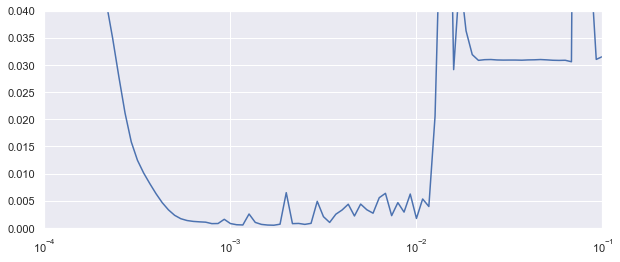

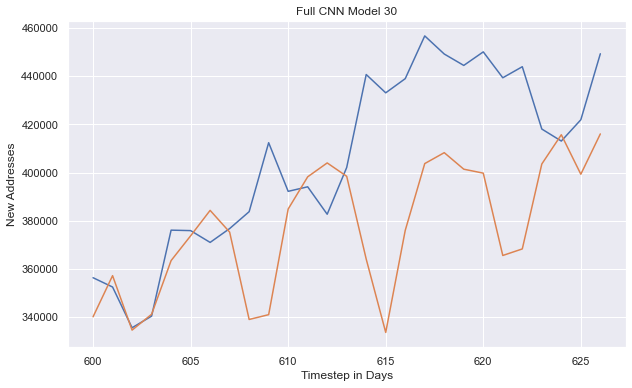

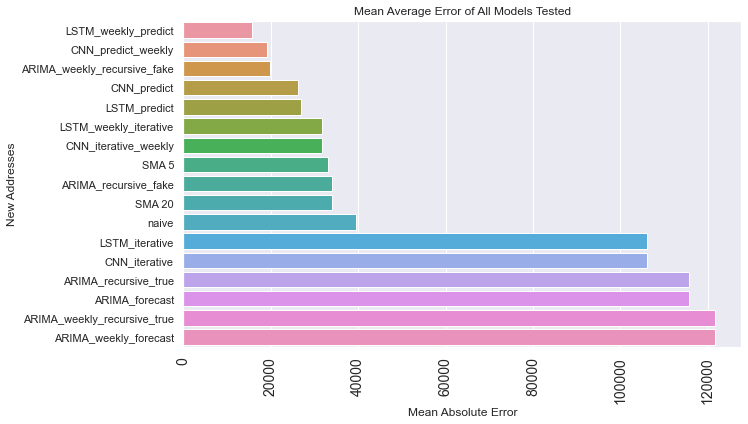

In [117]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

#This is the best learning rate
my_lr = history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=my_lr)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
yhat = normalized_x_test[0]
yhat = yhat[np.newaxis, :]
cnn_forecast = []
for i in range(len(normalized_x_test)):
    print(yhat.shape)
    yhat = model.predict(yhat)
    print(yhat.shape)
    print(i, "fatto")
    cnn_forecast.append(yhat)
    
cnn_forecast = np.array(cnn_forecast)
# Example of how to iverse
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['CNN_iterative_weekly'] = cnn
model_mae_scores['CNN_iterative_weekly'] = cnn
model_mae_scores



# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('New Addresses')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(x_test.index, x_test)
plt.plot(x_test.index, cnn_unscaled_forecast)

# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores_weekly['CNN_predict_weekly'] = cnn
model_mae_scores['CNN_predict_weekly'] = cnn
model_mae_scores

mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

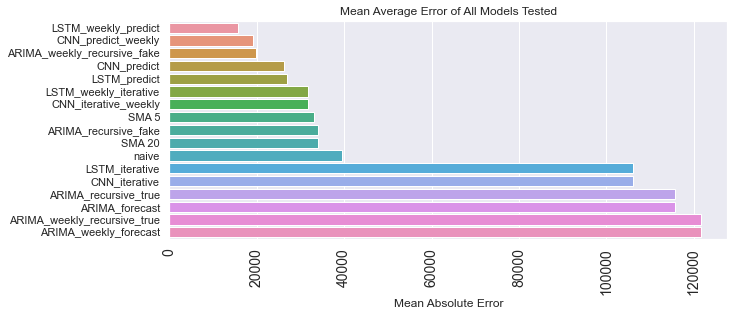

In [118]:
mae_series_weekly = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

Text(0.5, 1.0, 'Weekly Data - Mean Average Error of All Models Tested')

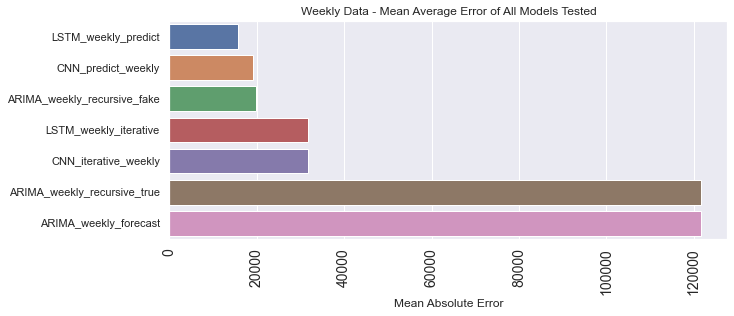

In [119]:
mae_series_weekly = pd.Series(model_mae_scores_weekly)
model_mae_scores_weekly

# Sort vales for clean bar chart
order = mae_series_weekly.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Weekly Data - Mean Average Error of All Models Tested')